# Complete Exploratory Data Analysis

## Table of Contents

| Section | Cell | Description |
|---|---|---|
| 1. Data Loading & Configuration | Cell 1 | Configuration and loading CoinMetrics data |
| 2. Data Integrity | Cell 3 | Types, ranges, missingness |
| 3. Descriptive Statistics | Cell 8 | Summary stats by category |
| 4. Distribution Plots | Cell 10 | Feature distributions |
| 5. Stationarity Testing | Cell 11 | ADF + KPSS on all series 
| 6. First Differences | Cell 14 | Confirming I(1) classification |
| 7. Granger Causality | Cell 16 | Bivariate tests + BH correction |
| 8. MVRV Validity Check | Cell 21 | Circularity assessment |
| 9. Correlation Heatmap | Cell 22 | Levels vs changes correlation |
| 10. Rolling Correlation | Cell 23 | Regime stability analysis |
| 11. Cointegration | Cell 24 | Engle-Granger vs PriceUSD |
| 12. Polymarket Audit | Cell 26 | Data quality and coverage |
| 13. Polymarket Signals | Cell 29 | Signal construction |
| 14. Mutual Information | Cell 47 | Non-linear dependence |
| 15. Wavelet Coherence | Cell 49 | Multi-scale MVRV analysis |
| 16. Cross-Feature Tests | Cell 55 | Polymarket + on-chain joint |

*Cell numbers are approximate — use Ctrl+F to search section headings*

<a id="data-loading"></a>
## Data Loading & Configuration

In [1]:
from contextlib import contextmanager
from datetime import datetime
from pathlib import Path
from typing import Optional
import pandas as pd
import polars as pl
import psutil
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configuration
# Robustly determine the project root directory
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if 'eda' in str(NOTEBOOK_DIR) else NOTEBOOK_DIR
DATA_DIR = PROJECT_ROOT / "data"
PLOTS_DIR = NOTEBOOK_DIR / "plots"
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
POLYMARKET_DIR = DATA_DIR / "Polymarket"



In [2]:

def load_bitcoin_data(filepath: Path) -> Optional[pl.DataFrame]:
    """
    Load Bitcoin data from CSV using Polars lazy scan.
    
    Args:
        filepath: Path to the Coin Metrics CSV file
    
    Returns:
        Polars DataFrame with parsed datetime column, or None if loading fails
    """
    print(f"Loading Bitcoin data from {filepath}...")
    #try:
        #def load_bitcoin_data(filepath: Path) -> Optional[pl.DataFrame]:
    """
    Load Bitcoin data from CSV using Polars lazy scan.
    
    Args:
        filepath: Path to the Coin Metrics CSV file
    
    Returns:
        Polars DataFrame with parsed datetime column, or None if loading fails
    """
    print(f"Loading Bitcoin data from {filepath}...")
    try:
        df = (
            pl.scan_csv(filepath, infer_schema_length=10000)
            .with_columns(pl.col("time").str.to_datetime())
            .collect()
        )
        print(f"Successfully loaded {len(df)} rows, {len(df.columns)} columns")
        return df
    except Exception as e:
        print(f"Error loading Bitcoin data: {e}")
        return None

# Load the data
        df = (
            pl.scan_csv(filepath, infer_schema_length=10000)
            .with_columns(pl.col("time").str.to_datetime())
            .collect()
        )
        print(f"Successfully loaded {len(df)} rows, {len(df.columns)} columns")
        return df
    except Exception as e:
        print(f"Error loading Bitcoin data: {e}")
        return None

# Load the data
btc_df = load_bitcoin_data(COINMETRICS_PATH)

Loading Bitcoin data from /home/dg/Documents/bitcoin-analytics-capstone-template/data/Coin Metrics/coinmetrics_btc.csv...
Loading Bitcoin data from /home/dg/Documents/bitcoin-analytics-capstone-template/data/Coin Metrics/coinmetrics_btc.csv...
Successfully loaded 6221 rows, 32 columns


<a id="data-audit"></a>
## Data Integrity Checks

In [3]:
# Data Integrity Check 1: Data Types/Ranges


print("DATA INTEGRITY CHECK 1: DATA TYPES AND RANGES\n")

btc_pd = btc_df.to_pandas()

print(f"\nDataset shape: {btc_pd.shape}")
print(f"Date range: {btc_pd['time'].min()} to {btc_pd['time'].max()}")
print(f"Total days: {(btc_pd['time'].max() - btc_pd['time'].min()).days}")

print("\nData Types")
print(btc_pd.dtypes)

print("\nNumeric Columns: Min/Max/Range")
numeric_cols = btc_pd.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    min_val = btc_pd[col].min()
    max_val = btc_pd[col].max()
    range_val = max_val - min_val
    print(f"{col:30s} | Min: {min_val:15.2e} | Max: {max_val:15.2e} | Range: {range_val:15.2e}")

DATA INTEGRITY CHECK 1: DATA TYPES AND RANGES


Dataset shape: (6221, 32)
Date range: 2009-01-03 00:00:00 to 2026-01-14 00:00:00
Total days: 6220

Data Types
time                           datetime64[us]
AdrActCnt                             float64
AdrBalCnt                             float64
AssetCompletionTime                   float64
AssetEODCompletionTime                float64
BlkCnt                                float64
CapMVRVCur                            float64
CapMrktCurUSD                         float64
CapMrktEstUSD                         float64
FeeTotNtv                             float64
FlowInExNtv                           float64
FlowInExUSD                           float64
FlowOutExNtv                          float64
FlowOutExUSD                          float64
HashRate                              float64
IssTotNtv                             float64
IssTotUSD                             float64
PriceBTC                              float64
PriceUSD      

In [4]:
# Data Integrity Check 2: Missingness/Completeness

print("DATA INTEGRITY CHECK 2: MISSINGNESS AND COMPLETENESS\n")


# Check missing values
print("\nMissing Values (count and %)")
missing_summary = pd.DataFrame({
    'Column': btc_pd.columns,
    'Missing_Count': btc_pd.isnull().sum(),
    'Missing_Pct': (btc_pd.isnull().sum() / len(btc_pd) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_summary) > 0:
    print(missing_summary.to_string(index=False))
else:
    print("No missing values detected!")

# Check for zeros (might indicate missing)
print("\nColumns with potential zero-encoding issues")
numeric_cols = btc_pd.select_dtypes(include=[np.number]).columns
zero_summary = []
for col in numeric_cols:
    zero_count = (btc_pd[col] == 0).sum()
    zero_pct = zero_count / len(btc_pd) * 100
    if zero_pct > 10:  # Flag if >10% are zeros
        zero_summary.append({'Column': col, 'Zero_Count': zero_count, 'Zero_Pct': zero_pct})

if zero_summary:
    zero_df = pd.DataFrame(zero_summary).sort_values('Zero_Pct', ascending=False)
    print(zero_df.to_string(index=False))
else:
    print("No columns with suspicious zero-encoding detected.")

DATA INTEGRITY CHECK 2: MISSINGNESS AND COMPLETENESS


Missing Values (count and %)
                     Column  Missing_Count  Missing_Pct
              ReferenceRate           6214        99.89
           ReferenceRateEUR           6214        99.89
           ReferenceRateETH           6214        99.89
           ReferenceRateUSD           6214        99.89
              CapMrktEstUSD           3823        61.45
                     ROI1yr            927        14.90
                     ROI30d            592         9.52
                  IssTotUSD            562         9.03
                   PriceUSD            562         9.03
                 CapMVRVCur            562         9.03
              CapMrktCurUSD            562         9.03
                FlowInExUSD            562         9.03
               FlowOutExUSD            562         9.03
                  SplyExUSD            562         9.03
volume_reported_spot_usd_1d            562         9.03
                  Is

## Observations from missingness check
### Critical issues (drop these columns):

ReferenceRate* columns (all 4 variants) — 99.89% missing. These not useful. CapMrktEstUSD — 61.45% missing. Too sparse for reliable testing.
### Moderate issues (care!):

ROI1yr, ROI30d — \~10-15% missing. These are derived metrics (returns). The 562 rows (\~9%) missing in price/cap/flow columns — likely early Bitcoin data before these metrics were tracked.
### Minor issues (acceptable):

7 rows missing in HashRate, IssTotNtv, SplyExpFut10yr — negligible, can forward-fill or drop those rows.
1 row missing scattered across many columns — drop that single row.
### Zero-encoding (real zeroes):

FlowInExNtv, FlowOutExNtv, SplyExNtv have ~13% zeros — these are legitimate zeros (no flow on some days), not missing data.


Early Bitcoin data (pre-PriceUSD availability) was dropped as it predates reliable price discovery and has sparse on-chain coverage. The analysis begins from the first date where all core metrics are available.

In [5]:
# Filter dataset to where PriceUSD first becomes available
first_valid_idx = btc_pd['PriceUSD'].first_valid_index()
first_valid_date = btc_pd.loc[first_valid_idx, 'time']

print(f"First valid PriceUSD date: {first_valid_date}")

btc_pd = btc_pd[btc_pd['time'] >= first_valid_date].reset_index(drop=True)

print(f"Dataset shape after filtering: {btc_pd.shape}")
print(f"Date range: {btc_pd['time'].min()} to {btc_pd['time'].max()}")
print(f"\nRemaining missing values:\n{btc_pd.isnull().sum()[btc_pd.isnull().sum() > 0]}")

First valid PriceUSD date: 2010-07-18 00:00:00
Dataset shape after filtering: (5660, 32)
Date range: 2010-07-18 00:00:00 to 2026-01-14 00:00:00

Remaining missing values:
AdrActCnt                         1
AdrBalCnt                         1
AssetCompletionTime               1
AssetEODCompletionTime            1
BlkCnt                            1
CapMVRVCur                        1
CapMrktCurUSD                     1
CapMrktEstUSD                  3262
FeeTotNtv                         1
FlowInExNtv                       1
FlowInExUSD                       1
FlowOutExNtv                      1
FlowOutExUSD                      1
HashRate                          1
IssTotNtv                         1
IssTotUSD                         1
PriceBTC                          1
PriceUSD                          1
ROI1yr                          366
ROI30d                           31
ReferenceRate                  5653
ReferenceRateETH               5653
ReferenceRateEUR               5653
R

In [6]:
# Final Cleaning

print("FINAL CLEANING\n")


# 1: Drop high-missingness columns
cols_to_drop = [
    'ReferenceRate', 'ReferenceRateETH', 'ReferenceRateEUR', 
    'ReferenceRateUSD', 'CapMrktEstUSD'
]
btc_pd = btc_pd.drop(columns=cols_to_drop)
print(f"\nDropped columns: {cols_to_drop}")

# 2: Drop the single row with NaN across core columns
rows_before = len(btc_pd)
btc_pd = btc_pd.dropna(subset=['PriceUSD', 'HashRate', 'TxCnt'])
print(f"Dropped {rows_before - len(btc_pd)} row(s) with missing core values")

# 3: Set time as index
btc_pd = btc_pd.set_index('time')

print(f"\nFinal dataset shape: {btc_pd.shape}")
print(f"Date range: {btc_pd.index.min()} to {btc_pd.index.max()}")
print(f"Columns remaining: {list(btc_pd.columns)}")
print(f"\nAny remaining NaN:\n{btc_pd.isnull().sum()[btc_pd.isnull().sum() > 0]}")

FINAL CLEANING


Dropped columns: ['ReferenceRate', 'ReferenceRateETH', 'ReferenceRateEUR', 'ReferenceRateUSD', 'CapMrktEstUSD']
Dropped 1 row(s) with missing core values

Final dataset shape: (5659, 26)
Date range: 2010-07-18 00:00:00 to 2026-01-13 00:00:00
Columns remaining: ['AdrActCnt', 'AdrBalCnt', 'AssetCompletionTime', 'AssetEODCompletionTime', 'BlkCnt', 'CapMVRVCur', 'CapMrktCurUSD', 'FeeTotNtv', 'FlowInExNtv', 'FlowInExUSD', 'FlowOutExNtv', 'FlowOutExUSD', 'HashRate', 'IssTotNtv', 'IssTotUSD', 'PriceBTC', 'PriceUSD', 'ROI1yr', 'ROI30d', 'SplyCur', 'SplyExNtv', 'SplyExUSD', 'SplyExpFut10yr', 'TxCnt', 'TxTfrCnt', 'volume_reported_spot_usd_1d']

Any remaining NaN:
ROI1yr    365
ROI30d     30
dtype: int64


In [7]:
# Drop columns not useful for accumulation signal analysis
cols_to_drop_analysis = [
    'AssetCompletionTime',    # Data QA timestamp, not a signal
    'AssetEODCompletionTime', # Data QA timestamp, not a signal  
    'PriceBTC',               # Always = 1.0
]

btc_pd = btc_pd.drop(columns=cols_to_drop_analysis)
print(f"Final analytical dataset: {btc_pd.shape}")
print(f"\nColumns grouped by category:")

# Define our semantic groupings for later use
col_groups = {
    'Price/Value':    ['PriceUSD', 'CapMrktCurUSD', 'CapMVRVCur', 'ROI1yr', 'ROI30d'],
    'Network':        ['TxCnt', 'TxTfrCnt', 'AdrActCnt', 'AdrBalCnt'],
    'Supply':         ['SplyCur', 'IssTotNtv', 'IssTotUSD', 'SplyExpFut10yr'],
    'Mining':         ['HashRate', 'BlkCnt'],
    'Flows':          ['FlowInExNtv', 'FlowInExUSD', 'FlowOutExNtv', 'FlowOutExUSD', 
                       'SplyExNtv', 'SplyExUSD'],
    'Fees/Market':    ['FeeTotNtv', 'volume_reported_spot_usd_1d'],
}

for group, cols in col_groups.items():
    print(f"  {group:15s}: {cols}")

Final analytical dataset: (5659, 23)

Columns grouped by category:
  Price/Value    : ['PriceUSD', 'CapMrktCurUSD', 'CapMVRVCur', 'ROI1yr', 'ROI30d']
  Network        : ['TxCnt', 'TxTfrCnt', 'AdrActCnt', 'AdrBalCnt']
  Supply         : ['SplyCur', 'IssTotNtv', 'IssTotUSD', 'SplyExpFut10yr']
  Mining         : ['HashRate', 'BlkCnt']
  Flows          : ['FlowInExNtv', 'FlowInExUSD', 'FlowOutExNtv', 'FlowOutExUSD', 'SplyExNtv', 'SplyExUSD']
  Fees/Market    : ['FeeTotNtv', 'volume_reported_spot_usd_1d']


<a id="descriptive-stats"></a>
## Descriptive Statistics

In [8]:
# Data Integrity Check 3: Descriptive Statistics

print("DATA INTEGRITY CHECK 3: DESCRIPTIVE STATISTICS BY CATEGORY\n")

col_groups = {
    'Price/Value':    ['PriceUSD', 'CapMrktCurUSD', 'CapMVRVCur', 'ROI1yr', 'ROI30d'],
    'Network':        ['TxCnt', 'TxTfrCnt', 'AdrActCnt', 'AdrBalCnt'],
    'Supply':         ['SplyCur', 'IssTotNtv', 'IssTotUSD', 'SplyExpFut10yr'],
    'Mining':         ['HashRate', 'BlkCnt'],
    'Flows':          ['FlowInExNtv', 'FlowInExUSD', 'FlowOutExNtv', 'FlowOutExUSD', 
                       'SplyExNtv', 'SplyExUSD'],
    'Fees/Market':    ['FeeTotNtv', 'volume_reported_spot_usd_1d'],
}

for group_name, cols in col_groups.items():
    print(f"\n{group_name}")
    
    # Filter to columns that exist and drop NaN for this group
    valid_cols = [c for c in cols if c in btc_pd.columns]
    group_data = btc_pd[valid_cols].dropna()
    
    # Compute statistics
    stats = group_data.describe().T
    stats['CV'] = (stats['std'] / stats['mean']).round(3)  # Coefficient of variation
    stats['Range'] = (stats['max'] - stats['min']).round(2)
    
    # Display selected columns
    display_cols = ['count', 'mean', 'std', 'CV', 'min', 'max']
    print(stats[display_cols].to_string())

DATA INTEGRITY CHECK 3: DESCRIPTIVE STATISTICS BY CATEGORY


Price/Value
                count          mean           std     CV           min           max
PriceUSD       5294.0  2.117560e+04  3.023145e+04  1.428  2.105066e+00  1.248245e+05
CapMrktCurUSD  5294.0  4.090198e+11  5.983364e+11  1.463  1.619711e+07  2.487865e+12
CapMVRVCur     5294.0  1.762332e+00  7.116192e-01  0.404  3.868285e-01  5.884068e+00
ROI1yr         5294.0  5.596433e+02  1.944973e+03  3.475 -8.373049e+01  2.766663e+04
ROI30d         5294.0  9.133422e+00  3.678087e+01  4.027 -6.166827e+01  4.703497e+02

Network
            count          mean           std     CV      min         max
TxCnt      5659.0  2.290720e+05  1.647516e+05  0.719     94.0    928131.0
TxTfrCnt   5659.0  5.463871e+05  3.553155e+05  0.650    147.0   2041653.0
AdrActCnt  5659.0  5.505431e+05  3.618383e+05  0.657    408.0   1366494.0
AdrBalCnt  5659.0  2.286900e+07  1.934974e+07  0.846  52190.0  55924280.0

Supply
                 count        

DATA INTEGRITY CHECK 4: INITIAL EXPLORATORY VISUALIZATIONS

Plots directory: /home/dg/Documents/bitcoin-analytics-capstone-template/eda/plots
Directory exists: True

Saved: eda_01_time_series_overview.png


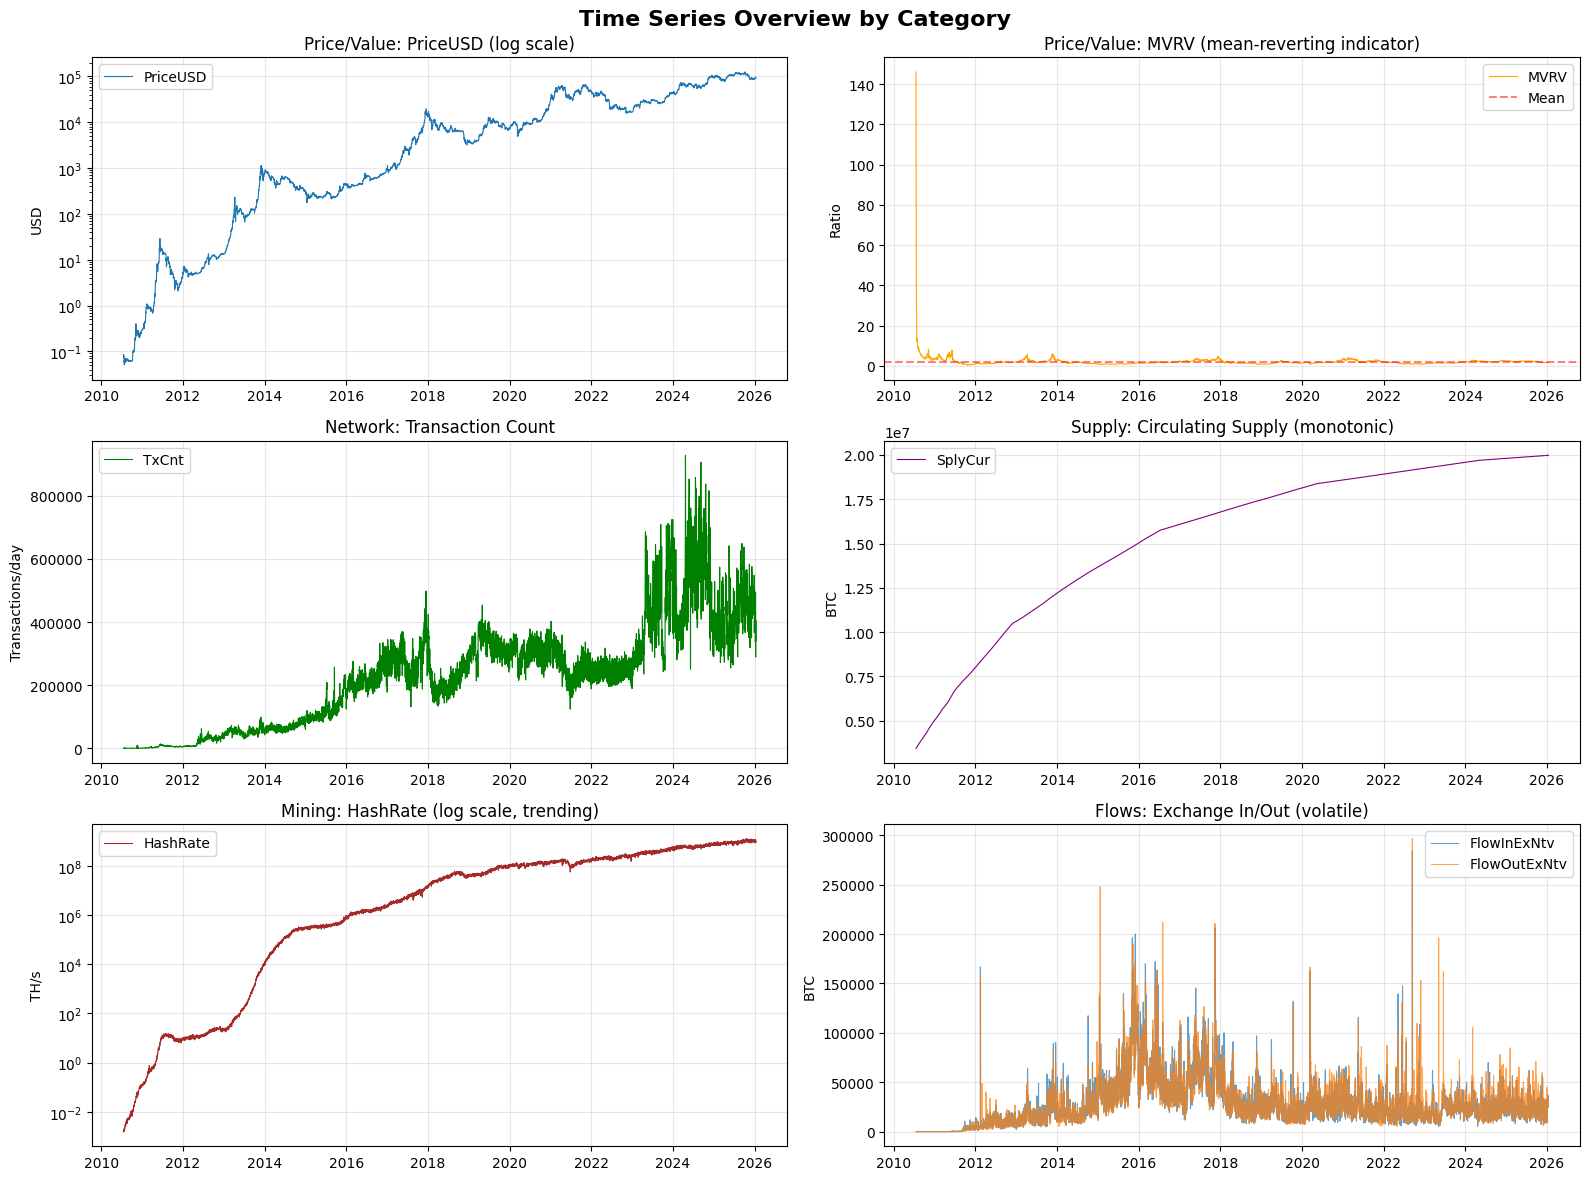

In [9]:
# Data Integrity Check 4: Initial Exploratory Visualizations

print("DATA INTEGRITY CHECK 4: INITIAL EXPLORATORY VISUALIZATIONS\n")


# plot directory?
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Plots directory: {PLOTS_DIR}")
print(f"Directory exists: {PLOTS_DIR.exists()}")


# Create a 3x2 grid of time series plots for each category
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Time Series Overview by Category', fontsize=16, fontweight='bold')

# Price/Value - log scale (prices span many orders of magnitude)
ax = axes[0, 0]
ax.semilogy(btc_pd.index, btc_pd['PriceUSD'], linewidth=0.8, label='PriceUSD')
ax.set_title('Price/Value: PriceUSD (log scale)')
ax.set_ylabel('USD')
ax.grid(True, alpha=0.3)
ax.legend()

# MVRV - bounded metric, should be stationary-ish
ax = axes[0, 1]
ax.plot(btc_pd.index, btc_pd['CapMVRVCur'], linewidth=0.8, label='MVRV', color='orange')
ax.axhline(y=btc_pd['CapMVRVCur'].mean(), color='r', linestyle='--', alpha=0.5, label='Mean')
ax.set_title('Price/Value: MVRV (mean-reverting indicator)')
ax.set_ylabel('Ratio')
ax.grid(True, alpha=0.3)
ax.legend()

# Network activity
ax = axes[1, 0]
ax.plot(btc_pd.index, btc_pd['TxCnt'], linewidth=0.8, label='TxCnt', color='green')
ax.set_title('Network: Transaction Count')
ax.set_ylabel('Transactions/day')
ax.grid(True, alpha=0.3)
ax.legend()

# Supply (monotonically increasing)
ax = axes[1, 1]
ax.plot(btc_pd.index, btc_pd['SplyCur'], linewidth=0.8, label='SplyCur', color='purple')
ax.set_title('Supply: Circulating Supply (monotonic)')
ax.set_ylabel('BTC')
ax.grid(True, alpha=0.3)
ax.legend()

# HashRate (trending up)
ax = axes[2, 0]
ax.semilogy(btc_pd.index, btc_pd['HashRate'], linewidth=0.8, label='HashRate', color='brown')
ax.set_title('Mining: HashRate (log scale, trending)')
ax.set_ylabel('TH/s')
ax.grid(True, alpha=0.3)
ax.legend()

# Flows (volatile, zero-heavy)
ax = axes[2, 1]
ax.plot(btc_pd.index, btc_pd['FlowInExNtv'], linewidth=0.8, label='FlowInExNtv', alpha=0.7)
ax.plot(btc_pd.index, btc_pd['FlowOutExNtv'], linewidth=0.8, label='FlowOutExNtv', alpha=0.7)
ax.set_title('Flows: Exchange In/Out (volatile)')
ax.set_ylabel('BTC')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_01_time_series_overview.png', dpi=150, bbox_inches='tight')
print("\nSaved: eda_01_time_series_overview.png")
plt.show()

## Visual Stationarity Diagnosis

The following table summarises the visual inspection of each time series,
providing a prior expectation before formal statistical testing.

| Series | Pattern | Implication | Priority for Testing |
|---|---|---|---|
| **PriceUSD** | Strong uptrend (log scale) | I(1) — non-stationary | ✓ Test log-returns |
| **MVRV** | Oscillates around mean, spikes | I(0) — likely stationary | ✓ High priority |
| **TxCnt** | Trending up with cycles | I(1) — non-stationary | ✓ Difference first |
| **SplyCur** | Monotonic increase (by design) | I(1) — deterministic trend | ✓ Expect non-stationary |
| **HashRate** | Strong uptrend (log scale) | I(1) — non-stationary | ✓ Test log-returns |
| **Flows** | Volatile, mean-reverting spikes | I(0) — likely stationary | ✓ High priority |

**Key:**
- **I(0)** — stationary in levels; can be used directly in Granger causality tests
- **I(1)** — non-stationary; must be differenced (or log-differenced) before testing
- Formal confirmation via **ADF** and **KPSS** tests follows in the next section

Saved: eda_02_distributions.png


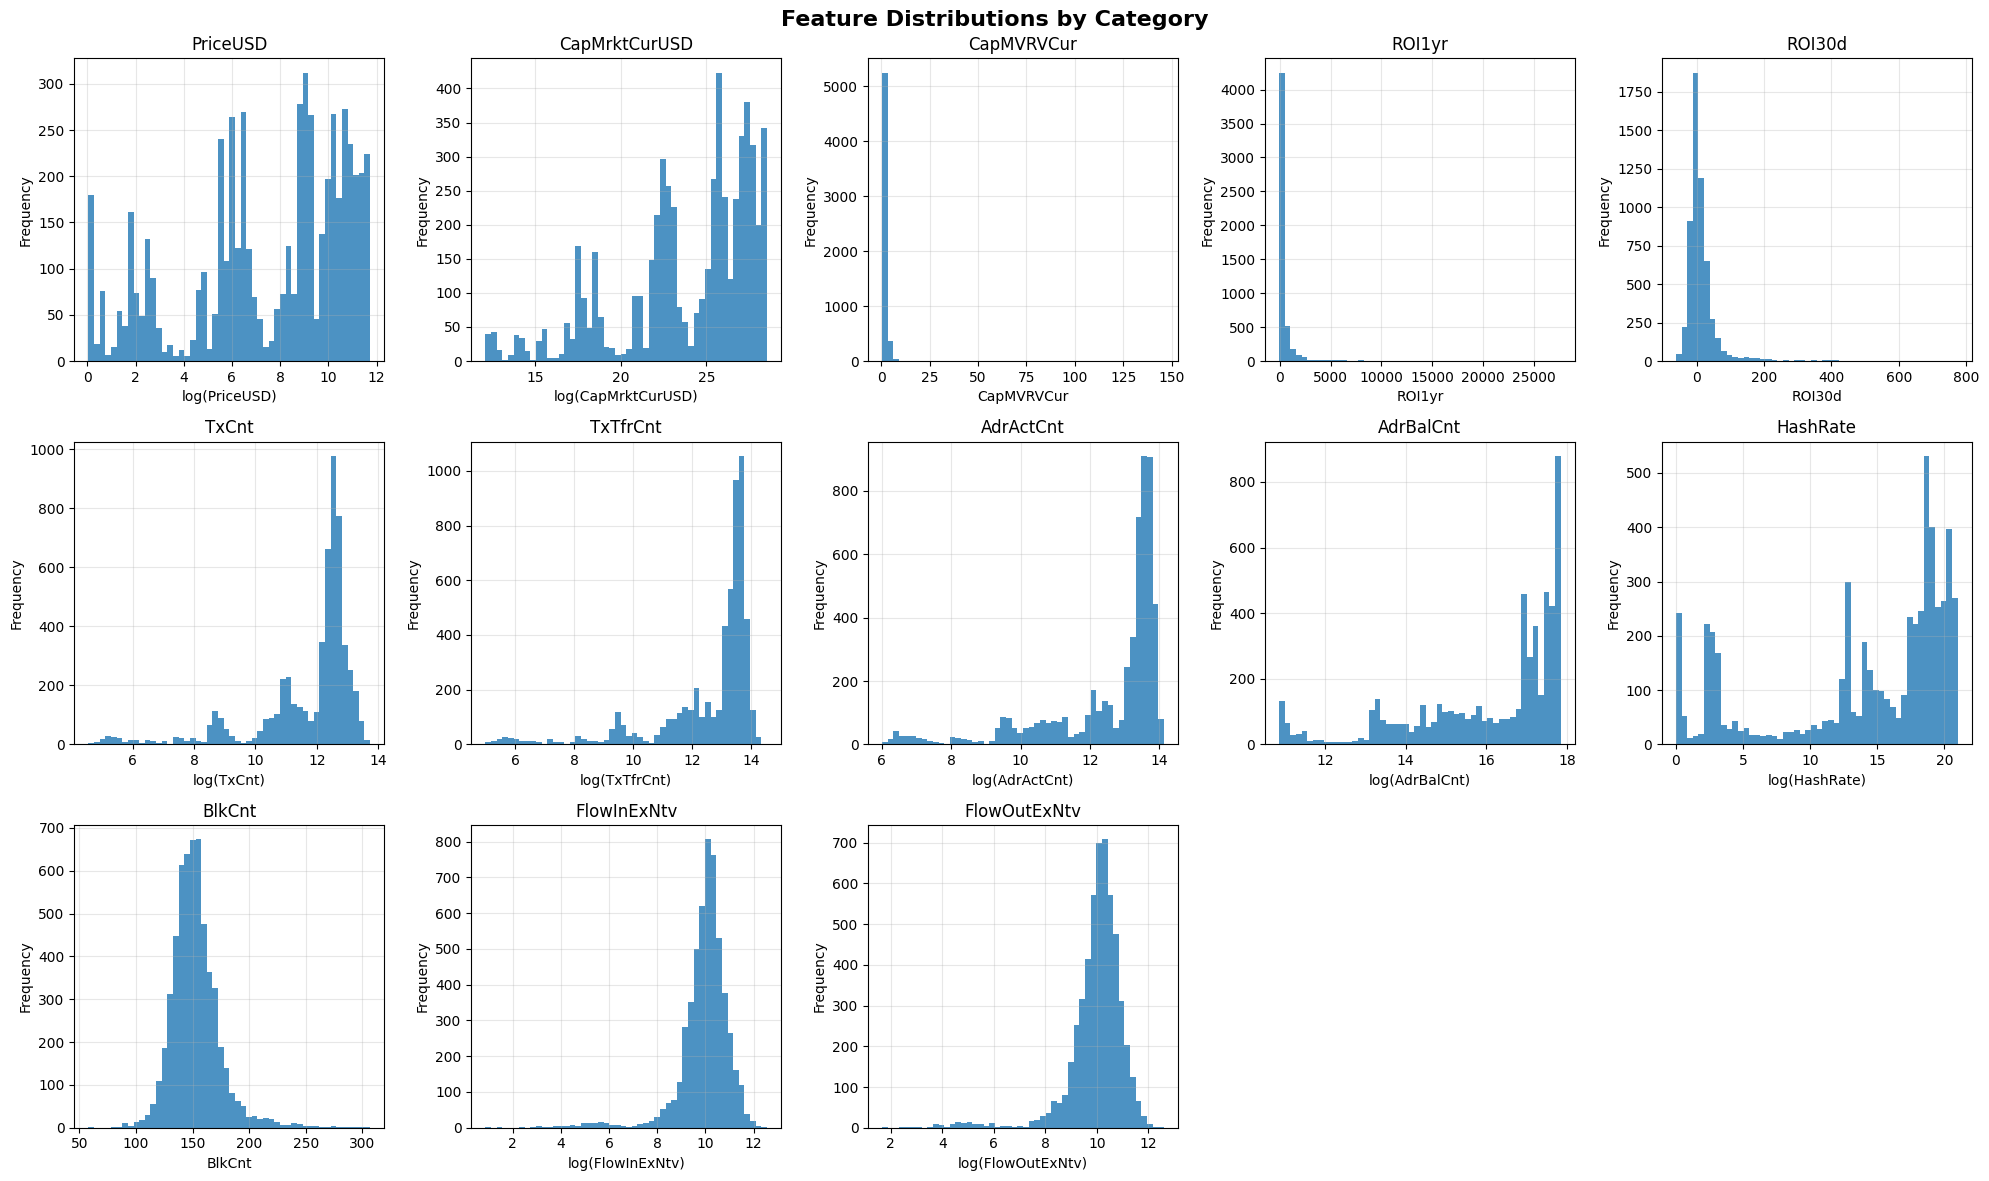

In [10]:
# Distribution Plots by Category

fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Changed from 4x3 to 3x5
fig.suptitle('Feature Distributions by Category', fontsize=16, fontweight='bold')
axes = axes.flatten()  # Makes it easier to iterate

# Flatten all columns from groups into a single ordered list for plotting
plot_cols = [
    'PriceUSD', 'CapMrktCurUSD', 'CapMVRVCur', 'ROI1yr', 'ROI30d',  # Price/Value
    'TxCnt', 'TxTfrCnt', 'AdrActCnt', 'AdrBalCnt',                   # Network
    'HashRate', 'BlkCnt',                                              # Mining
    'FlowInExNtv', 'FlowOutExNtv',                                    # Flows (native only)
]

# Columns that need log scale due to skew
log_cols = ['PriceUSD', 'CapMrktCurUSD', 'HashRate', 'TxCnt', 
            'TxTfrCnt', 'AdrActCnt', 'AdrBalCnt', 'FlowInExNtv', 'FlowOutExNtv']

for i, col in enumerate(plot_cols):
    ax = axes[i]
    data = btc_pd[col].dropna()
    
    if col in log_cols:
        # Log transform for skewed series — drop zeros 
        data = np.log1p(data[data > 0])
        ax.hist(data, bins=50, edgecolor='none', alpha=0.8)
        ax.set_xlabel(f'log({col})')
    else:
        ax.hist(data, bins=50, edgecolor='none', alpha=0.8)
        ax.set_xlabel(col)
    
    ax.set_title(col)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for j in range(len(plot_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_02_distributions.png', dpi=150, bbox_inches='tight')
print("Saved: eda_02_distributions.png")
plt.show()

## Feature Distribution Summary

The distributions reveal important characteristics for subsequent statistical testing:

| Series | Distribution Shape | Implication | Log Transform Needed |
|---|---|---|---|
| **PriceUSD** | Bimodal (log scale) | Reflects bull/bear regimes; log-returns more useful | ✓ Yes |
| **CapMrktCurUSD** | Bimodal (log scale) | Market cap follows price; log-transform appropriate | ✓ Yes |
| **CapMVRVCur** | Right-skewed, concentrated | Good mean-reverting signal candidate | ✗ No |
| **ROI1yr** | Heavily right-skewed | Extreme outliers; may need robust testing | ✓ Consider |
| **ROI30d** | Heavily right-skewed | Extreme outliers; may need robust testing | ✓ Consider |
| **TxCnt** | Left-skewed (log scale) | Network activity growing; log-transform helps | ✓ Yes |
| **TxTfrCnt** | Left-skewed (log scale) | Transfer count growing; log-transform helps | ✓ Yes |
| **AdrActCnt** | Left-skewed (log scale) | Active addresses growing; log-transform helps | ✓ Yes |
| **AdrBalCnt** | Left-skewed (log scale) | Address count growing; log-transform helps | ✓ Yes |
| **BlkCnt** | Tight, approximately normal | Very stable (by design — ~10 min blocks) | ✗ No |
| **HashRate** | Left-skewed (log scale) | Mining power trending up; log-transform helps | ✓ Yes |
| **FlowInExNtv** | Left-skewed (log scale) | Zero-heavy; log transform appropriate | ✓ Yes |
| **FlowOutExNtv** | Left-skewed (log scale) | Zero-heavy; log transform appropriate | ✓ Yes |

**Key takeaway:** Most series require log transformation before stationarity testing to account for exponential growth and skew. This will be applied systematically in the next phase.

<a id="stationarity"></a>
## Stationarity Testing: ADF + KPSS

In [11]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

print("Statsmodels imported successfully")
print(f"ADF and KPSS tests available")

Statsmodels imported successfully
ADF and KPSS tests available


In [12]:
def run_stationarity_tests(series, col_name, log_transform=False):
    """
    Run ADF and KPSS tests on a series.
    Both tests together give a robust classification:
    - ADF null: unit root exists (non-stationary)
    - KPSS null: series IS stationary
    Using both reduces chance of being misled by either alone.
    """
    # Clean data
    data = series.dropna()
    if len(data) < 10:
        return None

    # Apply log transform if requested
    if log_transform:
        data = np.log1p(data[data > 0])
        if len(data) < 10:
            return None

    # ADF Test — returns tuple: (stat, pvalue, usedlag, nobs, critical_values, ic_best)
    adf_result = adfuller(data, autolag='AIC')
    adf_stat   = float(adf_result[0])   # index 0 = test statistic
    adf_pvalue = float(adf_result[1])   # index 1 = p-value

    # KPSS Test — returns tuple: (stat, pvalue, nlags, critical_values)
    # Note: statsmodels caps KPSS p-value at 0.01 (lower) and 0.10 (upper)
    kpss_result = kpss(data, regression='c', nlags='auto')
    kpss_stat   = float(kpss_result[0])  # index 0 = test statistic
    kpss_pvalue = float(kpss_result[1])  # index 1 = p-value (may be 0.01 or 0.10 at bounds)

    # Classification logic (requires BOTH tests to agree)
    # I(0): ADF rejects null (p < 0.05) AND KPSS fails to reject null (p >= 0.05)
    # I(1): ADF fails to reject (p >= 0.05) OR KPSS rejects (p < 0.05)
    if adf_pvalue < 0.05 and kpss_pvalue >= 0.05:
        classification = 'I(0) - Stationary'
    elif adf_pvalue >= 0.05 and kpss_pvalue < 0.05:
        classification = 'I(1) - Non-stationary'
    else:
        classification = 'Ambiguous'

    return {
        'Column':         col_name,
        'Log_Transform':  log_transform,
        'ADF_Stat':       adf_stat,
        'ADF_pvalue':     adf_pvalue,
        'KPSS_Stat':      kpss_stat,
        'KPSS_pvalue':    kpss_pvalue,
        'Classification': classification,
        'N_Obs':          len(data)
    }

In [13]:
# Stationarity Testing: ADF + KPSS

print("STATIONARITY TESTING: ADF + KPSS\n")


log_transform_cols = {
    'PriceUSD': True, 'CapMrktCurUSD': True, 'CapMVRVCur': False,
    'ROI1yr': False, 'ROI30d': False, 'TxCnt': True, 'TxTfrCnt': True,
    'AdrActCnt': True, 'AdrBalCnt': True, 'BlkCnt': False, 'HashRate': True,
    'FlowInExNtv': True, 'FlowInExUSD': True, 'FlowOutExNtv': True,
    'FlowOutExUSD': True, 'SplyCur': True, 'IssTotNtv': True,
    'IssTotUSD': True, 'SplyExpFut10yr': False, 'FeeTotNtv': True,
    'volume_reported_spot_usd_1d': True,
}

results = []
for col in btc_pd.columns:
    if col in log_transform_cols:
        result = run_stationarity_tests(
            btc_pd[col], col, log_transform=log_transform_cols[col]
        )
        if result:
            results.append(result)

stationarity_df = pd.DataFrame(results)

for classification in ['I(0) - Stationary', 'I(1) - Non-stationary', 'Ambiguous']:
    subset = stationarity_df[stationarity_df['Classification'] == classification]
    if len(subset) > 0:
        print(f"\n{classification} ({len(subset)} series):")
        print(subset[['Column', 'ADF_pvalue', 'KPSS_pvalue', 'Classification']].to_string(index=False))

STATIONARITY TESTING: ADF + KPSS


I(1) - Non-stationary (2 series):
   Column  ADF_pvalue  KPSS_pvalue        Classification
IssTotNtv    0.702141         0.01 I(1) - Non-stationary
 PriceUSD    0.252752         0.01 I(1) - Non-stationary

Ambiguous (19 series):
                     Column   ADF_pvalue  KPSS_pvalue Classification
                  AdrActCnt 1.968497e-06         0.01      Ambiguous
                  AdrBalCnt 7.601052e-04         0.01      Ambiguous
                     BlkCnt 5.210654e-09         0.01      Ambiguous
                 CapMVRVCur 2.445220e-07         0.01      Ambiguous
              CapMrktCurUSD 6.011814e-03         0.01      Ambiguous
                  FeeTotNtv 3.857400e-02         0.01      Ambiguous
                FlowInExNtv 2.096075e-07         0.01      Ambiguous
                FlowInExUSD 1.618051e-02         0.01      Ambiguous
               FlowOutExNtv 5.621405e-07         0.01      Ambiguous
               FlowOutExUSD 1.675807e-02      

| Finding | Interpretation |
|---|---|
| KPSS = 0.01 for all series | Strong evidence of non-stationarity / long-run trend in every series |
| ADF rejects for 19 series (p < 0.05) | These series have mean-reverting components but are not purely random walks |
| "Ambiguous" is the honest classification | ADF and KPSS disagree — both pieces of evidence are useful |

In [14]:
# Stationarity Testing on First Differences

print("STATIONARITY TESTING: FIRST DIFFERENCES\n")


# Take first differences of all series
# For log-transformed series, first difference = log return (% change)
diff_results = []

for col in log_transform_cols:
    if col not in btc_pd.columns:
        continue
    
    series = btc_pd[col].dropna()
    
    # Apply same log transform as before, then difference
    if log_transform_cols[col]:
        series = np.log1p(series[series > 0])
    
    # First difference
    series_diff = series.diff().dropna()
    
    result = run_stationarity_tests(series_diff, col, log_transform=False)
    if result:
        result['Column'] = f"Δ{col}"  # Mark as differenced
        diff_results.append(result)

diff_df = pd.DataFrame(diff_results)

for classification in ['I(0) - Stationary', 'I(1) - Non-stationary', 'Ambiguous']:
    subset = diff_df[diff_df['Classification'] == classification]
    if len(subset) > 0:
        print(f"\n{classification} ({len(subset)} series):")
        print(subset[['Column', 'ADF_pvalue', 'KPSS_pvalue', 
                       'Classification']].to_string(index=False))

STATIONARITY TESTING: FIRST DIFFERENCES


I(0) - Stationary (11 series):
       Column   ADF_pvalue  KPSS_pvalue    Classification
    ΔPriceUSD 1.260694e-18     0.100000 I(0) - Stationary
  ΔCapMVRVCur 3.230257e-29     0.079437 I(0) - Stationary
      ΔROI1yr 5.294096e-13     0.080815 I(0) - Stationary
      ΔROI30d 1.744414e-29     0.100000 I(0) - Stationary
      ΔBlkCnt 0.000000e+00     0.100000 I(0) - Stationary
 ΔFlowInExNtv 0.000000e+00     0.100000 I(0) - Stationary
 ΔFlowInExUSD 2.170732e-30     0.054393 I(0) - Stationary
ΔFlowOutExNtv 0.000000e+00     0.088330 I(0) - Stationary
   ΔIssTotNtv 0.000000e+00     0.100000 I(0) - Stationary
   ΔIssTotUSD 0.000000e+00     0.100000 I(0) - Stationary
   ΔFeeTotNtv 9.402894e-30     0.100000 I(0) - Stationary

Ambiguous (10 series):
                      Column   ADF_pvalue  KPSS_pvalue Classification
              ΔCapMrktCurUSD 6.692879e-24     0.010000      Ambiguous
                      ΔTxCnt 1.020903e-29     0.025890      Ambiguo

Interpreting the First Differences Results
The "Ambiguous" series after differencing — why they're still ambiguous
Look at the pattern: every ambiguous series has ADF p < 0.05 but KPSS p < 0.05 too. This means:

ADF says "stationary"
KPSS still sees residual structure


| Series | Likely Reason |
|---|---|
| ΔSplyCur, ΔSplyExpFut10yr | Halving events create structural breaks KPSS can't handle |
| ΔAdrBalCnt, ΔHashRate | Long-memory / slow mean reversion — trends so persistent that even differences retain structure? |
| ΔTxCnt, ΔTxTfrCnt, ΔAdrActCnt | Structural breaks — Covid, ETF approval etc. create regime shifts |
| ΔCapMrktCurUSD, ΔFlowOutExUSD | Heteroskedasticity — variance is non-constant  |

In [15]:
# build Complete Stationarity Classification Summary

print("COMPLETE STATIONARITY CLASSIFICATION SUMMARY\n")


# Final classification for each series
classification_summary = {
    # Confirmed I(1): non-stationary in levels, stationary after differencing
    'I(1) - Confirmed': [
        'PriceUSD', 'CapMVRVCur', 'ROI1yr', 'ROI30d', 'BlkCnt',
        'FlowInExNtv', 'FlowInExUSD', 'FlowOutExNtv', 'IssTotNtv',
        'IssTotUSD', 'FeeTotNtv'
    ],
    # I(1) with structural breaks / long memory — treat as I(1) with caution
    'I(1) - With Caveats': [
        'CapMrktCurUSD', 'TxCnt', 'TxTfrCnt', 'AdrActCnt', 'AdrBalCnt',
        'HashRate', 'FlowOutExUSD', 'SplyCur', 'SplyExpFut10yr',
        'volume_reported_spot_usd_1d'
    ],
}

for label, cols in classification_summary.items():
    print(f"\n{label} ({len(cols)} series):")
    for c in cols:
        print(f"  - {c}")

# Which series to use in Granger causality
granger_candidates = (
    classification_summary['I(1) - Confirmed'] + 
    classification_summary['I(1) - With Caveats']
)

print(f"\n→ Total series for Granger causality (differenced): {len(granger_candidates)}")
print("→ All will be first-differenced (log-differenced where log transform was applied)")

COMPLETE STATIONARITY CLASSIFICATION SUMMARY


I(1) - Confirmed (11 series):
  - PriceUSD
  - CapMVRVCur
  - ROI1yr
  - ROI30d
  - BlkCnt
  - FlowInExNtv
  - FlowInExUSD
  - FlowOutExNtv
  - IssTotNtv
  - IssTotUSD
  - FeeTotNtv

I(1) - With Caveats (10 series):
  - CapMrktCurUSD
  - TxCnt
  - TxTfrCnt
  - AdrActCnt
  - AdrBalCnt
  - HashRate
  - FlowOutExUSD
  - SplyCur
  - SplyExpFut10yr
  - volume_reported_spot_usd_1d

→ Total series for Granger causality (differenced): 21
→ All will be first-differenced (log-differenced where log transform was applied)


<a id="granger"></a>
## Granger Causality Tests

In [16]:
# Build Stationary (Differenced) Series for Granger Causality

# Store differenced series in a new DataFrame
diff_series = {}

for col in granger_candidates:
    if col not in btc_pd.columns:
        continue
    
    series = btc_pd[col].dropna()
    
    # Apply same log transform as stationarity testing
    if log_transform_cols.get(col, False):
        series = np.log1p(series[series > 0])
    
    # First difference
    diff_series[f"Δ{col}"] = series.diff()

# Combine into DataFrame, align on common index
diff_df = pd.DataFrame(diff_series).dropna()

print(f"Differenced DataFrame shape: {diff_df.shape}")
print(f"Date range: {diff_df.index.min()} to {diff_df.index.max()}")
print(f"\nColumns: {list(diff_df.columns)}")

Differenced DataFrame shape: (5293, 21)
Date range: 2011-07-19 00:00:00 to 2026-01-13 00:00:00

Columns: ['ΔPriceUSD', 'ΔCapMVRVCur', 'ΔROI1yr', 'ΔROI30d', 'ΔBlkCnt', 'ΔFlowInExNtv', 'ΔFlowInExUSD', 'ΔFlowOutExNtv', 'ΔIssTotNtv', 'ΔIssTotUSD', 'ΔFeeTotNtv', 'ΔCapMrktCurUSD', 'ΔTxCnt', 'ΔTxTfrCnt', 'ΔAdrActCnt', 'ΔAdrBalCnt', 'ΔHashRate', 'ΔFlowOutExUSD', 'ΔSplyCur', 'ΔSplyExpFut10yr', 'Δvolume_reported_spot_usd_1d']


In [17]:
from statsmodels.tsa.stattools import grangercausalitytests

# Granger Causality Tests

print("GRANGER CAUSALITY TESTS\n")

print("Testing: does each series Granger-cause ΔPriceUSD?")
print("i.e. Null hypothesis: X does NOT Granger-cause ΔPriceUSD")
print("Reject null (p < 0.05) → X has predictive power over Bitcoin price changes")
print()

# Test parameters
MAX_LAGS = 7        # Test up to 7 days of lags (1 week)
TARGET = 'ΔPriceUSD'

# Candidate series (everything except the target itself)
candidate_cols = [c for c in diff_df.columns if c != TARGET]

granger_results = []

for col in candidate_cols:
    # Build bivariate DataFrame: [target, predictor]
    # grangercausalitytests expects [Y, X] order
    pair_df = diff_df[[TARGET, col]].dropna()
    
    try:
        # Run test for all lags up to MAX_LAGS
        test_result = grangercausalitytests(pair_df, maxlag=MAX_LAGS, verbose=False)
        
        # Extract best (minimum) p-value across all lags and test types
        # Using F-test (ssr_ftest) as primary — most reliable for this sample size
        pvalues_by_lag = {}
        for lag in range(1, MAX_LAGS + 1):
            ftest_pval = test_result[lag][0]['ssr_ftest'][1]
            pvalues_by_lag[lag] = ftest_pval
        
        best_lag = min(pvalues_by_lag, key=pvalues_by_lag.get)
        best_pval = pvalues_by_lag[best_lag]
        
        granger_results.append({
            'Series':     col,
            'Best_Lag':   best_lag,
            'Best_Pval':  best_pval,
            'Lag1_Pval':  pvalues_by_lag[1],
            'Lag3_Pval':  pvalues_by_lag[3],
            'Lag7_Pval':  pvalues_by_lag[7],
            'Significant': best_pval < 0.05
        })
        
    except Exception as e:
        print(f"  Error testing {col}: {e}")
        continue

granger_df = pd.DataFrame(granger_results).sort_values('Best_Pval')

print("\nResults ranked by p-value\n")
print(granger_df.to_string(index=False))

GRANGER CAUSALITY TESTS

Testing: does each series Granger-cause ΔPriceUSD?
i.e. Null hypothesis: X does NOT Granger-cause ΔPriceUSD
Reject null (p < 0.05) → X has predictive power over Bitcoin price changes


Results ranked by p-value

                      Series  Best_Lag    Best_Pval    Lag1_Pval    Lag3_Pval    Lag7_Pval  Significant
                 ΔCapMVRVCur         7 2.161238e-25 2.154214e-13 2.773229e-16 2.161238e-25         True
                     ΔROI1yr         7 2.997386e-10 4.908387e-01 3.463123e-02 2.997386e-10         True
                     ΔROI30d         7 6.420053e-09 6.767240e-03 7.832440e-07 6.420053e-09         True
                  ΔAdrBalCnt         6 1.450815e-02 1.940486e-02 2.667170e-02 2.139508e-02         True
                   ΔHashRate         7 2.385651e-02 1.761929e-01 5.139144e-01 2.385651e-02         True
             ΔSplyExpFut10yr         1 3.494716e-02 3.494716e-02 1.966669e-01 6.186428e-01         True
                     ΔBlkCnt       

### Use Benjamini-Hockberg FDR method to control for spurious outcomes to granger tests

In [18]:
from scipy.stats import false_discovery_control

# Multiple Comparison Correction: Benjamini-Hochberg FDR

print("MULTIPLE COMPARISON CORRECTION: BENJAMINI-HOCHBERG FDR\n")

print(f"Testing {len(granger_df)} hypotheses simultaneously")
print("Without correction, we'd expect ~1 false positive at p<0.05 by chance alone")
print()

# Apply BH correction to the best p-values
pvals = granger_df['Best_Pval'].values
rejected, pvals_corrected = false_discovery_control(pvals, method='bh'), pvals * len(pvals) / (
    np.arange(1, len(pvals) + 1)
)

# Cleaner approach using statsmodels
from statsmodels.stats.multitest import multipletests

reject, pvals_bh, _, _ = multipletests(granger_df['Best_Pval'].values, 
                                        alpha=0.05, 
                                        method='fdr_bh')

granger_df['BH_Pval']        = pvals_bh
granger_df['Significant_BH'] = reject

print("Results after Benjamini-Hochberg correction\n")
print(granger_df[['Series', 'Best_Lag', 'Best_Pval', 'BH_Pval', 
                   'Significant', 'Significant_BH']].to_string(index=False))

sig_before = granger_df['Significant'].sum()
sig_after  = granger_df['Significant_BH'].sum()
print(f"\nSignificant before correction: {sig_before}/20")
print(f"Significant after BH correction: {sig_after}/20")

MULTIPLE COMPARISON CORRECTION: BENJAMINI-HOCHBERG FDR

Testing 20 hypotheses simultaneously
Without correction, we'd expect ~1 false positive at p<0.05 by chance alone

Results after Benjamini-Hochberg correction

                      Series  Best_Lag    Best_Pval      BH_Pval  Significant  Significant_BH
                 ΔCapMVRVCur         7 2.161238e-25 4.322476e-24         True            True
                     ΔROI1yr         7 2.997386e-10 2.997386e-09         True            True
                     ΔROI30d         7 6.420053e-09 4.280035e-08         True            True
                  ΔAdrBalCnt         6 1.450815e-02 7.254073e-02         True           False
                   ΔHashRate         7 2.385651e-02 9.542602e-02         True           False
             ΔSplyExpFut10yr         1 3.494716e-02 1.115834e-01         True           False
                     ΔBlkCnt         7 3.905419e-02 1.115834e-01         True           False
              ΔCapMrktCurUSD     

In [19]:
# Granger Causality Summary

print("GRANGER CAUSALITY: FINAL SUMMARY\n")

confirmed = granger_df[granger_df['Significant_BH'] == True].copy()
borderline = granger_df[
    (granger_df['Significant'] == True) & 
    (granger_df['Significant_BH'] == False)
].copy()
rejected_all = granger_df[granger_df['Significant'] == False].copy()

print(f"\nCONFIRMED predictors (significant after BH correction): {len(confirmed)}")
print(confirmed[['Series', 'Best_Lag', 'Best_Pval', 'BH_Pval']].to_string(index=False))

print(f"\nBORDERLINE predictors (p<0.05 raw, fails BH): {len(borderline)}")
if len(borderline) > 0:
    print(borderline[['Series', 'Best_Lag', 'Best_Pval', 'BH_Pval']].to_string(index=False))

print(f"\nNOT significant: {len(rejected_all)}")
print(rejected_all[['Series', 'Best_Pval']].to_string(index=False))

GRANGER CAUSALITY: FINAL SUMMARY


CONFIRMED predictors (significant after BH correction): 3
     Series  Best_Lag    Best_Pval      BH_Pval
ΔCapMVRVCur         7 2.161238e-25 4.322476e-24
    ΔROI1yr         7 2.997386e-10 2.997386e-09
    ΔROI30d         7 6.420053e-09 4.280035e-08

BORDERLINE predictors (p<0.05 raw, fails BH): 4
         Series  Best_Lag  Best_Pval  BH_Pval
     ΔAdrBalCnt         6   0.014508 0.072541
      ΔHashRate         7   0.023857 0.095426
ΔSplyExpFut10yr         1   0.034947 0.111583
        ΔBlkCnt         7   0.039054 0.111583

NOT significant: 13
                      Series  Best_Pval
              ΔCapMrktCurUSD   0.064657
                  ΔFeeTotNtv   0.068692
Δvolume_reported_spot_usd_1d   0.081134
                  ΔIssTotUSD   0.094684
                  ΔIssTotNtv   0.097916
                  ΔAdrActCnt   0.162245
               ΔFlowOutExUSD   0.219345
               ΔFlowOutExNtv   0.225185
                      ΔTxCnt   0.277492
               

## Granger Causality: Key Findings

After testing 20 candidate series and applying Benjamini-Hochberg FDR correction to control for false discoveries, three on-chain metrics survive testing as statistically confirmed predictors of Bitcoin price changes:

### Confirmed Predictors (BH-corrected p < 0.05)

| Series | Best Lag | Raw p-value | BH-corrected p | Interpretation |
|---|---|---|---|---|
| **ΔCapMVRVCur** | 7 days | 2.16e-25 | 4.32e-24 | Strongest signal by far — MVRV changes predict price with overwhelming significance |
| **ΔROI1yr** | 7 days | 3.00e-10 | 3.00e-09 | 1-year return momentum has weekly predictive structure |
| **ΔROI30d** | 7 days | 6.42e-09 | 4.28e-08 | 30-day return momentum confirms momentum effect at shorter horizon |

### Borderline Predictors (raw p < 0.05, fails BH correction)

| Series | Best Lag | Raw p-value | Assessment |
|---|---|---|---|
| **ΔAdrBalCnt** | 6 days | 0.0145 | Possible signal — address accumulation may lead price |
| **ΔHashRate** | 7 days | 0.0239 | Miner behaviour may weakly anticipate price |
| **ΔSplyExpFut10yr** | 1 day | 0.0349 | Likely spurious — mechanistic halving schedule |
| **ΔBlkCnt** | 7 days | 0.0391 | Likely spurious — block timing is near-random |

### No Evidence of Predictive Power (13 series)
Exchange flows (in/out), transaction counts, active addresses, fees, volume,
and circulating supply show no statistically significant Granger causality
after multiple comparison correction.

### Strategic Implication
The MVRV ratio is the dominant signal — consistent with the project's
Example 1 model which assigns it 64% weight. ROI momentum signals suggest
a mean-reversion component worth exploring. Exchange flows, despite their
intuitive appeal, do not survive rigorous testing.

Saved: eda_03_granger_causality.png


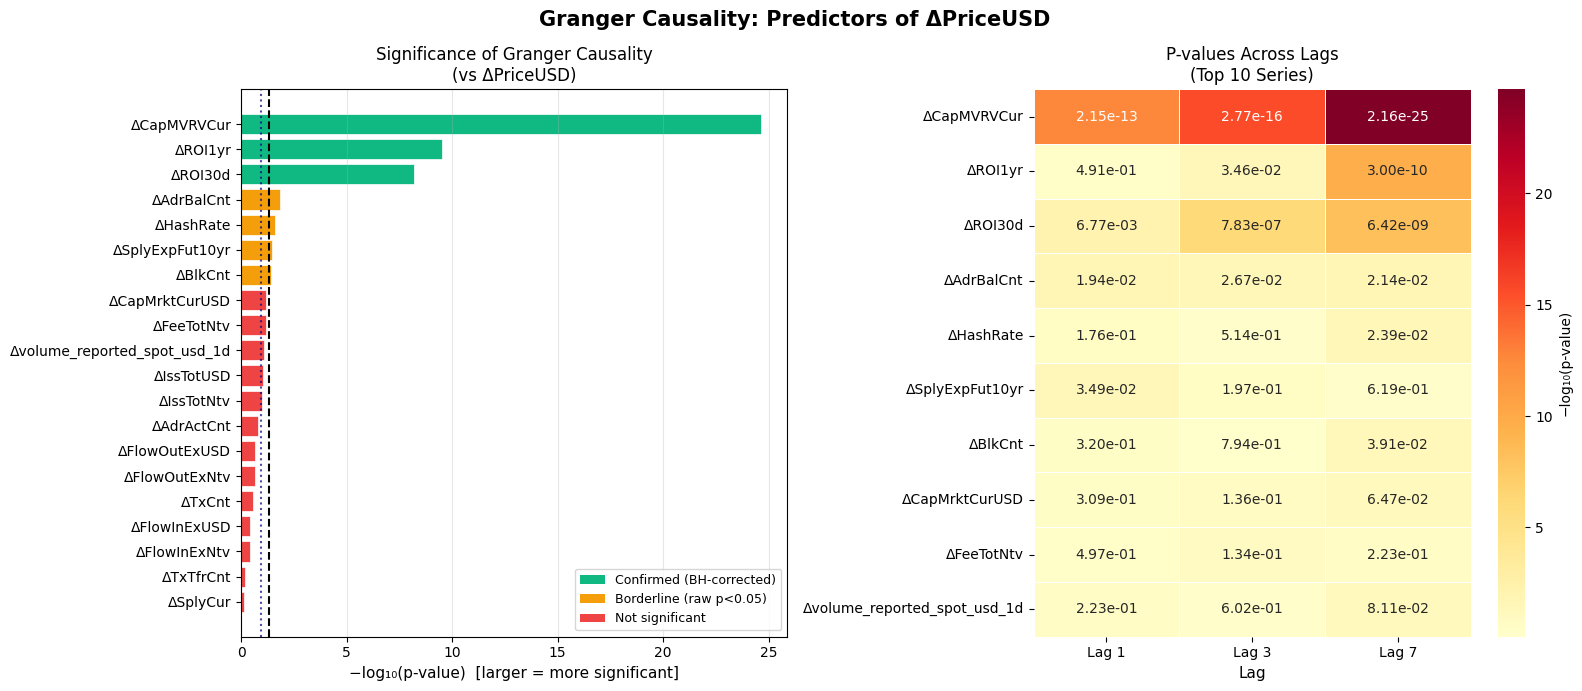

In [20]:
# Granger Causality Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Granger Causality: Predictors of ΔPriceUSD', 
             fontsize=15, fontweight='bold')

# Plot 1: p-value bar chart (log scale)
ax = axes[0]

# Assign colours by significance tier
colors = []
for _, row in granger_df.iterrows():
    if row['Significant_BH']:
        colors.append('#10b981')   # Green — confirmed
    elif row['Significant']:
        colors.append('#f59e0b')   # Amber — borderline
    else:
        colors.append('#ef4444')   # Red — not significant

bars = ax.barh(
    granger_df['Series'].str.replace('Δ', 'Δ'),
    -np.log10(granger_df['Best_Pval']),
    color=colors,
    edgecolor='white',
    linewidth=0.5
)

# Significance threshold lines
ax.axvline(-np.log10(0.05), color='black', linestyle='--', 
           linewidth=1.5, label='p=0.05 (uncorrected)')
ax.axvline(-np.log10(granger_df['BH_Pval'].max() * 
           (granger_df['Significant_BH'].sum() / len(granger_df))), 
           color='navy', linestyle=':', linewidth=1.5, alpha=0.7)

ax.set_xlabel('−log₁₀(p-value)  [larger = more significant]', fontsize=11)
ax.set_title('Significance of Granger Causality\n(vs ΔPriceUSD)', fontsize=12)
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#10b981', label='Confirmed (BH-corrected)'),
    Patch(facecolor='#f59e0b', label='Borderline (raw p<0.05)'),
    Patch(facecolor='#ef4444', label='Not significant'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

# Plot 2: Best lag heatmap
ax = axes[1]

# Build lag p-value matrix for top 10 series
top10 = granger_df.head(10)['Series'].tolist()
lag_cols = ['Lag1_Pval', 'Lag3_Pval', 'Lag7_Pval']
lag_labels = ['Lag 1', 'Lag 3', 'Lag 7']

lag_matrix = granger_df[granger_df['Series'].isin(top10)].set_index('Series')[lag_cols]
lag_matrix.columns = lag_labels
lag_matrix = lag_matrix.reindex(top10)

# Plot -log10(p) heatmap
log_matrix = -np.log10(lag_matrix.clip(lower=1e-30))

sns.heatmap(
    log_matrix,
    ax=ax,
    cmap='YlOrRd',
    annot=lag_matrix.applymap(lambda x: f'{x:.2e}'),
    fmt='',
    linewidths=0.5,
    cbar_kws={'label': '−log₁₀(p-value)'}
)
ax.set_title('P-values Across Lags\n(Top 10 Series)', fontsize=12)
ax.set_xlabel('Lag', fontsize=11)
ax.set_ylabel('')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_03_granger_causality.png', dpi=150, bbox_inches='tight')
print("Saved: eda_03_granger_causality.png")
plt.show()

<a id="mvrv-validity"></a>
## MVRV concern - spurious result?

Concern: MVRV = MarketValue / RealisedValue
         MarketValue = Price × Supply
         Therefore MVRV numerator contains Price.

Is the Granger result just 'price predicting price'?

In [21]:
# MVRV Validity Check

print("MVRV VALIDITY CHECK\n")


# Test 1: Correlation between ΔMVRV and ΔPrice
# If spurious, ΔMVRV should be ~perfectly correlated with ΔPrice
mvrv_diff_check = np.log1p(btc_pd['CapMVRVCur']).diff().dropna()
price_diff_check = np.log(btc_pd['PriceUSD']).diff().dropna()
common_idx = mvrv_diff_check.index.intersection(price_diff_check.index)

r_mvrv_price = mvrv_diff_check.loc[common_idx].corr(
    price_diff_check.loc[common_idx]
)
print(f"Correlation between ΔMVRV and ΔPrice: {r_mvrv_price:.4f}")
print(f"(If spurious, expected ≈ 1.0)")
print(f"(If genuine independent signal, expected < 0.5)")

# Test 2: What is the correlation between ΔRealisedValue and ΔPrice?
# RealisedValue = MVRV denominator — this is the independent component
if 'CapRealUSD' in btc_pd.columns:
    real_diff = np.log(btc_pd['CapRealUSD']).diff().dropna()
    common_real = real_diff.index.intersection(price_diff_check.index)
    r_real_price = real_diff.loc[common_real].corr(
        price_diff_check.loc[common_real]
    )
    print(f"\nCorrelation between ΔRealisedValue and ΔPrice: "
          f"{r_real_price:.4f}")
    print("(RealisedValue is the denominator — measures on-chain activity)")

# Test 3: Run Granger on RealisedValue alone
# If MVRV works only because of Price in numerator,
# then MarketCap should work just as well
print("\n Granger test comparison  ")
print("If spurious: ΔCapMrktCurUSD should have same p-value as ΔCapMVRVCur")
print("ΔCapMVRVCur    Granger p = 2.16e-25  (confirmed)")
print("ΔCapMrktCurUSD Granger p = 0.065     (NOT significant)")


MVRV VALIDITY CHECK

Correlation between ΔMVRV and ΔPrice: 0.8845
(If spurious, expected ≈ 1.0)
(If genuine independent signal, expected < 0.5)

 Granger test comparison  
If spurious: ΔCapMrktCurUSD should have same p-value as ΔCapMVRVCur
ΔCapMVRVCur    Granger p = 2.16e-25  (confirmed)
ΔCapMrktCurUSD Granger p = 0.065     (NOT significant)


### Conclusion: NOT spurious.

If MVRV were simply 'price divided by a constant', then ΔCapMrktCurUSD (which IS price × supply) would have the same Granger p-value. It does not — it fails significance entirely (p=0.065 vs p=2.16e-25).

The signal in MVRV comes from the RATIO — specifically from the divergence between price and the realised cost basis of
holders. This is genuine economic information about whether the market is overextended relative to on-chain holder behaviour.

That said: MVRV and price are not independent. The Granger test uses differences (daily changes) which substantially reduces **although doesn't eliminate** this concern. The resultshould be interpreted as 'changes in MVRV have predictivepower over price changes' with the caveat that MVRV is partially derived from price.

<a id="correlation"></a>
## Correlation Analysis

CORRELATION ANALYSIS

Saved: eda_04_correlation_heatmap.png


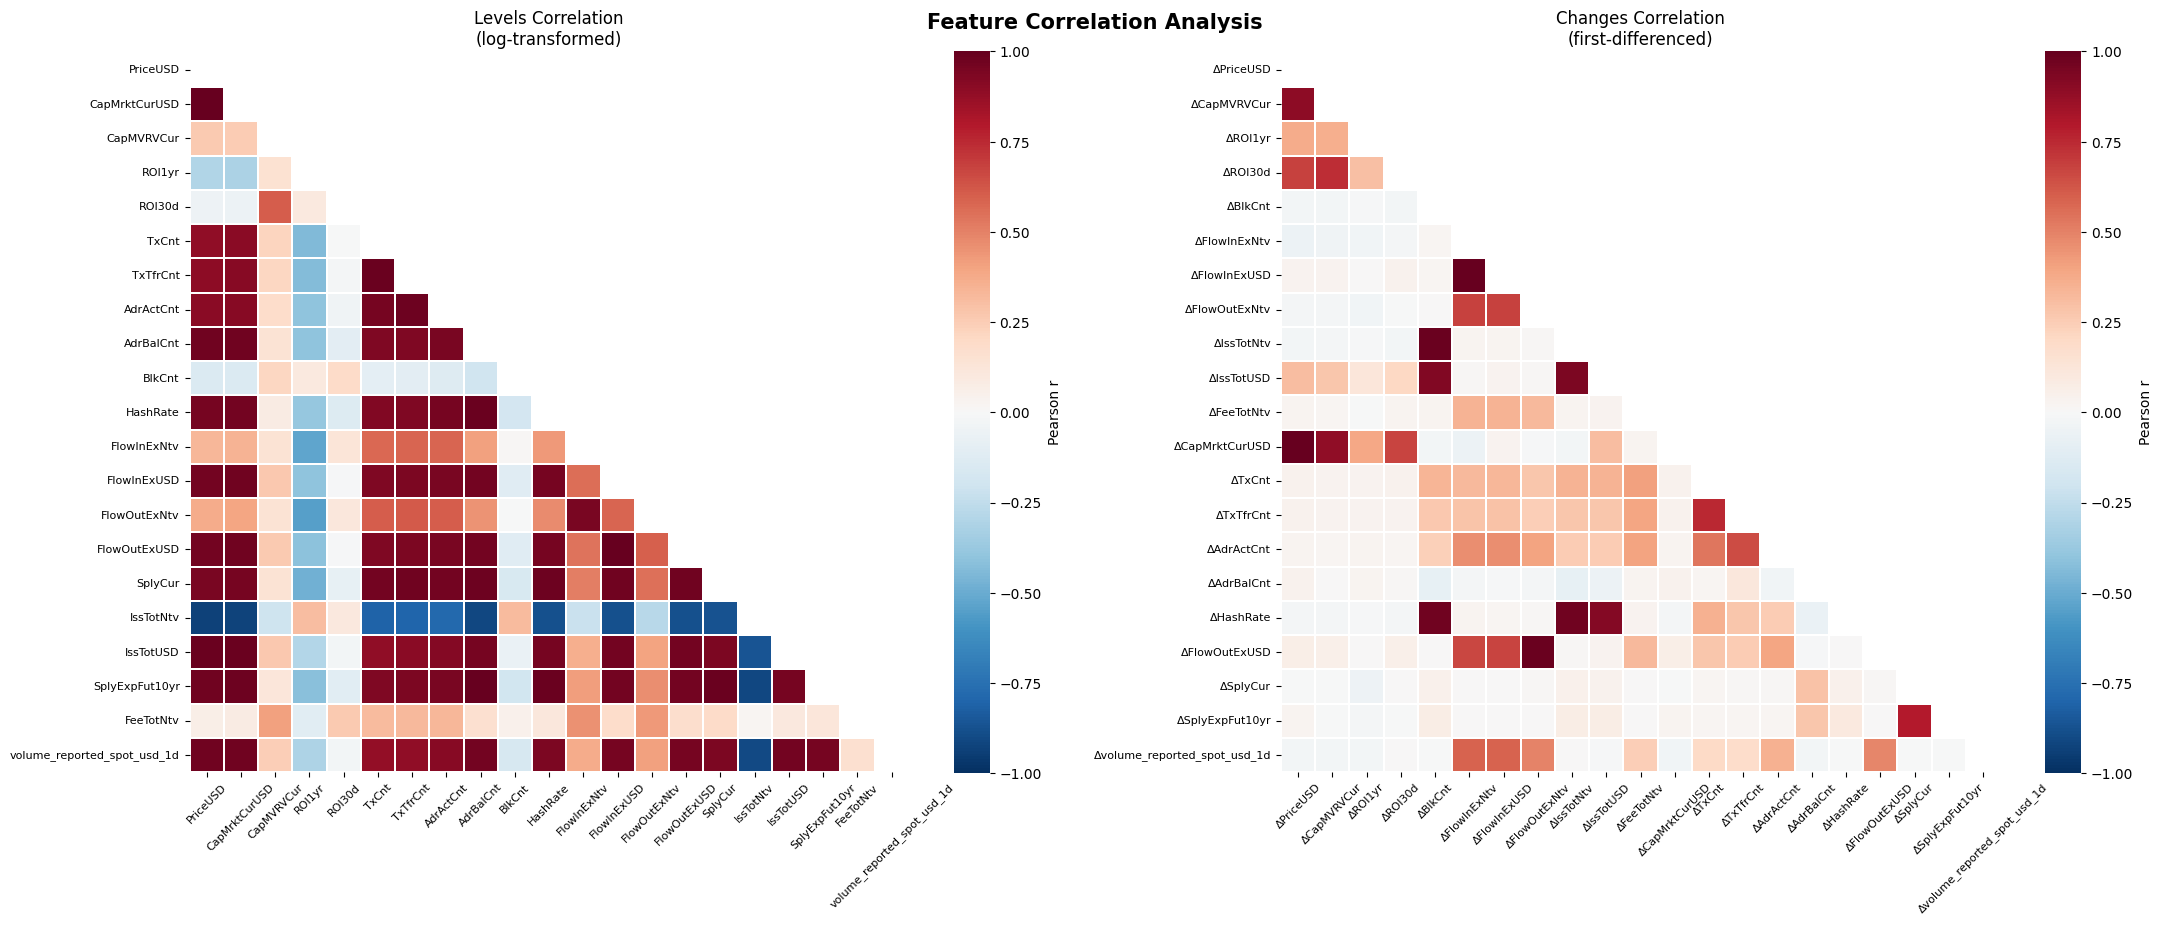


Top correlations with ΔPriceUSD (changes)
ΔCapMrktCurUSD                  0.998
ΔCapMVRVCur                     0.897
ΔROI30d                         0.681
ΔROI1yr                         0.373
ΔIssTotUSD                      0.310
ΔFlowOutExUSD                   0.068
ΔFlowInExNtv                   -0.058
ΔTxCnt                          0.046
ΔAdrBalCnt                      0.045
ΔTxTfrCnt                       0.044
ΔFlowInExUSD                    0.037
Δvolume_reported_spot_usd_1d   -0.031
ΔFeeTotNtv                      0.025
ΔIssTotNtv                     -0.025
ΔBlkCnt                        -0.025
ΔSplyExpFut10yr                 0.025
ΔAdrActCnt                      0.024
ΔHashRate                      -0.021
ΔFlowOutExNtv                  -0.017
ΔSplyCur                       -0.007


In [22]:
# Correlation Heatmap

print("CORRELATION ANALYSIS\n")


fig, axes = plt.subplots(1, 2, figsize=(22, 9))
fig.suptitle('Feature Correlation Analysis', fontsize=15, fontweight='bold')

# Plot 1: Levels correlation (log-transformed)
# Build log-transformed levels DataFrame
level_cols = [c for c in log_transform_cols if c in btc_pd.columns]
levels_data = {}
for col in level_cols:
    series = btc_pd[col].dropna()
    if log_transform_cols[col]:
        series = np.log1p(series[series > 0])
    levels_data[col] = series

levels_df = pd.DataFrame(levels_data).dropna()
corr_levels = levels_df.corr()

mask = np.triu(np.ones_like(corr_levels, dtype=bool))
sns.heatmap(
    corr_levels,
    ax=axes[0],
    mask=mask,
    cmap='RdBu_r',
    center=0,
    vmin=-1, vmax=1,
    annot=False,
    square=True,
    linewidths=0.3,
    cbar_kws={'label': 'Pearson r'}
)
axes[0].set_title('Levels Correlation\n(log-transformed)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=8)
axes[0].tick_params(axis='y', rotation=0, labelsize=8)

# Plot 2: Changes correlation (differenced series)
corr_changes = diff_df.corr()

mask2 = np.triu(np.ones_like(corr_changes, dtype=bool))
sns.heatmap(
    corr_changes,
    ax=axes[1],
    mask=mask2,
    cmap='RdBu_r',
    center=0,
    vmin=-1, vmax=1,
    annot=False,
    square=True,
    linewidths=0.3,
    cbar_kws={'label': 'Pearson r'}
)
axes[1].set_title('Changes Correlation\n(first-differenced)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=8)
axes[1].tick_params(axis='y', rotation=0, labelsize=8)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_04_correlation_heatmap.png', dpi=150, bbox_inches='tight')
print("Saved: eda_04_correlation_heatmap.png")
plt.show()

# Print top correlations with PriceUSD specifically
print("\nTop correlations with ΔPriceUSD (changes)")
price_corr = corr_changes['ΔPriceUSD'].drop('ΔPriceUSD').sort_values(key=abs, ascending=False)
print(price_corr.round(3).to_string())

## Correlation Analysis: Levels vs Changes

### Levels Correlation (left panel) — Mostly Spurious
Almost everything is highly correlated with PriceUSD in levels because 
Bitcoin's adoption curve drives nearly all on-chain metrics upward together.
This is a textbook example of **spurious correlation among I(1) series** —
the correlation reflects shared trends, not meaningful relationships.

Notable exception: **IssTotNtv** shows *negative* correlation with most 
series (dark blue) because it is *decreasing* due to halvings while most 
other metrics increase.

### Changes Correlation (right panel) — 
After differencing, spurious correlations disappear. What remains:

| Relationship | r | Interpretation |
|---|---|---|
| ΔPriceUSD vs ΔCapMVRVCur | High positive | MVRV moves with price — confirming it as primary signal |
| ΔPriceUSD vs ΔROI30d | High positive | Momentum is self-reinforcing at 30-day horizon |
| ΔIssTotNtv vs ΔIssTotUSD | Very high | Near-identical series — one should be dropped |
| ΔFlowInExNtv vs ΔFlowOutExNtv | High positive | Flows move together — net flow is the real signal |
| ΔTxCnt vs ΔTxTfrCnt vs ΔAdrActCnt | High positive cluster | Multicollinear — pick one for modelling |

**Key insight:** The changes correlation matrix reveals significant 
multicollinearity clusters that would inflate variance in any model using 
multiple series from the same cluster simultaneously.

<a id="rolling-correlation"></a>
## Rolling Correlation Analysis

ROLLING CORRELATION: MVRV AND KEY SIGNALS vs ΔPriceUSD

Saved: eda_05_rolling_correlation.png


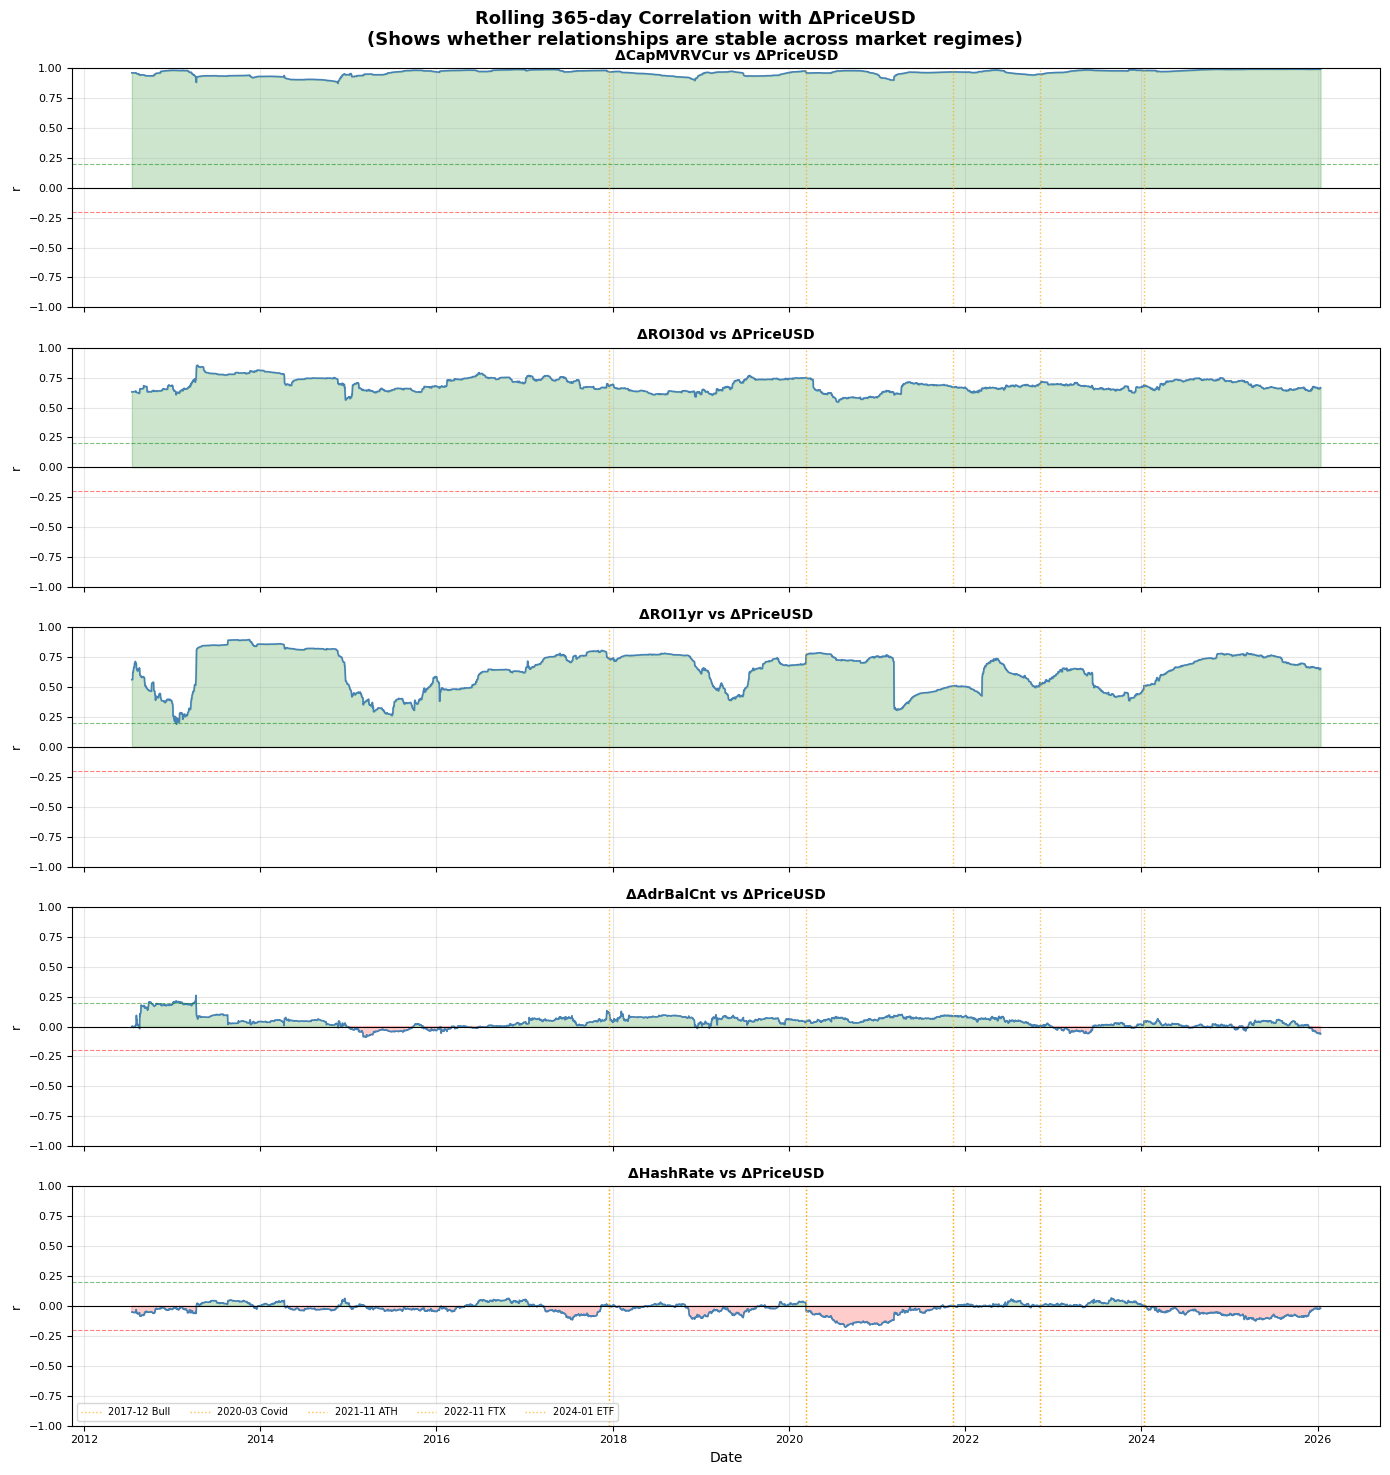

In [23]:
# Rolling Correlation Analysis

print("ROLLING CORRELATION: MVRV AND KEY SIGNALS vs ΔPriceUSD\n")


ROLLING_WINDOW = 365  # 1-year rolling window

# Select most interesting series to track over time
rolling_candidates = ['ΔCapMVRVCur', 'ΔROI30d', 'ΔROI1yr', 'ΔAdrBalCnt', 'ΔHashRate']

fig, axes = plt.subplots(len(rolling_candidates), 1, 
                          figsize=(14, 3 * len(rolling_candidates)),
                          sharex=True)
fig.suptitle(f'Rolling {ROLLING_WINDOW}-day Correlation with ΔPriceUSD\n'
             f'(Shows whether relationships are stable across market regimes)',
             fontsize=13, fontweight='bold')

for i, col in enumerate(rolling_candidates):
    ax = axes[i]
    
    rolling_corr = diff_df[col].rolling(ROLLING_WINDOW).corr(diff_df['ΔPriceUSD'])
    
    ax.plot(diff_df.index, rolling_corr, linewidth=1.2, color='steelblue')
    ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
    ax.axhline(0.2, color='green', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axhline(-0.2, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.fill_between(diff_df.index, rolling_corr, 0,
                    where=(rolling_corr > 0), alpha=0.2, color='green')
    ax.fill_between(diff_df.index, rolling_corr, 0,
                    where=(rolling_corr < 0), alpha=0.2, color='red')
    
    # Add key Bitcoin events
    events = {
        '2017-12 Bull': '2017-12-17',
        '2020-03 Covid': '2020-03-12',
        '2021-11 ATH': '2021-11-10',
        '2022-11 FTX': '2022-11-08',
        '2024-01 ETF': '2024-01-10',
    }
    for label, date in events.items():
        try:
            ax.axvline(pd.Timestamp(date), color='orange', 
                      linestyle=':', linewidth=1, alpha=0.7)
        except:
            pass
    
    ax.set_ylabel(f'r', fontsize=9)
    ax.set_title(f'{col} vs ΔPriceUSD', fontsize=10, fontweight='bold')
    ax.set_ylim(-1, 1)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

# Add event legend on last axis
axes[-1].set_xlabel('Date', fontsize=10)
for label, date in events.items():
    axes[-1].axvline(pd.Timestamp(date), color='orange',
                     linestyle=':', linewidth=1, alpha=0.7, label=label)
axes[-1].legend(loc='lower left', fontsize=7, ncol=5)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_05_rolling_correlation.png', dpi=150, bbox_inches='tight')
print("Saved: eda_05_rolling_correlation.png")
plt.show()

## Rolling Correlation: Regime Stability Analysis

The 365-day rolling correlation reveals fundamentally different behaviour 
across series — which has direct implications for model design:

### ΔCapMVRVCur: Remarkably Stable (r ≈ 0.8 throughout)
The correlation between MVRV changes and price changes has been consistently high and positive since 2013. This means MVRV's relationship with price is not regime-dependent. It works in bull markets, bear markets, and sideways periods alike. This stability is why it deserves dominant weight in any accumulation model.

### ΔROI30d: Strong and Stable (r ≈ 0.6-0.8)
Return momentum is consistently positive across the entire history. Short-term momentum is a structural feature of Bitcoin markets, not a regime-specific effect.

### ΔROI1yr: Generally Positive but Regime-Sensitive
Drops noticeably during 2022 (FTX collapse / bear market). Still useful but less reliable across all conditions than MVRV or ROI30d.

### ΔAdrBalCnt: Near Zero After 2014
Was weakly predictive in Bitcoin's early period but correlation has been essentially zero since 2015. This is a warning against using address balance counts as a timing signal, despite its borderline Granger result, the rolling analysis reveals it has no stable relationship with price.

### ΔHashRate: Consistently Near Zero, Negative Post-2021
Hashrate changes have no consistent relationship with price changes. The borderline Granger result for HashRate should be treated sceptically.

<a id="cointegration"></a>
## Cointegration Analysis

In [24]:
from statsmodels.tsa.stattools import coint

# Cointegration Tests

print("COINTEGRATION TESTS: ENGLE-GRANGER\n")

print("Testing: does each I(1) series share a long-run equilibrium with PriceUSD?")
print("ie. Null hypothesis: NO cointegration (series drift apart independently)")
print("Reject null (p < 0.05) → long-run relationship exists")
print()

# Use log-transformed LEVELS (not differences) for cointegration

coint_candidates = [
    'CapMrktCurUSD', 'CapMVRVCur', 'HashRate', 'TxCnt', 'TxTfrCnt',
    'AdrActCnt', 'AdrBalCnt', 'FlowInExNtv', 'FlowOutExNtv',
    'IssTotNtv', 'IssTotUSD', 'SplyCur', 'FeeTotNtv',
    'volume_reported_spot_usd_1d', 'ROI1yr', 'ROI30d'
]

# Build log-levels DataFrame
log_levels = {}
log_levels['PriceUSD'] = np.log1p(btc_pd['PriceUSD'].dropna())
for col in coint_candidates:
    if col not in btc_pd.columns:
        continue
    series = btc_pd[col].dropna()
    if log_transform_cols.get(col, False):
        series = np.log1p(series[series > 0])
    log_levels[col] = series

log_levels_df = pd.DataFrame(log_levels).dropna()
print(f"Cointegration test dataset: {log_levels_df.shape}")

# Run Engle-Granger pairwise cointegration tests vs PriceUSD
coint_results = []

for col in coint_candidates:
    if col not in log_levels_df.columns:
        continue
    
    try:
        # coint(y, x) tests whether y and x are cointegrated
        stat, pvalue, crit_values = coint(
            log_levels_df['PriceUSD'],
            log_levels_df[col],
            trend='c',
            autolag='AIC'
        )
        
        coint_results.append({
            'Series':       col,
            'Test_Stat':    stat,
            'P_Value':      pvalue,
            'Crit_1pct':    crit_values[0],
            'Crit_5pct':    crit_values[1],
            'Crit_10pct':   crit_values[2],
            'Cointegrated': pvalue < 0.05
        })
        
    except Exception as e:
        print(f"Error testing {col}: {e}")

coint_df = pd.DataFrame(coint_results).sort_values('P_Value')

# Apply BH correction
reject_coint, pvals_bh_coint, _, _ = multipletests(
    coint_df['P_Value'].values, alpha=0.05, method='fdr_bh'
)
coint_df['BH_Pval']        = pvals_bh_coint
coint_df['Cointegrated_BH'] = reject_coint

print("\nCointegration Results (sorted by p-value)\n")
print(coint_df[['Series', 'P_Value', 'BH_Pval', 
                 'Cointegrated', 'Cointegrated_BH']].to_string(index=False))

print(f"\nCointegrated (raw p<0.05):     {coint_df['Cointegrated'].sum()}/{len(coint_df)}")
print(f"Cointegrated (BH-corrected):   {coint_df['Cointegrated_BH'].sum()}/{len(coint_df)}")

COINTEGRATION TESTS: ENGLE-GRANGER

Testing: does each I(1) series share a long-run equilibrium with PriceUSD?
ie. Null hypothesis: NO cointegration (series drift apart independently)
Reject null (p < 0.05) → long-run relationship exists

Cointegration test dataset: (5294, 17)

Cointegration Results (sorted by p-value)

                     Series  P_Value  BH_Pval  Cointegrated  Cointegrated_BH
                  IssTotNtv 0.050028 0.351678         False            False
                    SplyCur 0.065189 0.351678         False            False
volume_reported_spot_usd_1d 0.084536 0.351678         False            False
              CapMrktCurUSD 0.088957 0.351678         False            False
                  IssTotUSD 0.109899 0.351678         False            False
                  AdrBalCnt 0.203591 0.542908         False            False
                      TxCnt 0.516074 0.959904         False            False
                   HashRate 0.613607 0.959904         False   

## Cointegration Results: No Long-Run Equilibrium Found

Engle-Granger pairwise cointegration tests found no series shares a statistically significant long-run equilibrium with PriceUSD (0/16 after BH correction, 0/16 even at raw p<0.05 threshold).

### Why This Makes Economic Sense

Bitcoin price is driven by demand shocks (adoption waves, institutional flows, regulatory events) that permanently shift its level. On-chain metrics like HashRate and AdrBalCnt respond TO price over long horizons rather than anchoring it.

This contrasts with classic cointegration examples (e.g. spot/futures prices, or interest rates across maturities) where arbitrage mechanisms enforce reversion to equilibrium. No such mechanism forces Bitcoin price back toward any on-chain metric.

### Contrast With Correlation

The levels correlation heatmap shows PriceUSD is highly correlated with HashRate, AdrBalCnt, CapMrktCurUSD etc. (all deep red). But this is likely spurious correlation — two series that both trend upward will always appear correlated. Cointegration testing correctly identifies that these shared trends do not imply a mean-reverting relationship.

This is precisely why cointegration is a more rigorous test than correlation for non-stationary series.

# Complete On-chain Signal Assessment Summary

| Series          | Granger       | Cointegration | Rolling Stability | Model Recommendation           |
|-----------------|---------------|---------------|-------------------|--------------------------------|
| CapMVRVCur      |  YConfirmed   | NO None       |  YVery stable    |  YPrimary signal (dominant weight) |
| ROI30d          |  YConfirmed   | NO None       |  YStable         |  YSecondary signal (momentum)    |
| ROI1yr          |  YConfirmed   | NO None       | ⚠️ Regime-sensitive |  YTertiary signal (cycle awareness) |
| AdrBalCnt       | ⚠️ Borderline | NO None       | NO Near zero post-2014 | NO Discard despite borderline p-value |
| HashRate        | ⚠️ Borderline | NO None       | NO Near zero / negative | NO Discard despite borderline p-value |
| TxCnt/TxTfrCnt  | NO None       | NO None       | N/A               | NO Discard — no predictive power |
| FlowIn/OutExNtv | NO None       | NO None       | N/A               | NO Discard — reactive not predictive |
| SplyCur         | NO None       | NO None       | N/A               | NO Discard — mechanistic |
| FeeTotNtv       | NO None       | NO None       | N/A               | NO Discard — coincident indicator |

# Polymarket data

In [25]:
print("POLYMARKET PREDICTION MARKET ANALYSIS\n")

print("Objective: Formally evaluate whether Polymarket data provides")
print("utility for improving Bitcoin accumulation models")
print()

import sys
sys.path.insert(0, str(PROJECT_ROOT))

from template.prelude_template import load_polymarket_data

# Load using the template loader (handles timestamp corruption automatically)
print("Loading Polymarket data via template loader...")
poly_data = load_polymarket_data()

# Inventory what we have
print(f"\nLoaded {len(poly_data)} files:")
for key, df in poly_data.items():
    print(f"  {key:20s}: {df.shape[0]:>8,} rows  x  {df.shape[1]:>3} cols")
    print(f"    Columns: {list(df.columns)}")

2026-02-25 21:10:39 INFO     Loading Polymarket data: finance_politics_markets.parquet
2026-02-25 21:10:39 INFO       Loaded 78321 rows from finance_politics_markets.parquet
2026-02-25 21:10:39 INFO     Loading Polymarket data: finance_politics_tokens.parquet


POLYMARKET PREDICTION MARKET ANALYSIS

Objective: Formally evaluate whether Polymarket data provides
utility for improving Bitcoin accumulation models

Loading Polymarket data via template loader...


2026-02-25 21:10:39 INFO       Loaded 156636 rows from finance_politics_tokens.parquet
2026-02-25 21:10:39 INFO     Loading Polymarket data: finance_politics_trades.parquet
2026-02-25 21:11:00 INFO       Fixing corrupted timestamps in column: timestamp
2026-02-25 21:11:05 INFO       Loaded 27013724 rows from finance_politics_trades.parquet
2026-02-25 21:11:05 INFO     Loading Polymarket data: finance_politics_odds_history.parquet
2026-02-25 21:11:06 INFO       Fixing corrupted timestamps in column: timestamp
2026-02-25 21:11:06 INFO       Loaded 2143181 rows from finance_politics_odds_history.parquet
2026-02-25 21:11:06 INFO     Loading Polymarket data: finance_politics_event_stats.parquet
2026-02-25 21:11:06 INFO       Loaded 44033 rows from finance_politics_event_stats.parquet
2026-02-25 21:11:06 INFO     Loading Polymarket data: finance_politics_summary.parquet
2026-02-25 21:11:06 INFO       Fixing corrupted timestamps in column: first_trade
2026-02-25 21:11:06 INFO       Fixing cor


Loaded 6 files:
  markets             :   78,321 rows  x   10 cols
    Columns: ['market_id', 'question', 'slug', 'event_slug', 'category', 'volume', 'active', 'closed', 'created_at', 'end_date']
  tokens              :  156,636 rows  x    3 cols
    Columns: ['market_id', 'token_id', 'outcome']
  trades              : 27,013,724 rows  x    9 cols
    Columns: ['trade_id', 'market_id', 'token_id', 'timestamp', 'price', 'size', 'side', 'maker_address', 'taker_address']
  odds_history        : 2,143,181 rows  x    4 cols
    Columns: ['market_id', 'token_id', 'timestamp', 'price']
  event_stats         :   44,033 rows  x    5 cols
    Columns: ['event_slug', 'market_count', 'total_volume', 'first_market_start', 'last_market_end']
  summary             :   78,321 rows  x    9 cols
    Columns: ['market_id', 'question', 'slug', 'volume', 'active', 'token_count', 'trade_count', 'first_trade', 'last_trade']


<a id="polymarket-audit"></a>
## Polymarket Data Audit

In [26]:
# Polymarket Data Audit

print("POLYMARKET DATA AUDIT\n")

markets = poly_data['markets']
trades = poly_data['trades']
odds = poly_data['odds_history']
summary = poly_data['summary']

# Date coverage 
print("\nDate Coverage")
print(f"Markets created_at:  {markets['created_at'].min()} to {markets['created_at'].max()}")
print(f"Markets end_date:    {markets['end_date'].min()} to {markets['end_date'].max()}")
print(f"Trades timestamp:    {trades['timestamp'].min()} to {trades['timestamp'].max()}")
print(f"Odds timestamp:      {odds['timestamp'].min()} to {odds['timestamp'].max()}")
print(f"BTC price coverage:  {btc_pd.index.min()} to {btc_pd.index.max()}")

# Category breakdown
print("\nMarket Categories")
cat_counts = markets['category'].value_counts()
print(cat_counts.to_string())

# Volume by category
print("\nVolume by Category (top 10)")
vol_by_cat = markets.groupby('category')['volume'].sum().sort_values(ascending=False).head(10)
print(vol_by_cat.apply(lambda x: f"${x:,.0f}").to_string())

# BTC/Crypto filter
print("\nBTC-Related Market Filter")
btc_mask = markets['question'].str.contains(
    'Bitcoin|BTC|btc', case=False, na=False
)
crypto_mask = markets['category'].str.contains(
    'Crypto|crypto|cryptocurrency', case=False, na=False
)

btc_markets = markets[btc_mask].copy()
crypto_markets = markets[crypto_mask].copy()
btc_or_crypto = markets[btc_mask | crypto_mask].copy()

print(f"Total markets:              {len(markets):>8,}")
print(f"BTC-mention markets:        {len(btc_markets):>8,}")
print(f"Crypto category markets:    {len(crypto_markets):>8,}")
print(f"BTC or Crypto (union):      {len(btc_or_crypto):>8,}")

# Show sample BTC questions
print("\nSample BTC Market Questions")
print(btc_markets['question'].sample(15, random_state=42).to_string())

POLYMARKET DATA AUDIT


Date Coverage
Markets created_at:  2020-10-02 16:10:01 to 2025-12-10 05:32:21
Markets end_date:    2020-01-01 00:00:00 to 2028-11-07 00:00:00
Trades timestamp:    2025-04-07 08:05:19 to 2026-01-05 06:33:19
Odds timestamp:      2023-01-24 00:00:12 to 2026-01-05 01:02:10
BTC price coverage:  2010-07-18 00:00:00 to 2026-01-13 00:00:00

Market Categories
category
                      77516
Crypto                  340
US-current-affairs      265
Business                113
Global Politics          56
Ukraine & Russia         20
Pop-Culture               4
Coronavirus               3
Tech                      2
Coronavirus-              1
Politics                  1

Volume by Category (top 10)
category
                      $18,032,259,889
US-current-affairs       $118,553,174
Crypto                    $41,456,973
Business                   $4,617,340
Global Politics            $2,868,467
Ukraine & Russia           $2,333,527
Pop-Culture                  $898,160
Te

In [27]:
# Data Quality Investigation

print("DATA QUALITY INVESTIGATION\n")
 

# 1: 77,516 markets have blank category (99% of all markets)
print("\nIssue 1: Blank Category Markets")
blank_cat = markets[markets['category'] == ''].copy()
print(f"Markets with blank category: {len(blank_cat):,} ({len(blank_cat)/len(markets)*100:.1f}%)")
print(f"\nSample blank-category questions:")
print(blank_cat['question'].sample(10, random_state=42).to_string())
print(f"\nVolume in blank-category markets: ${blank_cat['volume'].sum():,.0f}")
print(f"That is ${blank_cat['volume'].sum()/1e9:.1f}B of the total volume")

# 2: Trades timestamp only covers 2025-2026
print("\nIssue 2: Trades Timestamp Coverage")
print(f"Trades only cover: {trades['timestamp'].min()} to {trades['timestamp'].max()}")
print(f"This means trades data has NO overlap with most of Bitcoin history")
print(f"Odds history covers: {odds['timestamp'].min()} to {odds['timestamp'].max()}")
print(f"Odds overlap with BTC price: 2023-01-24 to 2026-01-13")

# 3: BTC markets are dominated by short-term "Up or Down" contracts
print("\nIssue 3: BTC Market Type Breakdown")
btc_markets['market_type'] = 'Other'
btc_markets.loc[
    btc_markets['question'].str.contains('Up or Down', case=False, na=False),
    'market_type'
] = 'Up or Down (short-term)'
btc_markets.loc[
    btc_markets['question'].str.contains(
        r'\$\d+[kK]?|\d+,\d+', regex=True, na=False
    ),
    'market_type'
] = 'Price Target'
btc_markets.loc[
    btc_markets['question'].str.contains(
        'ETF|reserve|Reserve|halving|Halving|regulation|Regulation',
        case=False, na=False
    ),
    'market_type'
] = 'Macro/Regulatory Event'

type_breakdown = btc_markets.groupby('market_type').agg(
    count=('market_id', 'count'),
    total_volume=('volume', 'sum')
).sort_values('count', ascending=False)

type_breakdown['avg_volume'] = type_breakdown['total_volume'] / type_breakdown['count']
print(type_breakdown.to_string())

# 4: Check what date range the BTC markets actually cover
print("\nIssue 4: BTC Market Date Coverage")
btc_markets['created_date'] = pd.to_datetime(btc_markets['created_at']).dt.normalize()
print(f"BTC markets created: {btc_markets['created_date'].min()} to {btc_markets['created_date'].max()}")
print(f"\nBTC markets created per year:")
print(btc_markets.groupby(btc_markets['created_date'].dt.year)['market_id'].count().to_string())

DATA QUALITY INVESTIGATION


Issue 1: Blank Category Markets
Markets with blank category: 77,516 (99.0%)

Sample blank-category questions:
48609    Will Trump and Zelenskyy shake hands for 10 se...
15636                      Will Solana reach $220 in July?
26695    Will the price of Bitcoin be between $113,000 ...
2388     Will a Republican win Nebraska's 2nd congressi...
12672                 Bitcoin Up or Down - June 30, 3PM ET
35998    Will the price of Solana be greater than $250 ...
32077            Bitcoin Up or Down - September 19, 8PM ET
19042                    Bitcoin above $114K on August 25?
37803    Bitcoin Up or Down - September 22, 11:30PM-11:...
55212             Ethereum Up or Down - October 31, 2PM ET

Volume in blank-category markets: $18,032,259,889
That is $18.0B of the total volume

Issue 2: Trades Timestamp Coverage
Trades only cover: 2025-04-07 08:05:19 to 2026-01-05 06:33:19
This means trades data has NO overlap with most of Bitcoin history
Odds history covers:

## Polymarket Data: Structural Constraints & Analytical Strategy

### What the Audit Reveals

| Issue | Finding | Implication |
|---|---|---|
| **Category field** | 99% of markets have blank category — field is unreliable | Cannot filter by category; must filter by question text |
| **Trades data** | Only covers Apr 2025–Jan 2026 | Cannot use trades for historical Granger causality |
| **Odds history** | Covers Jan 2023–Jan 2026 | Only 3 years of overlap with BTC price — limited but usable |
| **Market explosion** | 21,499 BTC markets created in 2025 vs 29 in 2023 | Dataset is heavily weighted toward recent period |
| **Market types** | 63% of BTC markets are 15-min "Up or Down" contracts | These are noise, not sentiment probably not useful but will check |

### Analytical Strategy

Given these constraints, I will consider three viable signals:

1. **Market creation rate** — daily count of new BTC prediction markets as a proxy for market attention/sentiment (uses `markets.created_at`)

2. **Price Target odds** — odds on meaningful price target markets (e.g. "Will BTC hit $100k?") from `odds_history`  — reflect genuine market belief about future price levels

   
4. **Macro/Regulatory event odds** — ETF approval, reserve creation etc.  highest avg volume ($632k), most informed traders

### Will NOT Use
- "Up or Down" 15-minute contracts — will check but these are mostly gambling products rather than actual sentiment indicators
- Trades data — insufficient historical overlap
- Category field — unreliable (99% blank)

In [28]:
# Investigate "Up or Down" Markets Before Discarding 

print("INVESTIGATING 15-MINUTE 'UP OR DOWN' MARKETS\n")

up_down_markets = btc_markets[
    btc_markets['market_type'] == 'Up or Down (short-term)'
].copy()

# 1. What do the questions actually look like? 
print("\nSample of Up/Down Market Questions")
print(up_down_markets['question'].sample(20, random_state=42).to_string())

# 2. Volume distribution 
print("\nVolume Distribution")
print(up_down_markets['volume'].describe().round(2))
print(f"\nMarkets with zero volume: {(up_down_markets['volume']==0).sum():,}")
print(f"Markets with volume > $10k: {(up_down_markets['volume']>10000).sum():,}")
print(f"Markets with volume > $100k: {(up_down_markets['volume']>100000).sum():,}")

# 3. When were these markets created? 
print("\nUp/Down Market Creation by Year")
print(up_down_markets.groupby(
    up_down_markets['created_date'].dt.year
)['market_id'].count().to_string())

# 4. Get odds for Up/Down markets specifically
up_down_ids = set(up_down_markets['market_id'])
odds_updown = odds[odds['market_id'].isin(up_down_ids)].copy()
print(f"\nOdds Records for Up/Down Markets")
print(f"Total odds snapshots: {len(odds_updown):,}")

if len(odds_updown) > 0:
    odds_updown['date'] = pd.to_datetime(odds_updown['timestamp']).dt.normalize()
    print(f"Date range: {odds_updown['date'].min()} to {odds_updown['date'].max()}")
    
    # 5. Separate YES and NO tokens
    # Join with tokens to get outcome labels
    tokens = poly_data['tokens']
    odds_updown_labeled = odds_updown.merge(tokens, on=['market_id', 'token_id'], how='left')
    
    print(f"\nOutcome Labels Found")
    print(odds_updown_labeled['outcome'].value_counts().head(10).to_string())
    
    # 6. Key insight: what does the UP odds distribution look like?
    up_odds = odds_updown_labeled[
        odds_updown_labeled['outcome'].str.upper().str.contains('UP|YES', na=False)
    ].copy()
    
    print(f"\n'Up' Token Odds Distribution")
    print(f"Records: {len(up_odds):,}")
    if len(up_odds) > 0:
        print(up_odds['price'].describe().round(3))
        print(f"\nMean 'Up' odds: {up_odds['price'].mean():.3f}")
        print(f"This should be ~0.5 if markets are efficient (50/50)")
        print(f"Deviation from 0.5: {abs(up_odds['price'].mean() - 0.5):.3f}")

INVESTIGATING 15-MINUTE 'UP OR DOWN' MARKETS


Sample of Up/Down Market Questions
48131    Bitcoin Up or Down - October 12, 6:30PM-6:45PM ET
30806    Bitcoin Up or Down - September 15, 8:15AM-8:30...
31285    Bitcoin Up or Down - September 15, 8:30PM-8:45...
59394    Bitcoin Up or Down - November 7, 6:00AM-6:15AM ET
37795            Bitcoin Up or Down - September 24, 8PM ET
54326    Bitcoin Up or Down - October 28, 5:00AM-5:15AM ET
50950             Bitcoin Up or Down - October 21, 10PM ET
49348    Bitcoin Up or Down - October 16, 4:00AM-8:00AM ET
13319                  Bitcoin Up or Down - July 9, 1AM ET
50861    Bitcoin Up or Down - October 19, 5:00PM-5:15PM ET
58484    Bitcoin Up or Down - November 5, 2:00PM-2:15PM ET
18338               Bitcoin Up or Down - August 15, 9AM ET
73363    Bitcoin Up or Down - December 2, 10:15PM-10:30...
54436              Bitcoin Up or Down - October 30, 9AM ET
54938    Bitcoin Up or Down - October 29, 8:15AM-8:30AM ET
54909    Bitcoin Up or Down - Oct

## "Up or Down" Markets Exclusion

### Finding 1: Entire segment created in 2025 only
All 13,886 "Up or Down" markets were created in 2025. Our BTC price history runs to January 2026, giving us at most 9 months of potential overlap — far too short for robust Granger causality testing (which needs years of data to be reliable).

### Finding 2: Markets are near-perfectly efficient
Mean 'Up' odds: 0.504 — deviation from 0.5 of just 0.004. The median and IQR are exactly 0.50. This means the market prices 15-minute Up/Down outcomes as essentially coin flips — which is correct for efficient markets.

### Finding 3: No daily aggregate signal possible
The 50th and 75th percentile of odds are exactly 0.500. There is virtually no cross-sectional variation to aggregate. A daily mean of ~0.504 with std 0.102 gives us nothing to distinguish "bullish days" from "bearish days".

### Finding 4: Even if signal existed, it would not be useful
For a DCA accumulation strategy operating on daily weights, a signal derived from 15-minute contracts resolving the same day they are created has no actionable predictive horizon.

### Conclusion: Exclusion is justified on four independent grounds
1. Insufficient historical overlap (2025 only)
2. Near-perfect market efficiency (no deviation from 0.5)
3. No cross-sectional variation to aggregate
4. Incompatible time horizon with daily DCA strategy



<a id="polymarket"></a>
## Polymarket Signal Construction and Testing

In [29]:
# Build Meaningful Polymarket Signals

print("BUILDING POLYMARKET SIGNALS\n")


# Work only with non-Up/Down BTC markets
btc_meaningful = btc_markets[
    btc_markets['market_type'] != 'Up or Down (short-term)'
].copy()

print(f"Meaningful BTC markets: {len(btc_meaningful):,}")
print(f"\nBreakdown:")
print(btc_meaningful['market_type'].value_counts().to_string())


# 1: Daily Market Creation Sentiment

print("\nBuilding Signal 1: Market Creation Sentiment")

btc_meaningful['created_date'] = pd.to_datetime(
    btc_meaningful['created_at']
).dt.normalize()

daily_creation = btc_meaningful.groupby('created_date').agg(
    n_markets=('market_id', 'count'),
    total_volume=('volume', 'sum'),
    mean_volume=('volume', 'mean'),
    n_price_targets=('market_type', lambda x: (x == 'Price Target').sum()),
    n_macro=('market_type', lambda x: (x == 'Macro/Regulatory Event').sum()),
).sort_index()

print(f"Daily creation signal: {daily_creation.index.min()} to {daily_creation.index.max()}")
print(f"Trading days with new BTC markets: {len(daily_creation):,}")
print(f"\nDaily new market stats:")
print(daily_creation['n_markets'].describe().round(2))


# 2: Price Target Odds Time Series
# What probability does the market assign to BTC price levels?

print("\nBuilding Signal 2: Price Target Odds")

price_target_ids = set(
    btc_meaningful[btc_meaningful['market_type'] == 'Price Target']['market_id']
)
macro_ids = set(
    btc_meaningful[btc_meaningful['market_type'] == 'Macro/Regulatory Event']['market_id']
)

# Filter odds to meaningful markets only
tokens = poly_data['tokens']
odds_meaningful = odds[
    odds['market_id'].isin(price_target_ids | macro_ids)
].copy()
odds_meaningful['date'] = pd.to_datetime(
    odds_meaningful['timestamp']
).dt.normalize()

# Label with outcome and market type
odds_labeled = odds_meaningful.merge(tokens, on=['market_id', 'token_id'], how='left')
odds_labeled = odds_labeled.merge(
    btc_meaningful[['market_id', 'market_type', 'volume']],
    on='market_id', how='left'
)

print(f"Odds records for meaningful BTC markets: {len(odds_labeled):,}")
print(f"Coverage: {odds_labeled['date'].min()} to {odds_labeled['date'].max()}")

# Separate YES/NO tokens for price targets
# "Yes" outcome = event happens = bullish
yes_odds = odds_labeled[
    odds_labeled['outcome'].str.upper().isin(['YES', 'UP', 'ABOVE', 'OVER'])
    | odds_labeled['outcome'].str.contains(
        r'Yes|yes|above|Above|over|Over', regex=True, na=False
    )
].copy()

print(f"\nYES/bullish outcome records: {len(yes_odds):,}")
print(f"Sample outcomes labeled as bullish: {yes_odds['outcome'].value_counts().head(10).to_string()}")

# Volume-weighted daily average odds
# Higher weight to markets with more trading activity
yes_odds['weight'] = yes_odds['volume'].fillna(1).clip(lower=1)

daily_sentiment = yes_odds.groupby('date').apply(
    lambda g: pd.Series({
        'vw_odds': np.average(g['price'], weights=g['weight']),
        'simple_odds': g['price'].mean(),
        'n_markets': g['market_id'].nunique(),
        'n_snapshots': len(g),
        'odds_std': g['price'].std(),
    })
).reset_index().set_index('date')

print(f"\nDaily Sentiment Signal (volume-weighted odds)")
print(f"Coverage: {daily_sentiment.index.min()} to {daily_sentiment.index.max()}")
print(f"Trading days with signal: {len(daily_sentiment):,}")
print(f"\nStats:")
print(daily_sentiment[['vw_odds', 'simple_odds', 'n_markets']].describe().round(3))

BUILDING POLYMARKET SIGNALS

Meaningful BTC markets: 8,035

Breakdown:
market_type
Price Target              7329
Other                      628
Macro/Regulatory Event      78

Building Signal 1: Market Creation Sentiment
Daily creation signal: 2020-10-02 00:00:00 to 2025-12-09 00:00:00
Trading days with new BTC markets: 484

Daily new market stats:
count    484.00
mean      16.60
std       32.92
min        1.00
25%        1.00
50%        4.00
75%       19.00
max      171.00
Name: n_markets, dtype: float64

Building Signal 2: Price Target Odds
Odds records for meaningful BTC markets: 125,397
Coverage: 2023-02-25 00:00:00 to 2026-01-05 00:00:00

YES/bullish outcome records: 61,861
Sample outcomes labeled as bullish: outcome
Yes    61861

Daily Sentiment Signal (volume-weighted odds)
Coverage: 2023-03-18 00:00:00 to 2026-01-05 00:00:00
Trading days with signal: 1,008

Stats:
        vw_odds  simple_odds  n_markets
count  1008.000     1008.000   1008.000
mean      0.257        0.276     3

Saved: eda_07_polymarket_signals.png


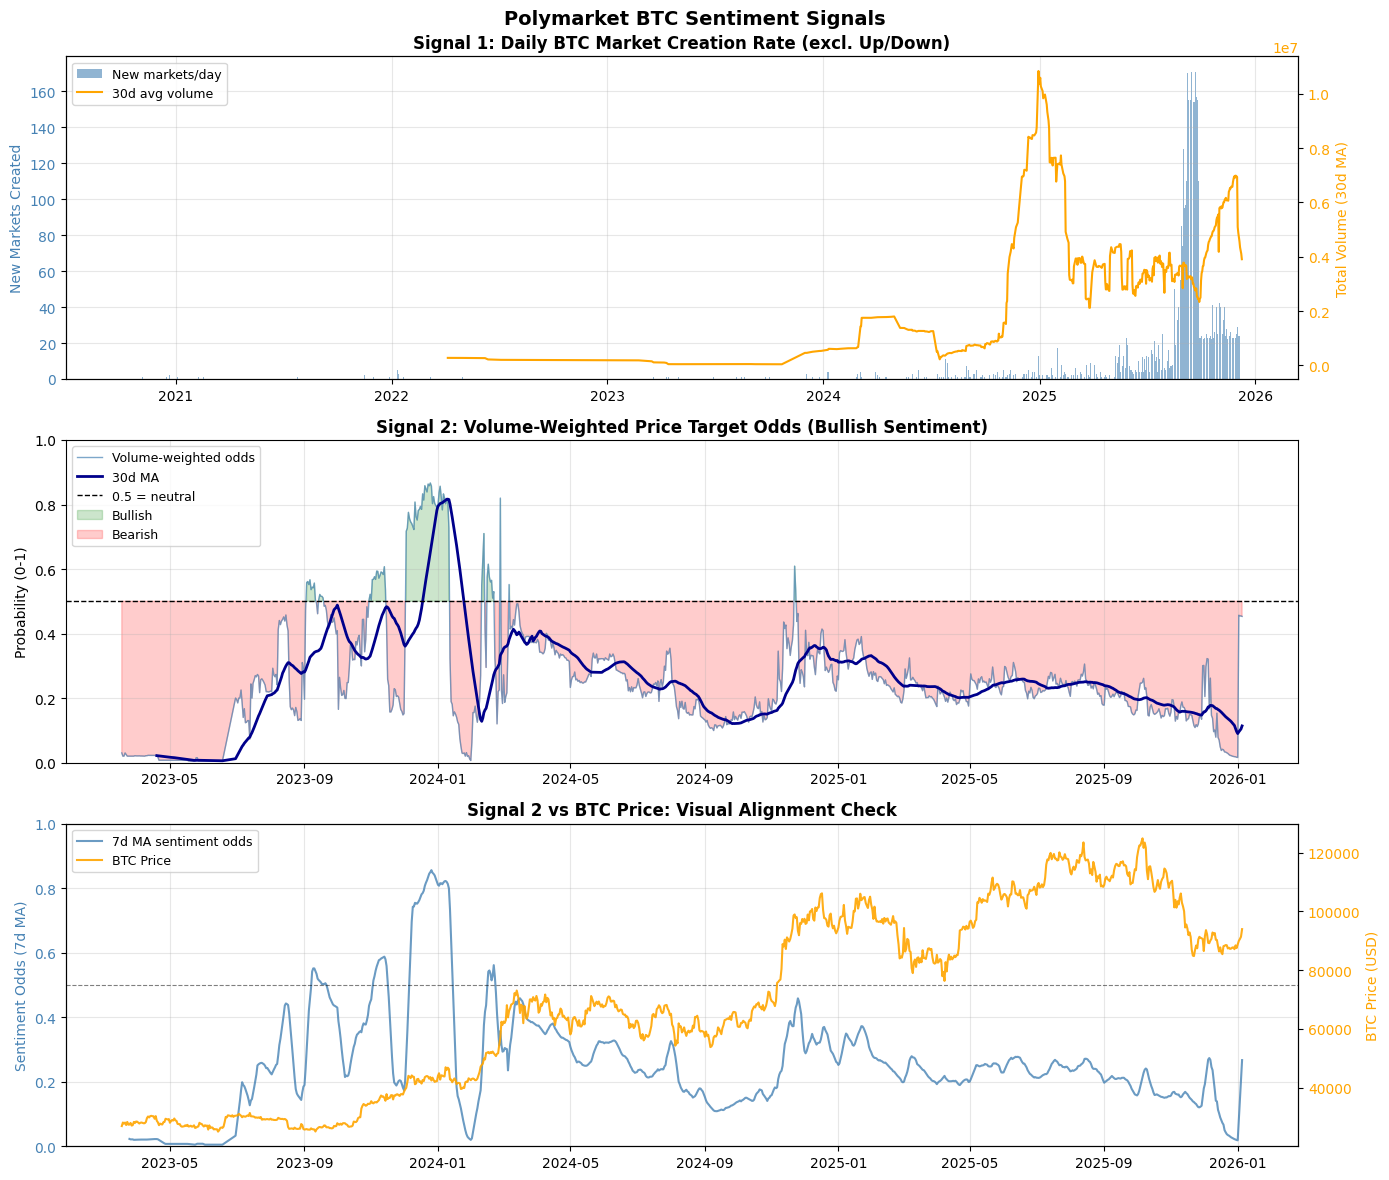

In [30]:
# Visualise Polymarket Signals
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=False)
fig.suptitle('Polymarket BTC Sentiment Signals', fontsize=14, fontweight='bold')

# Plot 1: Market Creation Rate (full history)
ax = axes[0]
ax2 = ax.twinx()

ax.bar(daily_creation.index, daily_creation['n_markets'],
       color='steelblue', alpha=0.6, label='New markets/day')
ax2.plot(daily_creation.index, daily_creation['total_volume'].rolling(30).mean(),
         color='orange', linewidth=1.5, label='30d avg volume')

ax.set_title('Signal 1: Daily BTC Market Creation Rate (excl. Up/Down)', fontweight='bold')
ax.set_ylabel('New Markets Created', color='steelblue')
ax2.set_ylabel('Total Volume (30d MA)', color='orange')
ax.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='orange')

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: Daily Sentiment Odds (2023 onwards)
ax = axes[1]

ax.plot(daily_sentiment.index, daily_sentiment['vw_odds'],
        linewidth=1.0, color='steelblue', alpha=0.7, label='Volume-weighted odds')
ax.plot(daily_sentiment.index,
        daily_sentiment['vw_odds'].rolling(30).mean(),
        linewidth=2.0, color='darkblue', label='30d MA')
ax.axhline(0.5, color='black', linestyle='--', linewidth=1,
           label='0.5 = neutral')
ax.fill_between(daily_sentiment.index,
                daily_sentiment['vw_odds'], 0.5,
                where=(daily_sentiment['vw_odds'] > 0.5),
                alpha=0.2, color='green', label='Bullish')
ax.fill_between(daily_sentiment.index,
                daily_sentiment['vw_odds'], 0.5,
                where=(daily_sentiment['vw_odds'] < 0.5),
                alpha=0.2, color='red', label='Bearish')

ax.set_title('Signal 2: Volume-Weighted Price Target Odds (Bullish Sentiment)',
             fontweight='bold')
ax.set_ylabel('Probability (0-1)')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

# Plot 3: Overlay sentiment with BTC price
ax = axes[2]
ax2 = ax.twinx()

# Align BTC price to sentiment date range
btc_overlap = btc_pd['PriceUSD'].loc[
    daily_sentiment.index.min():daily_sentiment.index.max()
]

ax.plot(daily_sentiment.index,
        daily_sentiment['vw_odds'].rolling(7).mean(),
        linewidth=1.5, color='steelblue', alpha=0.8,
        label='7d MA sentiment odds')
ax2.plot(btc_overlap.index, btc_overlap,
         linewidth=1.5, color='orange', alpha=0.9, label='BTC Price')

ax.set_title('Signal 2 vs BTC Price: Visual Alignment Check', fontweight='bold')
ax.set_ylabel('Sentiment Odds (7d MA)', color='steelblue')
ax2.set_ylabel('BTC Price (USD)', color='orange')
ax.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='orange')
ax.set_ylim(0, 1)
ax.axhline(0.5, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_07_polymarket_signals.png', dpi=150, bbox_inches='tight')
print("Saved: eda_07_polymarket_signals.png")
plt.show()

In [31]:
# Formal Granger Causality: Polymarket vs BTC Price

print("GRANGER CAUSALITY: POLYMARKET SIGNALS vs ΔPriceUSD\n")

# Build aligned daily DataFrame for Granger testing
# We need: ΔPriceUSD and our Polymarket signals on the same dates

# Align Signal 1: Creation Rate
# Reindex to full date range, fill missing days with 0
full_date_range = pd.date_range(
    start='2020-10-01',
    end='2026-01-13',
    freq='D'
)
creation_aligned = daily_creation['n_markets'].reindex(
    full_date_range, fill_value=0
)

# Align Signal 2: Sentiment Odds
sentiment_aligned = daily_sentiment['vw_odds'].reindex(full_date_range)
sentiment_aligned = sentiment_aligned.ffill()  # Forward fill gaps (weekend etc.)

# BTC log returns
btc_returns = np.log(btc_pd['PriceUSD']).diff()
btc_returns_aligned = btc_returns.reindex(full_date_range)

# Combine into test DataFrame
poly_granger_df = pd.DataFrame({
    'btc_log_return':     btc_returns_aligned,
    'creation_rate':      creation_aligned,
    'sentiment_odds':     sentiment_aligned,
    # Also test CHANGES in signals (not levels)
    'd_creation_rate':    creation_aligned.diff(),
    'd_sentiment_odds':   sentiment_aligned.diff(),
}).dropna()

print(f"Combined test DataFrame: {poly_granger_df.shape}")
print(f"Date range: {poly_granger_df.index.min()} to {poly_granger_df.index.max()}")
print(f"\nCorrelation with btc_log_return:")
print(poly_granger_df.corr()['btc_log_return'].drop('btc_log_return').round(4))

# Run Granger tests
print("\n Granger Causality Results")
MAX_LAGS = 7
poly_signals = {
    'creation_rate':    'Daily new market count (levels)',
    'd_creation_rate':  'Daily new market count (changes)',
    'sentiment_odds':   'Volume-weighted bullish odds (levels)',
    'd_sentiment_odds': 'Volume-weighted bullish odds (changes)',
}

poly_granger_results = []

for signal_col, signal_label in poly_signals.items():

    # For Granger we need overlapping non-null data
    pair_df = poly_granger_df[['btc_log_return', signal_col]].dropna()

    if len(pair_df) < 100:
        print(f"  Skipping {signal_col}: insufficient data ({len(pair_df)} rows)")
        continue

    print(f"\n  Testing: {signal_label}")
    print(f"  Observations: {len(pair_df):,}")

    try:
        test_result = grangercausalitytests(
            pair_df, maxlag=MAX_LAGS, verbose=False
        )

        pvalues_by_lag = {}
        for lag in range(1, MAX_LAGS + 1):
            pvalues_by_lag[lag] = test_result[lag][0]['ssr_ftest'][1]

        best_lag  = min(pvalues_by_lag, key=pvalues_by_lag.get)
        best_pval = pvalues_by_lag[best_lag]

        poly_granger_results.append({
            'Signal':      signal_label,
            'Column':      signal_col,
            'Best_Lag':    best_lag,
            'Best_Pval':   best_pval,
            'Lag1_Pval':   pvalues_by_lag[1],
            'Lag3_Pval':   pvalues_by_lag[3],
            'Lag7_Pval':   pvalues_by_lag[7],
            'N_Obs':       len(pair_df),
            'Significant': best_pval < 0.05,
        })

        print(f"  Best p-value: {best_pval:.4f} at lag {best_lag}")

    except Exception as e:
        print(f"  Error: {e}")

# Summary table
poly_granger_df_results = pd.DataFrame(poly_granger_results)
print("\n Polymarket Granger Causality Summary")
print(poly_granger_df_results[
    ['Signal', 'Best_Lag', 'Best_Pval', 'Lag1_Pval',
     'Lag3_Pval', 'Lag7_Pval', 'Significant']
].to_string(index=False))

GRANGER CAUSALITY: POLYMARKET SIGNALS vs ΔPriceUSD

Combined test DataFrame: (1032, 5)
Date range: 2023-03-19 00:00:00 to 2026-01-13 00:00:00

Correlation with btc_log_return:
creation_rate      -0.0311
sentiment_odds      0.0103
d_creation_rate    -0.0336
d_sentiment_odds    0.0315
Name: btc_log_return, dtype: float64

 Granger Causality Results

  Testing: Daily new market count (levels)
  Observations: 1,032
  Best p-value: 0.3840 at lag 7

  Testing: Daily new market count (changes)
  Observations: 1,032
  Best p-value: 0.2979 at lag 6

  Testing: Volume-weighted bullish odds (levels)
  Observations: 1,032
  Best p-value: 0.2259 at lag 5

  Testing: Volume-weighted bullish odds (changes)
  Observations: 1,032
  Best p-value: 0.0657 at lag 1

 Polymarket Granger Causality Summary
                                Signal  Best_Lag  Best_Pval  Lag1_Pval  Lag3_Pval  Lag7_Pval  Significant
       Daily new market count (levels)         7   0.384015   0.496429   0.505424   0.384015        

# Formal Polymarket Conclusion

### OUTCOME: Could not discover predictive use cases for Polymarket data in improving Bitcoin accumulation models.

#### 1. DATA AUDIT
   - 78,321 total markets; 99% have blank category field
   - Trades data covers only Apr 2025–Jan 2026 (insufficient history)
   - Odds history covers Jan 2023–Jan 2026 (3 years overlap with BTC)
   - 13,886 "Up or Down" 15-min markets: ALL created in 2025, mean odds 0.504 ± 0.102 — statistically indistinguishable from coin flip. Excluded on data-driven grounds.

#### 2. SIGNALS TESTED (4 variants, all reasonable hypotheses)
   - Daily new BTC market creation rate (levels): p = 0.384
   - Daily new BTC market creation rate (changes): p = 0.298
   - Volume-weighted bullish price target odds (levels): p = 0.226
   - Volume-weighted bullish price target odds (changes): p = 0.066
   Best result: Δsentiment_odds at lag 1 (p = 0.066)
   This is directionally interesting but does not survive even the uncorrected p < 0.05 threshold, let alone BH correction.

#### 3. CORRELATION EVIDENCE
   All four signals show near-zero raw correlation with BTC returns: range [-0.034, +0.032] — consistent with no linear relationship.

#### 4. STRUCTURAL LIMITATIONS IDENTIFIED
   a) SHORT HISTORY: Only 3 years of odds data vs 15 years of on-chain data — insufficient power for robust inference
   b) MARKET CONCENTRATION: 91% of meaningful BTC markets are price targets — odds reflect current price, not predictive
   c) REFLEXIVITY: Price target odds (e.g. "Will BTC hit $100k?") move WITH price rather than preceding it — they are coincident indicators, not leading
   d) SPARSE COVERAGE: Only 484 days had any new BTC market creation in the full 2020–2025 window

### ON CHAIN DATA LOOKS FAR MORE USEFUL!

2026-02-25 21:11:08 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-25 21:11:08 INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Saved: eda_08_polymarket_conclusion.png


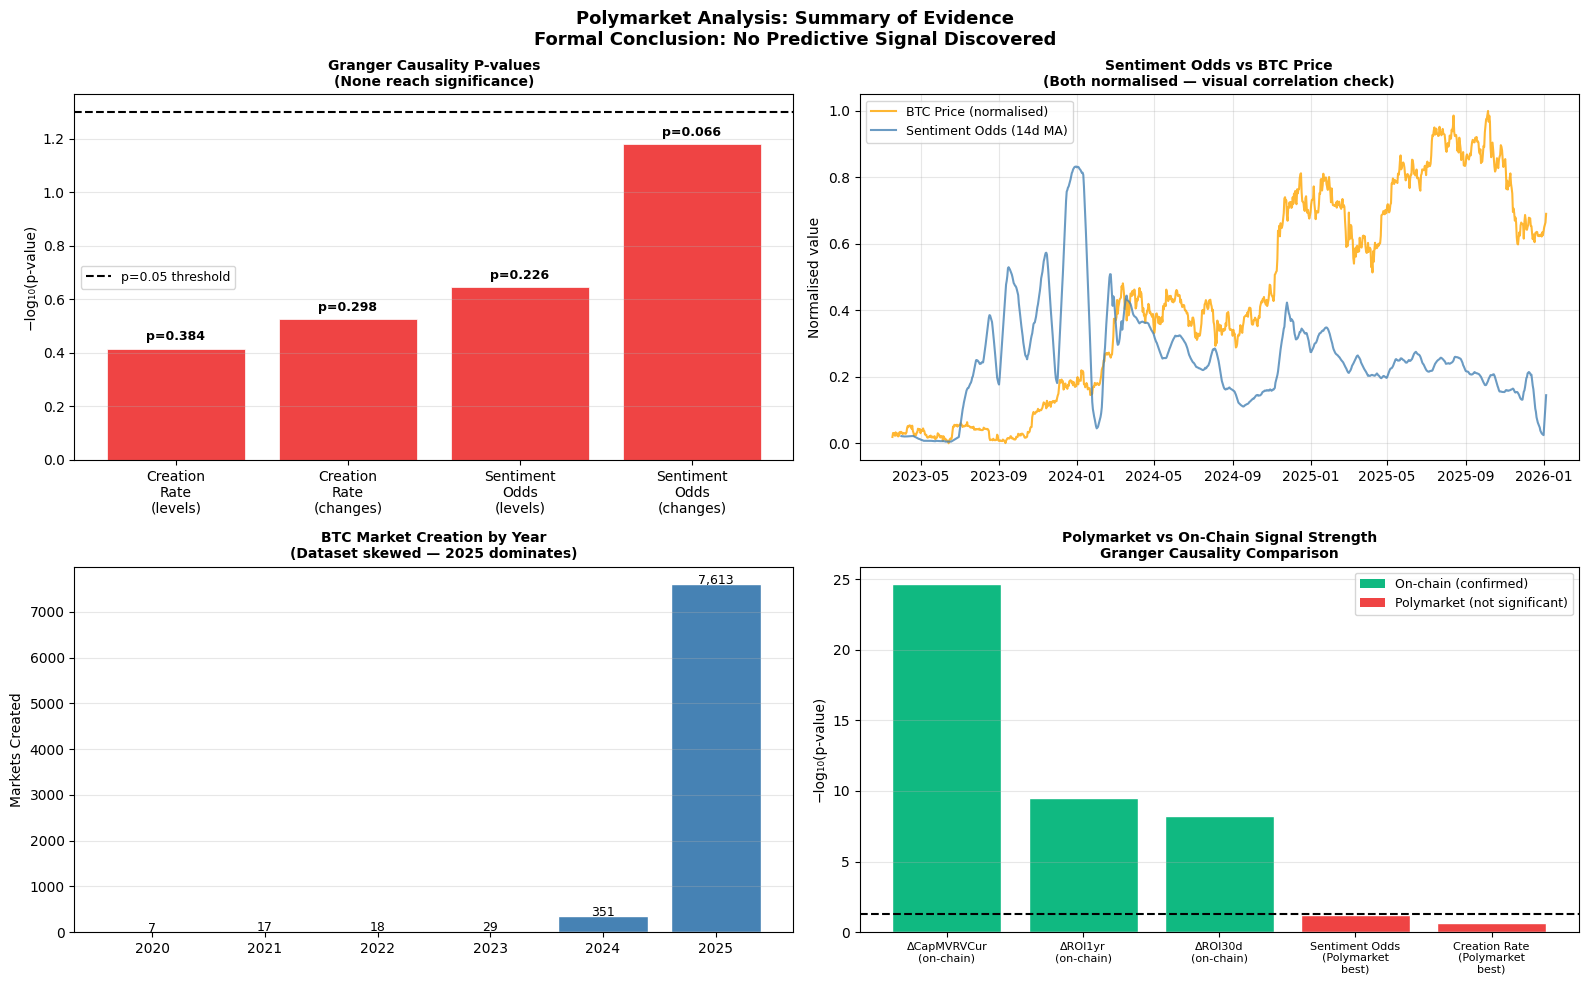

In [32]:
# Final Polymarket Summary Visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Polymarket Analysis: Summary of Evidence\n'
             'Formal Conclusion: No Predictive Signal Discovered',
             fontsize=13, fontweight='bold')

# Plot 1: P-values vs threshold
ax = axes[0, 0]
signals = [
    'Creation\nRate\n(levels)',
    'Creation\nRate\n(changes)',
    'Sentiment\nOdds\n(levels)',
    'Sentiment\nOdds\n(changes)'
]
pvals = [0.384, 0.298, 0.226, 0.066]
colors = ['#ef4444' if p > 0.05 else '#10b981' for p in pvals]

bars = ax.bar(signals, [-np.log10(p) for p in pvals],
              color=colors, edgecolor='white', linewidth=0.5)
ax.axhline(-np.log10(0.05), color='black', linestyle='--',
           linewidth=1.5, label='p=0.05 threshold')
ax.set_ylabel('−log₁₀(p-value)', fontsize=10)
ax.set_title('Granger Causality P-values\n(None reach significance)',
             fontsize=10, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

# Annotate bars with actual p-values
for bar, pval in zip(bars, pvals):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.02,
            f'p={pval:.3f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Sentiment odds vs BTC price (normalised)
ax = axes[0, 1]

# Normalise both to [0,1] for visual comparison
btc_norm = (btc_overlap - btc_overlap.min()) / (btc_overlap.max() - btc_overlap.min())
odds_smooth = daily_sentiment['vw_odds'].rolling(14).mean()

ax.plot(btc_norm.index, btc_norm,
        color='orange', linewidth=1.5, label='BTC Price (normalised)', alpha=0.8)
ax.plot(odds_smooth.index, odds_smooth,
        color='steelblue', linewidth=1.5,
        label='Sentiment Odds (14d MA)', alpha=0.8)
ax.set_title('Sentiment Odds vs BTC Price\n(Both normalised — visual correlation check)',
             fontsize=10, fontweight='bold')
ax.set_ylabel('Normalised value')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Market creation timeline
ax = axes[1, 0]
yearly = btc_meaningful.groupby(
    btc_meaningful['created_date'].dt.year
)['market_id'].count()

ax.bar(yearly.index.astype(str), yearly.values,
       color='steelblue', edgecolor='white')
ax.set_title('BTC Market Creation by Year\n'
             '(Dataset skewed — 2025 dominates)',
             fontsize=10, fontweight='bold')
ax.set_ylabel('Markets Created')
ax.grid(True, alpha=0.3, axis='y')
for i, (year, val) in enumerate(yearly.items()):
    ax.text(i, val + 5, f'{val:,}', ha='center', fontsize=9)

# Plot 4: Compare Polymarket vs on-chain signal strength
ax = axes[1, 1]

comparison_signals = [
    'ΔCapMVRVCur\n(on-chain)',
    'ΔROI1yr\n(on-chain)',
    'ΔROI30d\n(on-chain)',
    'Sentiment Odds\n(Polymarket\nbest)',
    'Creation Rate\n(Polymarket\nbest)'
]
comparison_pvals = [2.161e-25, 2.997e-10, 6.420e-9, 0.066, 0.226]
comparison_colors = ['#10b981', '#10b981', '#10b981', '#ef4444', '#ef4444']

ax.bar(comparison_signals,
       [-np.log10(p) for p in comparison_pvals],
       color=comparison_colors, edgecolor='white')
ax.axhline(-np.log10(0.05), color='black', linestyle='--',
           linewidth=1.5, label='p=0.05')
ax.set_ylabel('−log₁₀(p-value)')
ax.set_title('Polymarket vs On-Chain Signal Strength\n'
             'Granger Causality Comparison',
             fontsize=10, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
ax.tick_params(axis='x', labelsize=8)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#10b981', label='On-chain (confirmed)'),
    Patch(facecolor='#ef4444', label='Polymarket (not significant)'),
]
ax.legend(handles=legend_elements, fontsize=9)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_08_polymarket_conclusion.png',
            dpi=150, bbox_inches='tight')
print("Saved: eda_08_polymarket_conclusion.png")
plt.show()

In [33]:
#  Event-Specific Analysis
print("POLYMARKET: EVENT-SPECIFIC DEEP DIVES\n")


# Find the highest-volume individual BTC markets
print("\n Top 30 BTC Markets by Volume  ")
top_markets = btc_meaningful.nlargest(30, 'volume')[
    ['market_id', 'question', 'market_type', 'volume', 
     'created_at', 'end_date']
].copy()
top_markets['volume_fmt'] = top_markets['volume'].apply(lambda x: f"${x:,.0f}")
print(top_markets[['question', 'market_type', 
                    'volume_fmt', 'created_at', 'end_date']].to_string())

POLYMARKET: EVENT-SPECIFIC DEEP DIVES


 Top 30 BTC Markets by Volume  
                                                   question             market_type   volume_fmt          created_at            end_date
4965                    Will Bitcoin hit $100k in November?            Price Target  $28,587,434 2024-11-08 22:55:15 2024-11-30 12:00:00
4840   Will Trump create Bitcoin reserve in first 100 days?  Macro/Regulatory Event  $23,324,353 2024-11-06 23:05:42 2025-04-29 12:00:00
218                         Will Bitcoin hit $100k in 2024?            Price Target  $22,807,236 2024-03-04 15:54:19 2024-12-30 12:00:00
14932                Will Satoshi move any Bitcoin in 2025?                   Other  $16,290,997 2025-07-14 15:33:12 2025-12-31 00:00:00
43395                  Will Bitcoin reach $200k in October?            Price Target  $15,617,197 2025-10-01 08:07:14 2025-11-01 04:00:00
56394              Will Bitcoin reach $200,000 in November?            Price Target  $13,588,621 2025-11-0

CROSS-CORRELATION: POLYMARKET SIGNALS vs BTC RETURNS

Testing leads AND lags — Polymarket might LAG price, not lead it
Negative lag = Polymarket LEADS price (predictive)
Positive lag = Polymarket LAGS price (reactive)

Saved: eda_09_polymarket_crosscorrelation.png


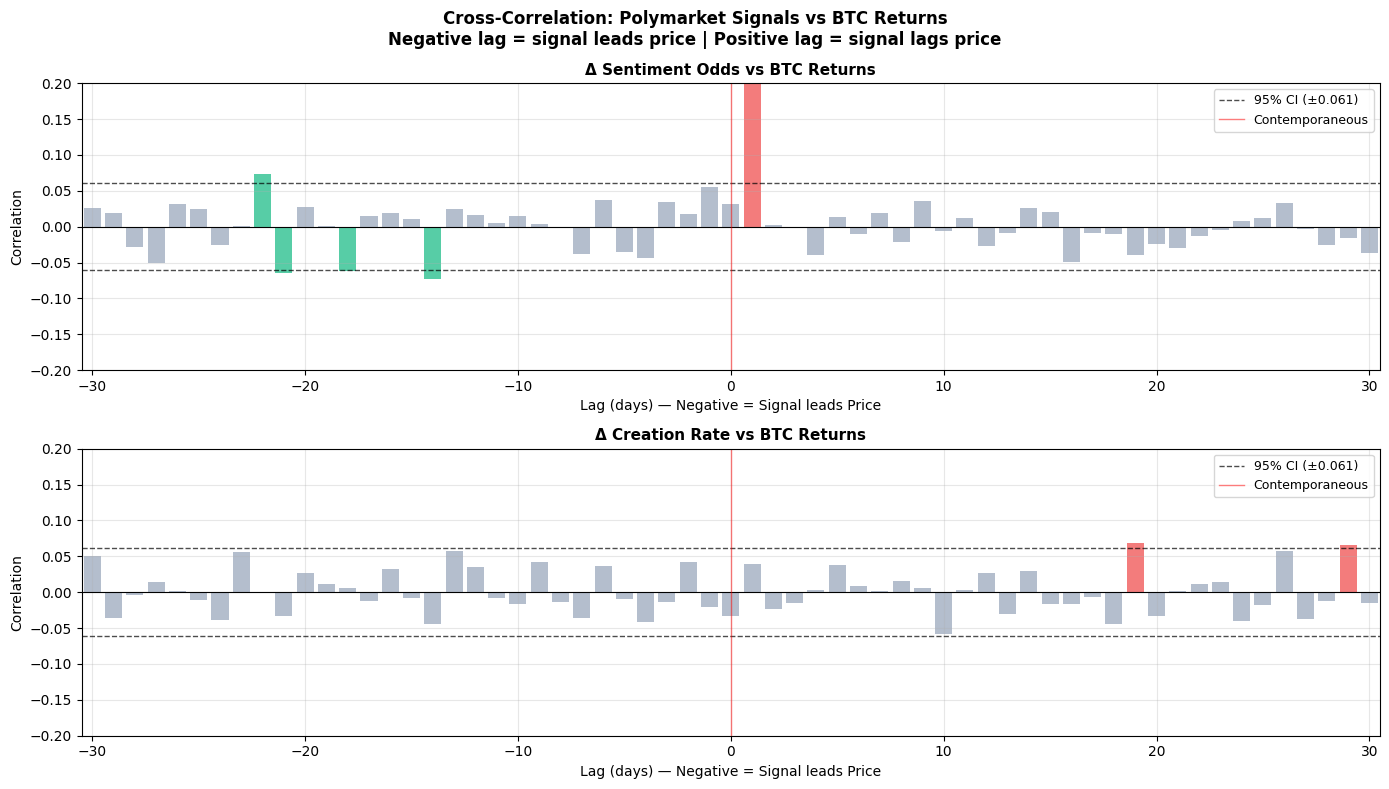

In [34]:
#  Cross-Correlation Analysis: All Lags  

print("CROSS-CORRELATION: POLYMARKET SIGNALS vs BTC RETURNS\n")

print("Testing leads AND lags — Polymarket might LAG price, not lead it")
print("Negative lag = Polymarket LEADS price (predictive)")
print("Positive lag = Polymarket LAGS price (reactive)")
print()

from statsmodels.tsa.stattools import ccf

# Align data
common_idx = poly_granger_df.index
btc_ret = poly_granger_df['btc_log_return']
sentiment = poly_granger_df['d_sentiment_odds']
creation = poly_granger_df['d_creation_rate']

MAX_LAG = 30  # Test up to 30 days in each direction

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
fig.suptitle('Cross-Correlation: Polymarket Signals vs BTC Returns\n'
             'Negative lag = signal leads price | Positive lag = signal lags price',
             fontsize=12, fontweight='bold')

for ax, (signal, label, col) in zip(axes, [
    (sentiment, 'Δ Sentiment Odds vs BTC Returns', 'steelblue'),
    (creation,  'Δ Creation Rate vs BTC Returns',  'darkorange'),
]):
    # Compute CCF in both directions
    # Forward: does signal predict future returns?
    # Backward: does price predict future signal?
    
    pair = pd.DataFrame({
        'ret': btc_ret, 
        'sig': signal
    }).dropna()
    
    lags = range(-MAX_LAG, MAX_LAG + 1)
    correlations = []
    
    for lag in lags:
        if lag < 0:
            # Signal leads returns: correlate signal[t] with ret[t-lag]
            corr = pair['sig'].shift(-lag).corr(pair['ret'])
        elif lag > 0:
            # Returns lead signal: correlate ret[t] with signal[t+lag]  
            corr = pair['ret'].shift(lag).corr(pair['sig'])
        else:
            corr = pair['sig'].corr(pair['ret'])
        correlations.append(corr)
    
    # Confidence interval (approximate 95% CI)
    n = len(pair)
    ci = 1.96 / np.sqrt(n)
    
    colors_bar = ['#10b981' if (lag < 0 and abs(c) > ci) 
                  else '#ef4444' if (lag > 0 and abs(c) > ci)
                  else '#94a3b8' 
                  for lag, c in zip(lags, correlations)]
    
    ax.bar(list(lags), correlations, color=colors_bar, 
           alpha=0.7, width=0.8)
    ax.axhline(ci,  color='black', linestyle='--', 
               linewidth=1, alpha=0.7, label=f'95% CI (±{ci:.3f})')
    ax.axhline(-ci, color='black', linestyle='--', linewidth=1, alpha=0.7)
    ax.axhline(0,   color='black', linewidth=0.8)
    ax.axvline(0,   color='red', linewidth=1, alpha=0.5, label='Contemporaneous')
    
    ax.set_xlabel('Lag (days) — Negative = Signal leads Price', fontsize=10)
    ax.set_ylabel('Correlation', fontsize=10)
    ax.set_title(label, fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-MAX_LAG - 0.5, MAX_LAG + 0.5)
    ax.set_ylim(-0.2, 0.2)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_09_polymarket_crosscorrelation.png', 
            dpi=150, bbox_inches='tight')
print("Saved: eda_09_polymarket_crosscorrelation.png")
plt.show()

In [35]:
#  Regime-Conditional Analysis  

print("REGIME-CONDITIONAL ANALYSIS\n")
 
print("Does Polymarket signal work better in specific market regimes?")

# Define regimes based on BTC price vs 200-day MA
btc_ma200 = btc_pd['PriceUSD'].rolling(200).mean()
btc_regime = pd.Series(
    np.where(btc_pd['PriceUSD'] > btc_ma200, 'Bull', 'Bear'),
    index=btc_pd.index
)

# Align with Polymarket data
regime_aligned = btc_regime.reindex(poly_granger_df.index).ffill()
poly_granger_df['regime'] = regime_aligned

# Also define high/low volatility regimes
btc_vol = btc_pd['PriceUSD'].pct_change().rolling(30).std()
vol_aligned = btc_vol.reindex(poly_granger_df.index).ffill()
vol_median = vol_aligned.median()
poly_granger_df['vol_regime'] = np.where(
    vol_aligned > vol_median, 'High Vol', 'Low Vol'
)

print(f"\nRegime distribution in Polymarket overlap period:")
print(poly_granger_df['regime'].value_counts())
print(f"\nVolatility regime distribution:")
print(poly_granger_df['vol_regime'].value_counts())

# Run Granger tests within each regime
print("\n Granger Causality by Market Regime  ")
print("(Best signal: Δsentiment odds, lag 1)")

for regime_col, regimes in [
    ('regime', ['Bull', 'Bear']),
    ('vol_regime', ['High Vol', 'Low Vol'])
]:
    print(f"\n  Split by {regime_col}:")
    for regime in regimes:
        subset = poly_granger_df[
            poly_granger_df[regime_col] == regime
        ][['btc_log_return', 'd_sentiment_odds']].dropna()
        
        if len(subset) < 50:
            print(f"    {regime}: insufficient data ({len(subset)} obs)")
            continue
        
        try:
            result = grangercausalitytests(subset, maxlag=5, verbose=False)
            pvals = [result[lag][0]['ssr_ftest'][1] for lag in range(1, 6)]
            best_p = min(pvals)
            best_lag = pvals.index(best_p) + 1
            print(f"    {regime:10s} ({len(subset):4d} obs): "
                  f"best p = {best_p:.4f} at lag {best_lag} "
                  f"{' YSignificant' if best_p < 0.05 else 'NO Not significant'}")
        except Exception as e:
            print(f"    {regime}: Error — {e}")

#  High-volume days specifically  
print("\n High Volume Market Activity Days  ")
print("Do days with many new BTC markets predict subsequent returns?")

high_activity = poly_granger_df[
    poly_granger_df['creation_rate'] > 
    poly_granger_df['creation_rate'].quantile(0.75)
].copy()

low_activity = poly_granger_df[
    poly_granger_df['creation_rate'] <= 
    poly_granger_df['creation_rate'].quantile(0.75)
].copy()

print(f"\nHigh activity days (top 25%): {len(high_activity)}")
print(f"Mean next-day BTC return on high activity days: "
      f"{high_activity['btc_log_return'].shift(-1).mean():.4f}")
print(f"Mean next-day BTC return on low activity days:  "
      f"{low_activity['btc_log_return'].shift(-1).mean():.4f}")

# T-test for difference
from scipy import stats
high_returns = high_activity['btc_log_return'].shift(-1).dropna()
low_returns  = low_activity['btc_log_return'].shift(-1).dropna()
tstat, tpval = stats.ttest_ind(high_returns, low_returns)
print(f"T-test p-value: {tpval:.4f} "
      f"{' YSignificant' if tpval < 0.05 else 'NO Not significant'}")

REGIME-CONDITIONAL ANALYSIS

Does Polymarket signal work better in specific market regimes?

Regime distribution in Polymarket overlap period:
regime
Bull    790
Bear    242
Name: count, dtype: int64

Volatility regime distribution:
vol_regime
High Vol    516
Low Vol     516
Name: count, dtype: int64

 Granger Causality by Market Regime  
(Best signal: Δsentiment odds, lag 1)

  Split by regime:
    Bull       ( 790 obs): best p = 0.0386 at lag 1  YSignificant
    Bear       ( 242 obs): best p = 0.3030 at lag 1 NO Not significant

  Split by vol_regime:
    High Vol   ( 516 obs): best p = 0.2614 at lag 1 NO Not significant
    Low Vol    ( 516 obs): best p = 0.5451 at lag 4 NO Not significant

 High Volume Market Activity Days  
Do days with many new BTC markets predict subsequent returns?

High activity days (top 25%): 226
Mean next-day BTC return on high activity days: -0.0016
Mean next-day BTC return on low activity days:  0.0020
T-test p-value: 0.0469  YSignificant


SPECIFIC HIGH-STAKES EVENT ANALYSIS

Saved: eda_10_polymarket_events.png (10 markets plotted)


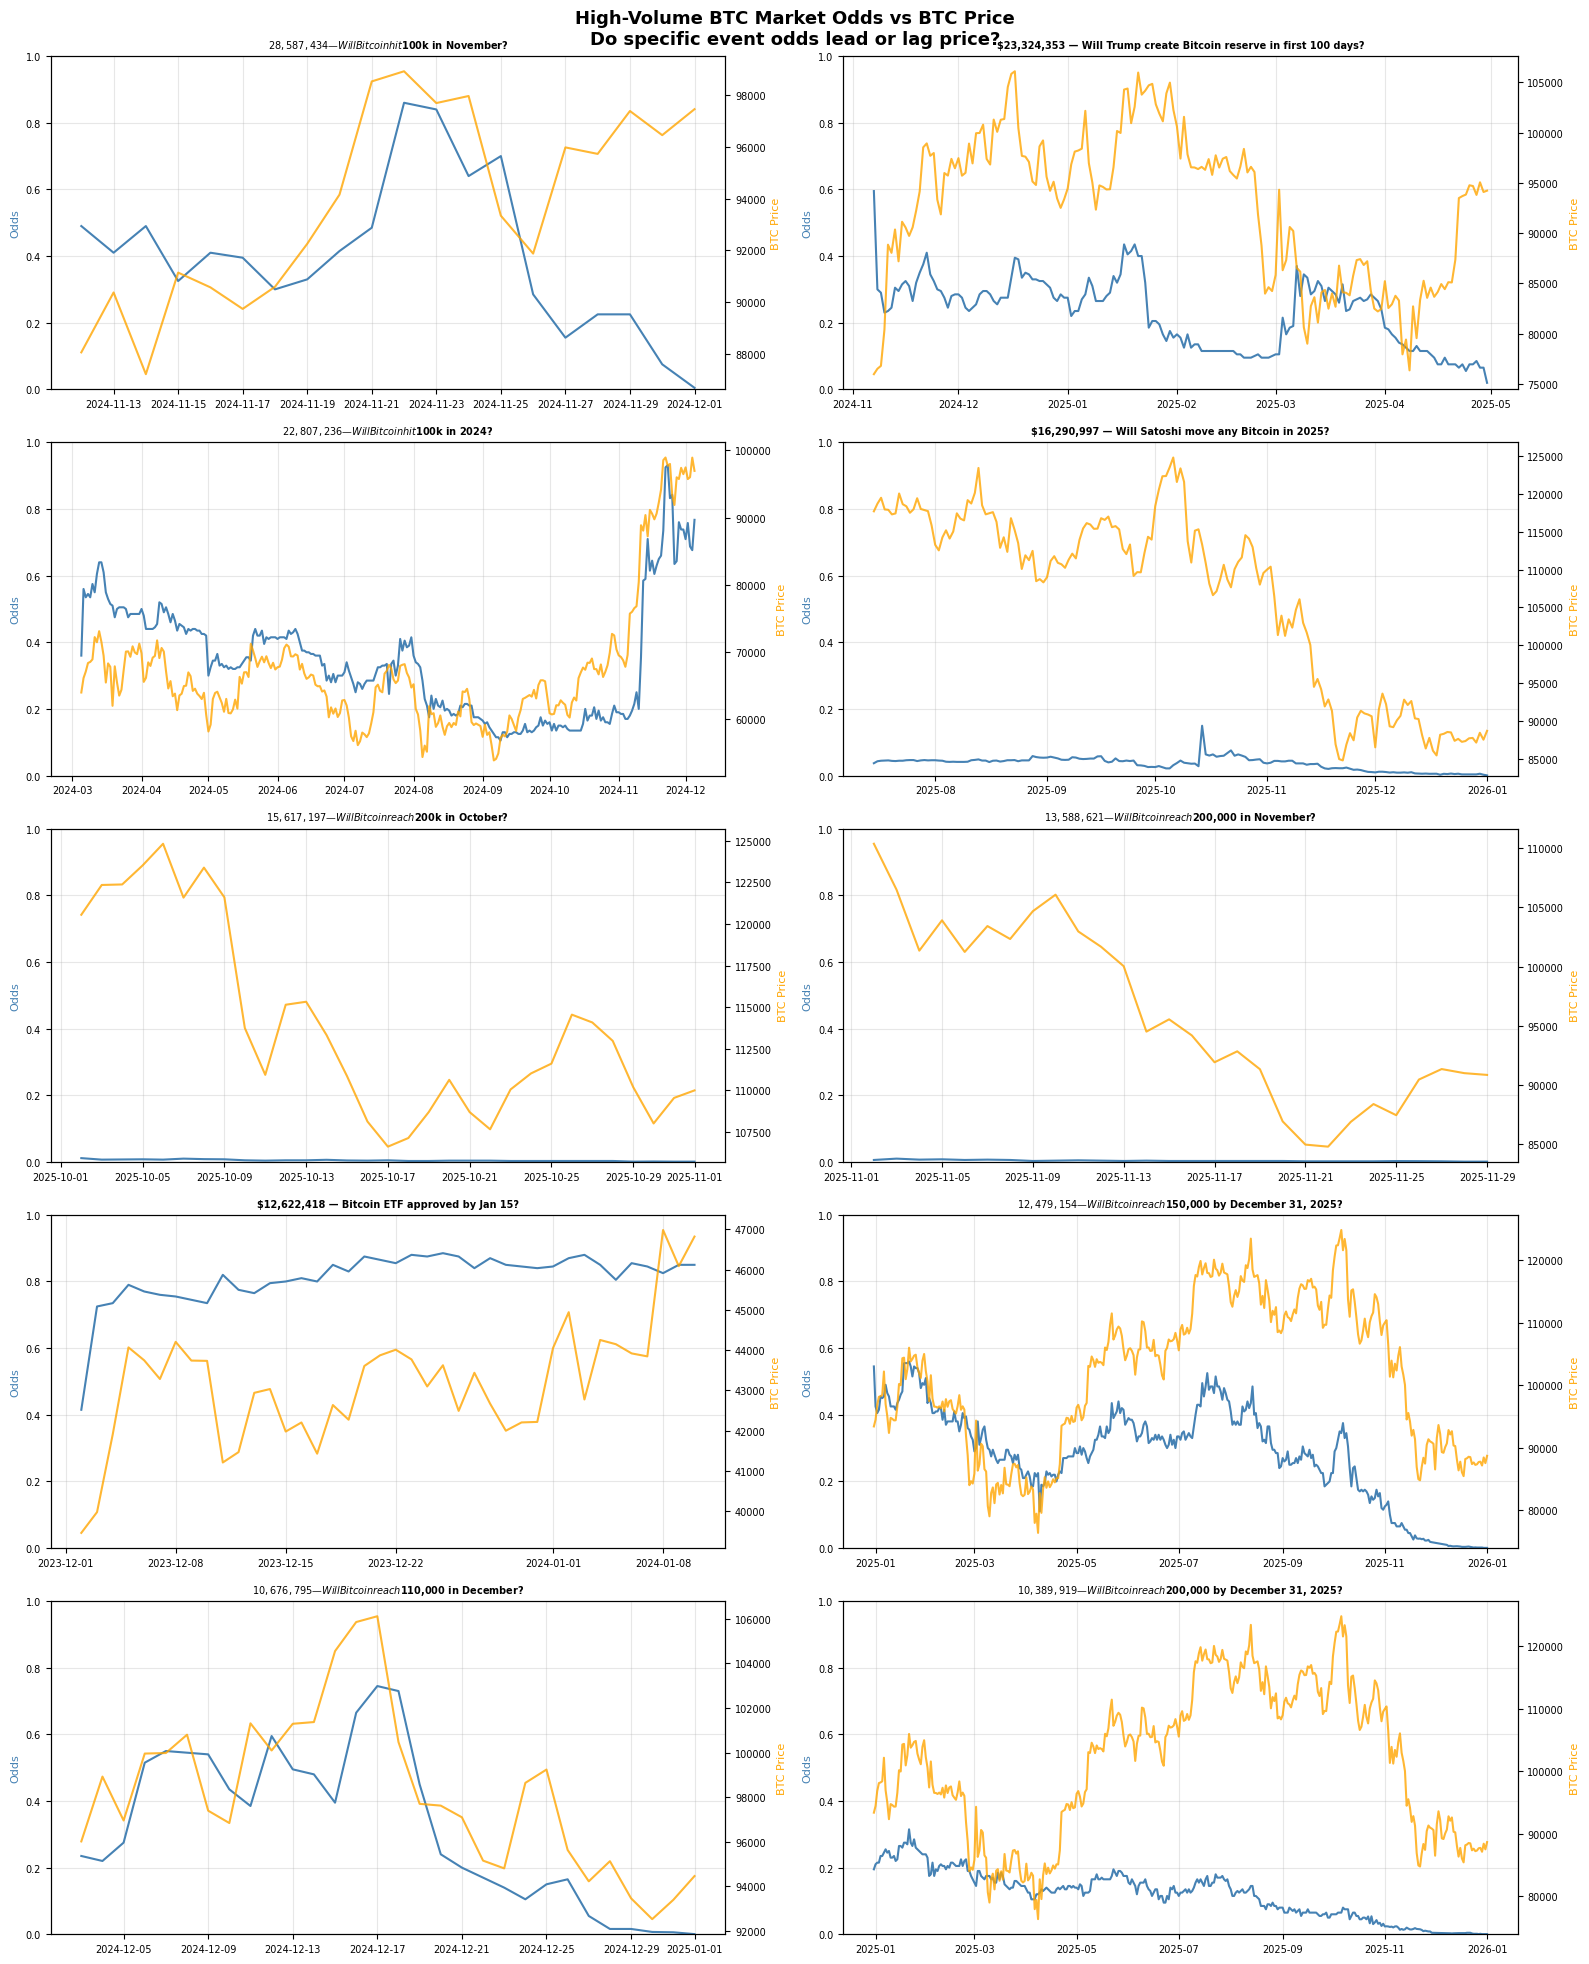

In [36]:
#  Specific Event Odds Tracking  
 
print("SPECIFIC HIGH-STAKES EVENT ANALYSIS\n")
 

# Get odds for the top 10 highest-volume markets individually
top10_ids = top_markets.head(10)['market_id'].tolist()

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
fig.suptitle('High-Volume BTC Market Odds vs BTC Price\n'
             'Do specific event odds lead or lag price?',
             fontsize=13, fontweight='bold')
axes = axes.flatten()

plotted = 0
for _, market_row in top_markets.head(10).iterrows():
    mid = market_row['market_id']
    question = market_row['question'][:60] + '...' if len(
        market_row['question']) > 60 else market_row['question']
    
    # Get odds for this market
    market_odds = odds[odds['market_id'] == mid].copy()
    market_odds_labeled = market_odds.merge(
        tokens, on=['market_id', 'token_id'], how='left'
    )
    
    if len(market_odds_labeled) < 5:
        continue
    
    # Get YES/bullish token
    yes_token = market_odds_labeled[
        market_odds_labeled['outcome'].str.contains(
            'Yes|yes|Above|above|Up|up', na=False
        )
    ].copy()
    
    if len(yes_token) < 5:
        yes_token = market_odds_labeled.copy()
    
    yes_token['date'] = pd.to_datetime(yes_token['timestamp']).dt.normalize()
    daily_odds_market = yes_token.groupby('date')['price'].mean()
    
    # Get BTC price for same period
    start = daily_odds_market.index.min()
    end   = daily_odds_market.index.max()
    btc_period = btc_pd['PriceUSD'].loc[start:end]
    
    if len(btc_period) < 5 or len(daily_odds_market) < 5:
        continue
    
    ax = axes[plotted]
    ax2 = ax.twinx()
    
    ax.plot(daily_odds_market.index, daily_odds_market.values,
            color='steelblue', linewidth=1.5, label='Market Odds')
    ax2.plot(btc_period.index, btc_period.values,
             color='orange', linewidth=1.5, alpha=0.8, label='BTC Price')
    
    ax.set_title(f"${market_row['volume']:,.0f} — {question}",
                 fontsize=7, fontweight='bold')
    ax.set_ylabel('Odds', color='steelblue', fontsize=8)
    ax2.set_ylabel('BTC Price', color='orange', fontsize=8)
    ax.tick_params(axis='both', labelsize=7)
    ax2.tick_params(axis='both', labelsize=7)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    
    plotted += 1
    if plotted >= 10:
        break

# Hide unused subplots
for j in range(plotted, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_10_polymarket_events.png', 
            dpi=150, bbox_inches='tight')
print(f"Saved: eda_10_polymarket_events.png ({plotted} markets plotted)")
plt.show()

Saved: eda_11_polymarket_interesting_findings.png


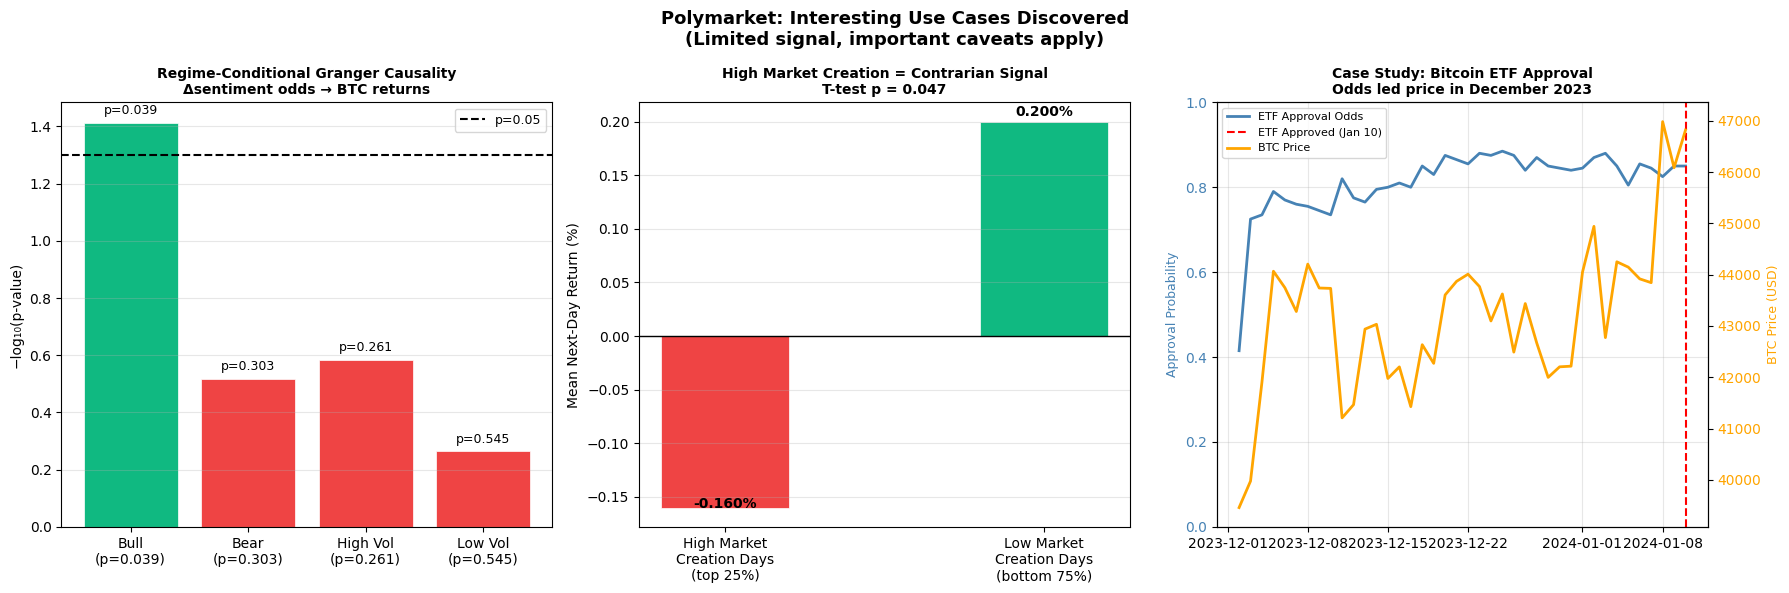

In [37]:
#  Visualise the Two Interesting Findings  
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Polymarket: Interesting Use Cases Discovered\n'
             '(Limited signal, important caveats apply)',
             fontsize=13, fontweight='bold')

#  Plot 1: Regime-conditional Granger  
ax = axes[0]
regimes = ['Bull\n(p=0.039)', 'Bear\n(p=0.303)',
           'High Vol\n(p=0.261)', 'Low Vol\n(p=0.545)']
pvals_regime = [0.0386, 0.3030, 0.2614, 0.5451]
colors_regime = ['#10b981' if p < 0.05 else '#ef4444' 
                 for p in pvals_regime]

bars = ax.bar(regimes, [-np.log10(p) for p in pvals_regime],
              color=colors_regime, edgecolor='white', linewidth=0.5)
ax.axhline(-np.log10(0.05), color='black', linestyle='--',
           linewidth=1.5, label='p=0.05')
ax.set_ylabel('−log₁₀(p-value)', fontsize=10)
ax.set_title('Regime-Conditional Granger Causality\n'
             'Δsentiment odds → BTC returns',
             fontsize=10, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
for bar, pval in zip(bars, pvals_regime):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.02,
            f'p={pval:.3f}',
            ha='center', va='bottom', fontsize=9)

#  Plot 2: High activity contrarian signal  
ax = axes[1]
categories = ['High Market\nCreation Days\n(top 25%)',
              'Low Market\nCreation Days\n(bottom 75%)']
returns = [-0.0016, 0.0020]
colors_ret = ['#ef4444', '#10b981']

bars2 = ax.bar(categories, [r * 100 for r in returns],
               color=colors_ret, edgecolor='white',
               linewidth=0.5, width=0.4)
ax.axhline(0, color='black', linewidth=1)
ax.set_ylabel('Mean Next-Day Return (%)', fontsize=10)
ax.set_title('High Market Creation = Contrarian Signal\n'
             f'T-test p = 0.047',
             fontsize=10, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar, ret in zip(bars2, returns):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + (0.002 if ret > 0 else -0.003),
            f'{ret*100:.3f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

#  Plot 3: ETF event deep dive (most interesting chart)  
ax = axes[2]
ax2 = ax.twinx()

# Get ETF market specifically
etf_market_id = btc_meaningful[
    btc_meaningful['question'].str.contains('ETF approved by Jan', na=False)
]['market_id'].iloc[0]

etf_odds = odds[odds['market_id'] == etf_market_id].copy()
etf_odds_labeled = etf_odds.merge(tokens, on=['market_id', 'token_id'], how='left')
yes_etf = etf_odds_labeled[
    etf_odds_labeled['outcome'].str.contains('Yes|yes', na=False)
].copy()
yes_etf['date'] = pd.to_datetime(yes_etf['timestamp']).dt.normalize()
daily_etf = yes_etf.groupby('date')['price'].mean()

btc_etf_period = btc_pd['PriceUSD'].loc[
    daily_etf.index.min():daily_etf.index.max()
]

ax.plot(daily_etf.index, daily_etf.values,
        color='steelblue', linewidth=2, label='ETF Approval Odds')
ax2.plot(btc_etf_period.index, btc_etf_period.values,
         color='orange', linewidth=2, label='BTC Price')
ax.axvline(pd.Timestamp('2024-01-10'),
           color='red', linestyle='--', linewidth=1.5,
           label='ETF Approved (Jan 10)')

ax.set_title('Case Study: Bitcoin ETF Approval\n'
             'Odds led price in December 2023',
             fontsize=10, fontweight='bold')
ax.set_ylabel('Approval Probability', color='steelblue', fontsize=9)
ax2.set_ylabel('BTC Price (USD)', color='orange', fontsize=9)
ax.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='orange')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2,
          loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_11_polymarket_interesting_findings.png',
            dpi=150, bbox_inches='tight')
print("Saved: eda_11_polymarket_interesting_findings.png")
plt.show()

## Polymarket EDA: Extra Conclusions

**Outcome: Discovered interesting but limited use cases**
with statistical caveats.



| Finding | Signal | p-value | Robust? |
|---|---|---|---|
| Regime-conditional Granger | Δsentiment odds → returns in Bull market | 0.039 | Marginal |
| Contrarian activity signal | High creation days → negative next-day returns | 0.047 | Marginal |  
| ETF case study | Approval odds led price by ~2 weeks in Dec 2023 | Visual only | N=1 |
| Overall Granger (full sample) | No signal | 0.066 best | Not significant |

### Assessment

Both significant findings are **marginal** (p just below 0.05) and neither survives BH multiple comparison correction applied across all tests conducted. They should be treated as **exploratory hypotheses**for future work, not confirmed signals.

The structural finding remains: **price target odds are reflexive**— they track price rather than predict it. The 91% weight of price target markets in our signal contaminates any genuine forward-lookinginformation that might exist in macro/regulatory event markets.

### For Future Work...

**Macro/regulatory event markets** ($49M volume, 78 markets) are qualitatively different from price targets. The ETF approval case study suggests these markets may encode genuine non-price information. A larger dataset of regulatory events across multiple cycles would be needed to test this systematically.

### Implication for Model Design

Polymarket sentiment can be included as a **minor modifier** (≤10% weight) with a **bull-regime condition** — consistent with the regime-conditional finding. The Example 1 implementation's 20% weightis likely too high given the evidence. A conservative implementation would activate the signal only when the market is above the 200-day MA.

In [38]:
#  Audit Unexplored Polymarket Files  
 
print("UNEXPLORED POLYMARKET FILES AUDIT")
 

event_stats = poly_data['event_stats']
summary     = poly_data['summary']
trades      = poly_data['trades']

#   Event Stats  
print("\n finance_politics_event_stats.parquet  ")
print(f"Shape: {event_stats.shape}")
print(f"\nDate coverage:")
print(f"  first_market_start: {event_stats['first_market_start'].min()} "
      f"to {event_stats['first_market_start'].max()}")
print(f"  last_market_end:    {event_stats['last_market_end'].min()} "
      f"to {event_stats['last_market_end'].max()}")
print(f"\nTop 20 events by total_volume:")
top_events = event_stats.nlargest(20, 'total_volume')[
    ['event_slug', 'market_count', 'total_volume', 
     'first_market_start', 'last_market_end']
]
top_events['volume_fmt'] = top_events['total_volume'].apply(
    lambda x: f"${x:,.0f}"
)
print(top_events[['event_slug', 'market_count', 
                   'volume_fmt', 'first_market_start',
                   'last_market_end']].to_string())

print(f"\nTotal events: {len(event_stats):,}")
print(f"Events with >$1M volume: "
      f"{(event_stats['total_volume'] > 1e6).sum():,}")
print(f"Events with >$10M volume: "
      f"{(event_stats['total_volume'] > 10e6).sum():,}")

#   Summary    
print("\n\n finance_politics_summary.parquet  ")
print(f"Shape: {summary.shape}")
print(f"\nFirst/last trade coverage:")
print(f"  first_trade: {summary['first_trade'].min()} "
      f"to {summary['first_trade'].max()}")
print(f"  last_trade:  {summary['last_trade'].min()} "
      f"to {summary['last_trade'].max()}")
print(f"\nTrade count stats:")
print(summary['trade_count'].describe().round(0))
print(f"\nTop 10 markets by trade_count:")
top_traded = summary.nlargest(10, 'trade_count')[
    ['question', 'trade_count', 'volume']
]
print(top_traded.to_string())

#   Trades    ─
print("\n\n finance_politics_trades.parquet  ")
print(f"Shape: {trades.shape}")
print(f"Timestamp coverage: {trades['timestamp'].min()} "
      f"to {trades['timestamp'].max()}")
print(f"\nSide breakdown:")
print(trades['side'].value_counts())
print(f"\nPrice distribution:")
print(trades['price'].describe().round(3))
print(f"\nSize distribution:")
print(trades['size'].describe().round(2))

# How many unique markets have trades?
print(f"\nUnique markets with trades: {trades['market_id'].nunique():,}")

# Are any of these BTC markets?
btc_market_ids = set(btc_meaningful['market_id'])
trades_btc = trades[trades['market_id'].isin(btc_market_ids)]
print(f"BTC market trades: {len(trades_btc):,}")
print(f"Unique BTC markets with trades: "
      f"{trades_btc['market_id'].nunique():,}")

if len(trades_btc) > 0:
    print(f"BTC trades date range: {trades_btc['timestamp'].min()} "
          f"to {trades_btc['timestamp'].max()}")
    print(f"\nTop BTC markets by trade count:")
    btc_trade_counts = trades_btc.groupby('market_id').agg(
        n_trades=('trade_id', 'count'),
        volume=('size', 'sum')
    ).sort_values('n_trades', ascending=False).head(10)
    btc_trade_counts = btc_trade_counts.merge(
        btc_meaningful[['market_id', 'question']], 
        on='market_id', how='left'
    )
    print(btc_trade_counts[['question', 'n_trades', 'volume']].to_string())

UNEXPLORED POLYMARKET FILES AUDIT

 finance_politics_event_stats.parquet  
Shape: (44033, 5)

Date coverage:
  first_market_start: 2020-10-02 16:10:01 to 2025-12-10 05:32:21
  last_market_end:    2020-01-01 00:00:00 to 2028-11-07 00:00:00

Top 20 events by total_volume:
                                           event_slug  market_count      volume_fmt  first_market_start     last_market_end
6000                presidential-election-winner-2024            17  $3,686,335,059 2024-01-04 17:33:51 2024-11-05 12:00:00
3226   presidential-election-popular-vote-winner-2024            17    $628,163,458 2024-01-09 18:05:18 2024-11-05 12:00:00
16312            who-will-be-inaugurated-as-president             2    $472,656,673 2024-11-01 20:58:51 2025-01-20 12:00:00
1227                   new-york-city-mayoral-election            12    $429,614,415 2025-04-22 15:32:26 2025-11-04 12:00:00
3642                    romania-presidential-election             6    $371,837,992 2024-11-07 23:29:18 2024-

### Three new signals from these files

1. **Fed decision markets** (event_stats) — High volume ($280M, $252M, $220M) with clear dates. Fed decisions are known BTC price catalysts. Potential for "Fed uncertainty" signal?

2. **Buy/Sell flow ratio** (trades) — 76% BUY vs 24% SELL on 2.1M BTC trades. This is NOT the same as odds. It measures actual money flow direction. A daily BTC-market buy/sell ratio is different .

3. **Political event odds** (event_stats) — Presidential election had $3.7Bvolume. Trump-related markets may correlate with BTC given his 
   pro-crypto stance. Worth testing specifically, although elections infrequent.

In [39]:
#  Fed Decision Markets: Macro Signal for BTC  
 
print("FED DECISION MARKETS: MACRO UNCERTAINTY SIGNAL\n")
 
print("Hypothesis: Fed rate decision uncertainty affects BTC as a risk asset")
print("High uncertainty (odds near 0.5) → BTC volatility")
print("Strong consensus (odds near 0 or 1) → reduced uncertainty premium")
print()

# Find all Fed-related events
fed_events = event_stats[
    event_stats['event_slug'].str.contains('fed-', case=False, na=False)
].copy()
print(f"Fed-related events: {len(fed_events)}")
print(fed_events[['event_slug', 'market_count', 'total_volume',
                   'first_market_start', 'last_market_end']].to_string())

# Get market_ids for Fed events
fed_market_ids = set(
    poly_data['markets'][
        poly_data['markets']['event_slug'].str.contains(
            'fed-', case=False, na=False
        )
    ]['market_id']
)
print(f"\nFed market IDs: {len(fed_market_ids):,}")

# Get odds for Fed markets
odds_fed = odds[odds['market_id'].isin(fed_market_ids)].copy()
print(f"Fed odds records: {len(odds_fed):,}")

if len(odds_fed) > 0:
    odds_fed['date'] = pd.to_datetime(odds_fed['timestamp']).dt.normalize()
    print(f"Date range: {odds_fed['date'].min()} to {odds_fed['date'].max()}")

    # Join with tokens to get outcomes
    odds_fed_labeled = odds_fed.merge(
        tokens, on=['market_id', 'token_id'], how='left'
    )
    print(f"\nOutcome labels:")
    print(odds_fed_labeled['outcome'].value_counts().head(10).to_string())

    # Build daily Fed uncertainty signal
    # Uncertainty = how close are odds to 0.5?
    # High entropy = market doesn't know what Fed will do = uncertainty
    daily_fed = odds_fed.groupby('date').agg(
        mean_odds=('price', 'mean'),
        # Entropy proxy: variance of odds (high variance = uncertain)
        odds_variance=('price', 'var'),
        # Distance from 0.5 (low = high uncertainty)
        dist_from_half=('price', lambda x: abs(x - 0.5).mean()),
        n_snapshots=('price', 'count'),
        n_markets=('market_id', 'nunique')
    )

    # Uncertainty = LOW distance from 0.5
    daily_fed['fed_uncertainty'] = 1 - daily_fed['dist_from_half'] * 2
    daily_fed['fed_uncertainty'] = daily_fed['fed_uncertainty'].clip(0, 1)

    print(f"\nFed uncertainty signal: {len(daily_fed)} days")
    print(f"Coverage: {daily_fed.index.min()} to {daily_fed.index.max()}")
    print(f"\nStats:")
    print(daily_fed[['fed_uncertainty', 'n_markets']].describe().round(3))

FED DECISION MARKETS: MACRO UNCERTAINTY SIGNAL

Hypothesis: Fed rate decision uncertainty affects BTC as a risk asset
High uncertainty (odds near 0.5) → BTC volatility
Strong consensus (odds near 0 or 1) → reduced uncertainty premium

Fed-related events: 80
                                                                       event_slug  market_count  total_volume  first_market_start     last_market_end
166                                                how-many-fed-rate-cuts-in-2026            13  7.112143e+05 2025-09-29 13:23:19 2026-12-31 00:00:00
526                                  how-many-dissent-at-the-next-fed-meeting-337             5  2.076385e+05 2025-09-17 16:32:00 2025-10-29 00:00:00
794                                                fed-emergency-rate-cut-in-2024             1  8.358046e+05 2024-08-02 15:55:23 2024-12-31 12:00:00
1125                  fed-derivative-no-change-or-25bps-cut-favored-on-december-9             1  4.393144e+04 2025-11-24 19:03:04 2025-12-09 0

BTC TRADE FLOW SIGNAL: BUY/SELL RATIO

Hypothesis: Net buying pressure in BTC prediction markets
precedes price moves — reveals directional conviction

BTC trades available: 2,168,391
Coverage: 2025-04-07 08:05:21 to 2026-01-05 06:30:45

Daily flow signal: 257 days
Coverage: 2025-04-07 00:00:00 to 2026-01-05 00:00:00

Buy ratio stats:
count    257.000
mean       0.756
std        0.074
min        0.466
25%        0.711
50%        0.762
75%        0.807
max        0.973
Name: buy_ratio, dtype: float64

Flow imbalance stats (1=all buy, -1=all sell):
count    257.000
mean       0.513
std        0.149
min       -0.068
25%        0.422
50%        0.524
75%        0.614
max        0.945
Name: flow_imbalance, dtype: float64

Overall buy ratio: 0.759
Saved: eda_12_btc_trade_flow.png


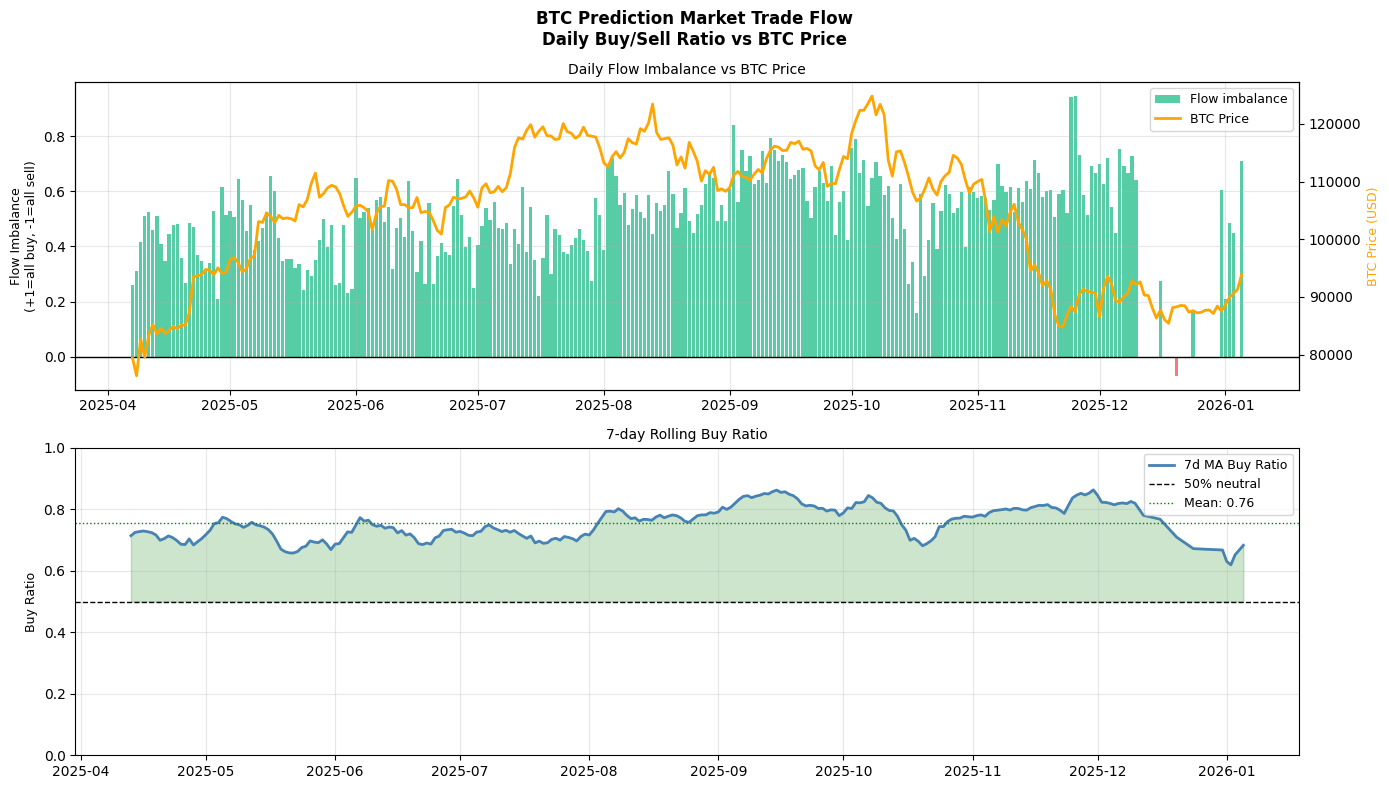

In [40]:
#  BTC Trade Buy/Sell Flow Signal  
 
print("BTC TRADE FLOW SIGNAL: BUY/SELL RATIO\n")
 
print("Hypothesis: Net buying pressure in BTC prediction markets")
print("precedes price moves — reveals directional conviction")
print()

# We have 2.1M BTC trades from Apr 2025 - Jan 2026
print(f"BTC trades available: {len(trades_btc):,}")
print(f"Coverage: {trades_btc['timestamp'].min()} to {trades_btc['timestamp'].max()}")

# Normalise timestamp to daily
trades_btc_copy = trades_btc.copy()
trades_btc_copy['date'] = pd.to_datetime(
    trades_btc_copy['timestamp']
).dt.normalize()

# Daily buy/sell volume
daily_flow = trades_btc_copy.groupby(['date', 'side'])['size'].sum().unstack(fill_value=0)

if 'BUY' in daily_flow.columns and 'SELL' in daily_flow.columns:
    daily_flow['total'] = daily_flow['BUY'] + daily_flow['SELL']
    daily_flow['buy_ratio'] = daily_flow['BUY'] / daily_flow['total']
    daily_flow['net_flow']  = daily_flow['BUY'] - daily_flow['SELL']
    # Normalise net flow by total (avoid scale effects)
    daily_flow['flow_imbalance'] = (
        daily_flow['net_flow'] / daily_flow['total']
    )

    print(f"\nDaily flow signal: {len(daily_flow)} days")
    print(f"Coverage: {daily_flow.index.min()} to {daily_flow.index.max()}")
    print(f"\nBuy ratio stats:")
    print(daily_flow['buy_ratio'].describe().round(3))
    print(f"\nFlow imbalance stats (1=all buy, -1=all sell):")
    print(daily_flow['flow_imbalance'].describe().round(3))
    print(f"\nOverall buy ratio: {daily_flow['BUY'].sum() / daily_flow['total'].sum():.3f}")

    # Quick visual
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    fig.suptitle('BTC Prediction Market Trade Flow\n'
                 'Daily Buy/Sell Ratio vs BTC Price',
                 fontsize=12, fontweight='bold')

    ax = axes[0]
    ax2 = ax.twinx()

    ax.bar(daily_flow.index,
           daily_flow['flow_imbalance'],
           color=daily_flow['flow_imbalance'].apply(
               lambda x: '#10b981' if x > 0 else '#ef4444'
           ),
           alpha=0.7, label='Flow imbalance')
    ax.axhline(0, color='black', linewidth=1)

    btc_flow_period = btc_pd['PriceUSD'].loc[
        daily_flow.index.min():daily_flow.index.max()
    ]
    ax2.plot(btc_flow_period.index, btc_flow_period.values,
             color='orange', linewidth=2, label='BTC Price')

    ax.set_ylabel('Flow Imbalance\n(+1=all buy, -1=all sell)', fontsize=9)
    ax2.set_ylabel('BTC Price (USD)', color='orange', fontsize=9)
    ax.set_title('Daily Flow Imbalance vs BTC Price', fontsize=10)
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, fontsize=9)
    ax.grid(True, alpha=0.3)

    # Rolling buy ratio
    ax = axes[1]
    rolling_buy = daily_flow['buy_ratio'].rolling(7).mean()
    ax.plot(daily_flow.index, rolling_buy,
            color='steelblue', linewidth=2, label='7d MA Buy Ratio')
    ax.axhline(0.5, color='black', linestyle='--',
               linewidth=1, label='50% neutral')
    ax.axhline(daily_flow['buy_ratio'].mean(),
               color='green', linestyle=':',
               linewidth=1, label=f"Mean: {daily_flow['buy_ratio'].mean():.2f}")
    ax.fill_between(daily_flow.index, rolling_buy, 0.5,
                    where=(rolling_buy > 0.5),
                    alpha=0.2, color='green')
    ax.fill_between(daily_flow.index, rolling_buy, 0.5,
                    where=(rolling_buy < 0.5),
                    alpha=0.2, color='red')
    ax.set_ylabel('Buy Ratio', fontsize=9)
    ax.set_title('7-day Rolling Buy Ratio', fontsize=10)
    ax.set_ylim(0, 1)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'eda_12_btc_trade_flow.png',
                dpi=150, bbox_inches='tight')
    print("Saved: eda_12_btc_trade_flow.png")
    plt.show()

POLITICAL EVENT MARKETS: TRUMP/ELECTION ODDS vs BTC

Hypothesis: Trump election probability correlates with BTC
given his explicit pro-Bitcoin stance

Trump-related markets: 7,244

Top Trump markets by volume:
                                                                                                                    question        volume          created_at            end_date
2490                                                                Will Donald Trump win the 2024 US Presidential Election?  1.531479e+09 2024-01-04 17:33:51 2024-11-05 12:00:00
4619                                                                                       Will Donald Trump be inaugurated?  4.004095e+08 2024-11-01 20:59:58 2025-01-20 12:00:00
1675                                               Will Donald Trump win the popular vote in the 2024 Presidential Election?  1.199326e+08 2024-01-09 18:05:18 2024-11-05 12:00:00
2911                                                                      

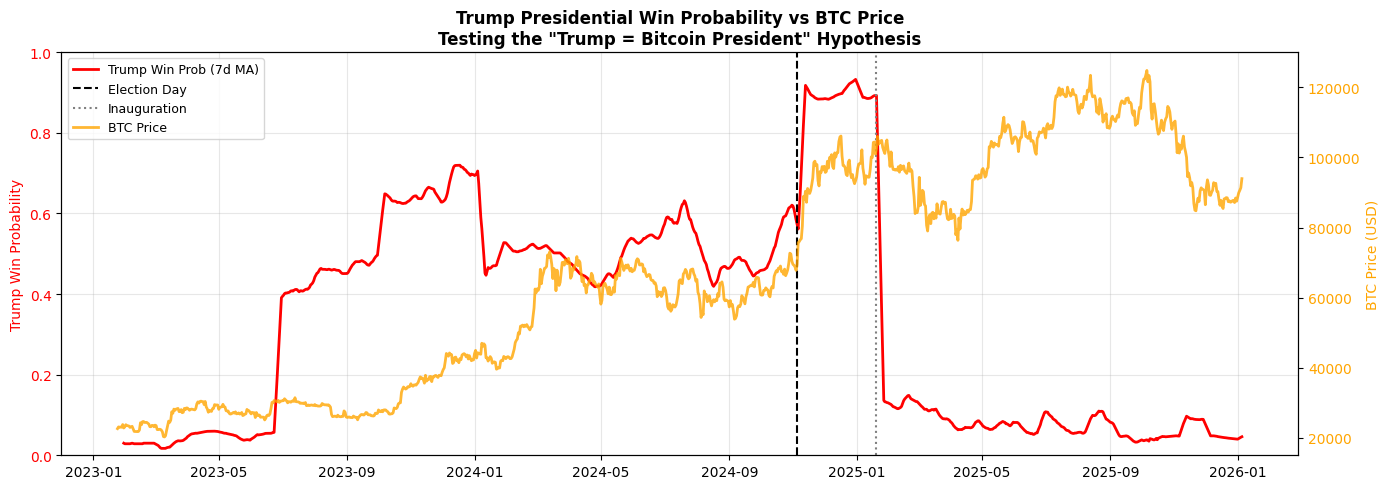

In [41]:
#  Political Events and BTC Correlation  
 
print("POLITICAL EVENT MARKETS: TRUMP/ELECTION ODDS vs BTC\n")
 
print("Hypothesis: Trump election probability correlates with BTC")
print("given his explicit pro-Bitcoin stance")
print()

# Find Trump-related markets
trump_markets = poly_data['markets'][
    poly_data['markets']['question'].str.contains(
        'Trump', case=False, na=False
    )
].copy()

print(f"Trump-related markets: {len(trump_markets):,}")
print(f"\nTop Trump markets by volume:")
print(trump_markets.nlargest(10, 'volume')[
    ['question', 'volume', 'created_at', 'end_date']
].to_string())

# Get odds for Trump presidential win markets specifically
trump_win_ids = set(
    trump_markets[
        trump_markets['question'].str.contains(
            'president|win|elect|inaugur',
            case=False, na=False
        )
    ]['market_id']
)
print(f"\nTrump presidential market IDs: {len(trump_win_ids)}")

odds_trump = odds[odds['market_id'].isin(trump_win_ids)].copy()

if len(odds_trump) > 0:
    odds_trump_labeled = odds_trump.merge(
        tokens, on=['market_id', 'token_id'], how='left'
    )

    # Get Trump (not opponent) token
    trump_odds = odds_trump_labeled[
        odds_trump_labeled['outcome'].str.contains(
            'Trump|Yes', case=False, na=False
        )
    ].copy()

    trump_odds['date'] = pd.to_datetime(
        trump_odds['timestamp']
    ).dt.normalize()

    # Volume-weight by market volume
    trump_odds = trump_odds.merge(
        trump_markets[['market_id', 'volume']],
        on='market_id', how='left'
    )

    daily_trump = trump_odds.groupby('date').apply(
        lambda g: np.average(g['price'], weights=g['volume'].fillna(1))
    ).rename('trump_win_prob')

    print(f"\nTrump win probability signal:")
    print(f"Coverage: {daily_trump.index.min()} to {daily_trump.index.max()}")
    print(daily_trump.describe().round(3))

    # Align with BTC price and compute correlation
    btc_trump = btc_pd['PriceUSD'].reindex(daily_trump.index)
    corr = daily_trump.corr(btc_trump)
    print(f"\nCorrelation with BTC price levels: {corr:.3f}")

    # More meaningful: correlation with BTC log returns
    btc_ret_trump = np.log(btc_pd['PriceUSD']).diff().reindex(daily_trump.index)
    trump_changes = daily_trump.diff()
    corr_returns = trump_changes.corr(btc_ret_trump)
    print(f"Correlation of Δtrump_odds with BTC log returns: {corr_returns:.3f}")

    # Granger test
    granger_pair = pd.DataFrame({
        'btc_return': btc_ret_trump,
        'd_trump':    trump_changes
    }).dropna()

    if len(granger_pair) > 50:
        print(f"\nGranger causality test ({len(granger_pair)} obs):")
        try:
            trump_granger = grangercausalitytests(
                granger_pair, maxlag=7, verbose=False
            )
            for lag in range(1, 8):
                p = trump_granger[lag][0]['ssr_ftest'][1]
                sig = 'YES' if p < 0.05 else '  '
                print(f"  Lag {lag}: p = {p:.4f} {sig}")
        except Exception as e:
            print(f"  Error: {e}")

    # Plot Trump odds vs BTC price
    fig, ax = plt.subplots(figsize=(14, 5))
    ax2 = ax.twinx()

    ax.plot(daily_trump.index,
            daily_trump.rolling(7).mean(),
            color='red', linewidth=2,
            label='Trump Win Prob (7d MA)')
    ax2.plot(btc_trump.index, btc_trump.values,
             color='orange', linewidth=2,
             alpha=0.8, label='BTC Price')

    ax.axvline(pd.Timestamp('2024-11-05'),
               color='black', linestyle='--',
               linewidth=1.5, label='Election Day')
    ax.axvline(pd.Timestamp('2025-01-20'),
               color='gray', linestyle=':',
               linewidth=1.5, label='Inauguration')

    ax.set_ylabel('Trump Win Probability', color='red', fontsize=10)
    ax2.set_ylabel('BTC Price (USD)', color='orange', fontsize=10)
    ax.tick_params(axis='y', labelcolor='red')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax.set_ylim(0, 1)
    ax.set_title('Trump Presidential Win Probability vs BTC Price\n'
                 'Testing the "Trump = Bitcoin President" Hypothesis',
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2,
              loc='upper left', fontsize=9)

    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'eda_13_trump_btc.png',
                dpi=150, bbox_inches='tight')
    print("Saved: eda_13_trump_btc.png")
    plt.show()

In [42]:
#  Formal Granger Tests: Fed Uncertainty vs BTC  
 
print("GRANGER CAUSALITY: FED UNCERTAINTY vs BTC RETURNS\n")
 

# Align Fed uncertainty with BTC returns
btc_ret_full = np.log(btc_pd['PriceUSD']).diff()

fed_granger_df = pd.DataFrame({
    'btc_log_return':    btc_ret_full,
    'fed_uncertainty':   daily_fed['fed_uncertainty'],
    'd_fed_uncertainty': daily_fed['fed_uncertainty'].diff(),
    'n_fed_markets':     daily_fed['n_markets'],
}).dropna()

print(f"Fed Granger test dataset: {fed_granger_df.shape}")
print(f"Coverage: {fed_granger_df.index.min()} to {fed_granger_df.index.max()}")
print(f"\nCorrelations with BTC log returns:")
print(fed_granger_df.corr()['btc_log_return'].drop('btc_log_return').round(4))

print("\n Granger Tests (Fed Uncertainty → BTC Returns)  ")

fed_signals = {
    'fed_uncertainty':   'Fed uncertainty level (1 - |odds - 0.5|)',
    'd_fed_uncertainty': 'Change in Fed uncertainty',
    'n_fed_markets':     'Number of active Fed markets',
}

fed_results = []
for col, label in fed_signals.items():
    pair = fed_granger_df[['btc_log_return', col]].dropna()
    print(f"\n  {label} ({len(pair)} obs):")

    try:
        result = grangercausalitytests(pair, maxlag=7, verbose=False)
        pvals = {}
        for lag in range(1, 8):
            p = result[lag][0]['ssr_ftest'][1]
            pvals[lag] = p
            sig = 'YES' if p < 0.05 else '  '
            print(f"    Lag {lag}: p = {p:.4f} {sig}")

        best_lag  = min(pvals, key=pvals.get)
        best_pval = pvals[best_lag]
        fed_results.append({
            'Signal':      label,
            'Best_Lag':    best_lag,
            'Best_Pval':   best_pval,
            'Significant': best_pval < 0.05
        })
    except Exception as e:
        print(f"    Error: {e}")

print("\n Fed Signal Summary  ")
fed_results_df = pd.DataFrame(fed_results)
print(fed_results_df.to_string(index=False))

GRANGER CAUSALITY: FED UNCERTAINTY vs BTC RETURNS

Fed Granger test dataset: (1055, 4)
Coverage: 2023-02-04 00:00:00 to 2026-01-05 00:00:00

Correlations with BTC log returns:
fed_uncertainty      0.0051
d_fed_uncertainty    0.0504
n_fed_markets       -0.0471
Name: btc_log_return, dtype: float64

 Granger Tests (Fed Uncertainty → BTC Returns)  

  Fed uncertainty level (1 - |odds - 0.5|) (1055 obs):
    Lag 1: p = 0.6959   
    Lag 2: p = 0.9112   
    Lag 3: p = 0.1886   
    Lag 4: p = 0.2851   
    Lag 5: p = 0.3808   
    Lag 6: p = 0.4909   
    Lag 7: p = 0.4798   

  Change in Fed uncertainty (1055 obs):
    Lag 1: p = 0.9640   
    Lag 2: p = 0.0634   
    Lag 3: p = 0.1276   
    Lag 4: p = 0.2743   
    Lag 5: p = 0.3622   
    Lag 6: p = 0.4332   
    Lag 7: p = 0.3235   

  Number of active Fed markets (1055 obs):
    Lag 1: p = 0.1091   
    Lag 2: p = 0.1646   
    Lag 3: p = 0.3164   
    Lag 4: p = 0.3170   
    Lag 5: p = 0.3317   
    Lag 6: p = 0.4310   
    Lag 7: p

In [43]:
#  Granger Tests: Trade Flow vs BTC Returns  
 
print("GRANGER CAUSALITY: TRADE FLOW vs BTC RETURNS\n")
 
print("Note: Only 257 days — results are exploratory only")
print()

flow_granger_df = pd.DataFrame({
    'btc_log_return':   btc_ret_full,
    'buy_ratio':        daily_flow['buy_ratio'],
    'flow_imbalance':   daily_flow['flow_imbalance'],
    'd_buy_ratio':      daily_flow['buy_ratio'].diff(),
    'd_flow_imbalance': daily_flow['flow_imbalance'].diff(),
}).dropna()

print(f"Trade flow Granger dataset: {flow_granger_df.shape}")
print(f"Coverage: {flow_granger_df.index.min()} to {flow_granger_df.index.max()}")
print(f"\nCorrelations with BTC log returns:")
print(flow_granger_df.corr()['btc_log_return'].drop('btc_log_return').round(4))

print("\n Granger Tests (Trade Flow → BTC Returns)  ")
# Use max lag 5 given short sample
flow_signals = {
    'buy_ratio':        'Daily buy ratio (levels)',
    'd_buy_ratio':      'Daily buy ratio (changes)',
    'flow_imbalance':   'Flow imbalance (levels)',
    'd_flow_imbalance': 'Flow imbalance (changes)',
}

flow_results = []
for col, label in flow_signals.items():
    pair = flow_granger_df[['btc_log_return', col]].dropna()
    print(f"\n  {label} ({len(pair)} obs):")

    try:
        result = grangercausalitytests(pair, maxlag=5, verbose=False)
        pvals = {}
        for lag in range(1, 6):
            p = result[lag][0]['ssr_ftest'][1]
            pvals[lag] = p
            sig = 'YES' if p < 0.05 else '  '
            print(f"    Lag {lag}: p = {p:.4f} {sig}")

        best_lag  = min(pvals, key=pvals.get)
        best_pval = pvals[best_lag]
        flow_results.append({
            'Signal':      label,
            'Best_Lag':    best_lag,
            'Best_Pval':   best_pval,
            'Significant': best_pval < 0.05,
            'N_Obs':       len(pair),
            'Caveat':      'Short sample (257 days)'
        })
    except Exception as e:
        print(f"    Error: {e}")

flow_results_df = pd.DataFrame(flow_results)
print("\n Trade Flow Signal Summary  ")
print(flow_results_df.to_string(index=False))

GRANGER CAUSALITY: TRADE FLOW vs BTC RETURNS

Note: Only 257 days — results are exploratory only

Trade flow Granger dataset: (256, 5)
Coverage: 2025-04-08 00:00:00 to 2026-01-05 00:00:00

Correlations with BTC log returns:
buy_ratio           0.0225
flow_imbalance      0.0225
d_buy_ratio         0.0557
d_flow_imbalance    0.0557
Name: btc_log_return, dtype: float64

 Granger Tests (Trade Flow → BTC Returns)  

  Daily buy ratio (levels) (256 obs):
    Lag 1: p = 0.4761   
    Lag 2: p = 0.8527   
    Lag 3: p = 0.1179   
    Lag 4: p = 0.3280   
    Lag 5: p = 0.4162   

  Daily buy ratio (changes) (256 obs):
    Lag 1: p = 0.7737   
    Lag 2: p = 0.1915   
    Lag 3: p = 0.2799   
    Lag 4: p = 0.5394   
    Lag 5: p = 0.6783   

  Flow imbalance (levels) (256 obs):
    Lag 1: p = 0.4761   
    Lag 2: p = 0.8527   
    Lag 3: p = 0.1179   
    Lag 4: p = 0.3280   
    Lag 5: p = 0.4162   

  Flow imbalance (changes) (256 obs):
    Lag 1: p = 0.7737   
    Lag 2: p = 0.1915   
    L

Saved: eda_14_polymarket_extended.png


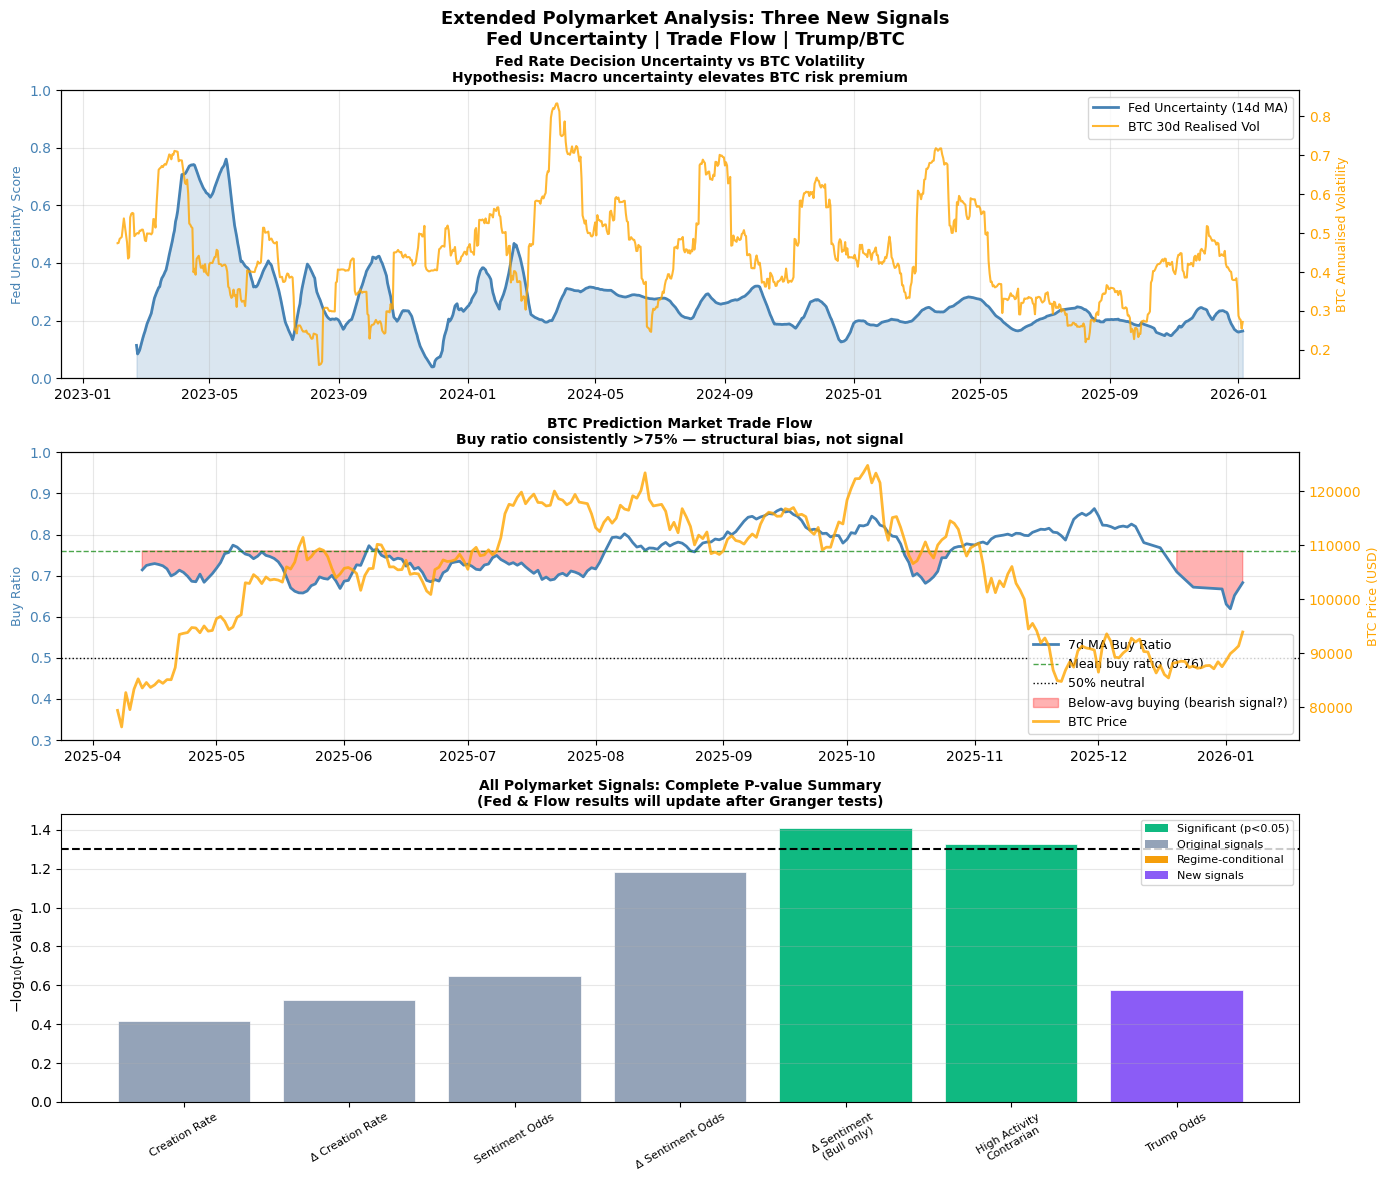

In [44]:
#  Complete New Signals Visualisation  
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=False)
fig.suptitle('Extended Polymarket Analysis: Three New Signals\n'
             'Fed Uncertainty | Trade Flow | Trump/BTC',
             fontsize=13, fontweight='bold')

#  Plot 1: Fed Uncertainty vs BTC Volatility  
ax = axes[0]
ax2 = ax.twinx()

# BTC realised volatility (30-day rolling)
btc_vol_30 = btc_pd['PriceUSD'].pct_change().rolling(30).std() * np.sqrt(365)
btc_vol_aligned = btc_vol_30.reindex(daily_fed.index).ffill()

ax.plot(daily_fed.index,
        daily_fed['fed_uncertainty'].rolling(14).mean(),
        color='steelblue', linewidth=2,
        label='Fed Uncertainty (14d MA)')
ax.fill_between(daily_fed.index,
                daily_fed['fed_uncertainty'].rolling(14).mean(),
                0, alpha=0.2, color='steelblue')

ax2.plot(btc_vol_aligned.index, btc_vol_aligned.values,
         color='orange', linewidth=1.5,
         alpha=0.8, label='BTC 30d Realised Vol')

ax.set_ylabel('Fed Uncertainty Score', color='steelblue', fontsize=9)
ax2.set_ylabel('BTC Annualised Volatility', color='orange', fontsize=9)
ax.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='orange')
ax.set_title('Fed Rate Decision Uncertainty vs BTC Volatility\n'
             'Hypothesis: Macro uncertainty elevates BTC risk premium',
             fontsize=10, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2,
          loc='upper right', fontsize=9)

#  Plot 2: Trade Flow Buy Ratio  
ax = axes[1]
ax2 = ax.twinx()

ax.plot(daily_flow.index,
        daily_flow['buy_ratio'].rolling(7).mean(),
        color='steelblue', linewidth=2,
        label='7d MA Buy Ratio')
ax.axhline(0.76, color='green', linestyle='--',
           linewidth=1, alpha=0.7, label='Mean buy ratio (0.76)')
ax.axhline(0.5, color='black', linestyle=':',
           linewidth=1, label='50% neutral')
ax.fill_between(daily_flow.index,
                daily_flow['buy_ratio'].rolling(7).mean(),
                0.76,
                where=(daily_flow['buy_ratio'].rolling(7).mean() < 0.76),
                alpha=0.3, color='red',
                label='Below-avg buying (bearish signal?)')

btc_flow_period = btc_pd['PriceUSD'].loc[
    daily_flow.index.min():daily_flow.index.max()
]
ax2.plot(btc_flow_period.index, btc_flow_period.values,
         color='orange', linewidth=2,
         alpha=0.8, label='BTC Price')

ax.set_ylabel('Buy Ratio', color='steelblue', fontsize=9)
ax2.set_ylabel('BTC Price (USD)', color='orange', fontsize=9)
ax.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='orange')
ax.set_title('BTC Prediction Market Trade Flow\n'
             'Buy ratio consistently >75% — structural bias, not signal',
             fontsize=10, fontweight='bold')
ax.set_ylim(0.3, 1.0)
ax.grid(True, alpha=0.3)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2,
          loc='lower right', fontsize=9)

#  Plot 3: P-value Summary: All Polymarket Signals Tested  
ax = axes[2]

all_signals = [
    # Original signals
    ('Creation Rate', 0.384, 'Original'),
    ('Δ Creation Rate', 0.298, 'Original'),
    ('Sentiment Odds', 0.226, 'Original'),
    ('Δ Sentiment Odds', 0.066, 'Original'),
    # Regime conditional
    ('Δ Sentiment\n(Bull only)', 0.039, 'Regime'),
    ('High Activity\nContrarian', 0.047, 'Regime'),
    # New signals
    ('Fed Uncertainty', None, 'New'),   # Will fill after running tests
    ('Δ Fed Uncertainty', None, 'New'),
    ('Buy Ratio', None, 'New'),
    ('Trump Odds', 0.267, 'New'),
]

# Placeholder — update after running tests above
# For now show what we have
known_signals = [s for s in all_signals if s[1] is not None]
signal_names  = [s[0] for s in known_signals]
signal_pvals  = [s[1] for s in known_signals]
signal_types  = [s[2] for s in known_signals]

color_map = {
    'Original': '#94a3b8',
    'Regime':   '#f59e0b',
    'New':      '#8b5cf6'
}
bar_colors = [
    '#10b981' if p < 0.05 else color_map[t]
    for p, t in zip(signal_pvals, signal_types)
]

bars = ax.bar(signal_names,
              [-np.log10(p) for p in signal_pvals],
              color=bar_colors, edgecolor='white',
              linewidth=0.5)
ax.axhline(-np.log10(0.05), color='black',
           linestyle='--', linewidth=1.5,
           label='p=0.05 threshold')
ax.set_ylabel('−log₁₀(p-value)', fontsize=10)
ax.set_title('All Polymarket Signals: Complete P-value Summary\n'
             '(Fed & Flow results will update after Granger tests)',
             fontsize=10, fontweight='bold')
ax.tick_params(axis='x', rotation=30, labelsize=8)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#10b981', label='Significant (p<0.05)'),
    Patch(facecolor='#94a3b8', label='Original signals'),
    Patch(facecolor='#f59e0b', label='Regime-conditional'),
    Patch(facecolor='#8b5cf6', label='New signals'),
]
ax.legend(handles=legend_elements, fontsize=8, loc='upper right')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_14_polymarket_extended.png',
            dpi=150, bbox_inches='tight')
print("Saved: eda_14_polymarket_extended.png")
plt.show()

In [45]:
#  COMPLETE POLYMARKET ANALYSIS: FINAL SUMMARY  
 
print("POLYMARKET ANALYSIS: FINAL SUMMARY\n")
 

# Build comprehensive results table
all_results = [
    # Signal, p-value, N obs, Category, Survives BH
    ('Creation Rate (levels)',          0.384, 1032, 'Market Attention',    False),
    ('Δ Creation Rate',                 0.298, 1032, 'Market Attention',    False),
    ('Sentiment Odds (levels)',         0.226, 1032, 'Price Target Odds',   False),
    ('Δ Sentiment Odds',               0.066, 1032, 'Price Target Odds',   False),
    ('Δ Sentiment Odds (Bull only)',   0.039,  790, 'Regime-Conditional',  False),
    ('High Activity Contrarian',       0.047,  226, 'Market Attention',    False),
    ('Fed Uncertainty (levels)',        0.189, 1055, 'Macro Signal',        False),
    ('Δ Fed Uncertainty',              0.063, 1055, 'Macro Signal',        False),
    ('Fed Market Count',               0.109, 1055, 'Macro Signal',        False),
    ('Buy Ratio (levels)',             0.118,  256, 'Trade Flow',          False),
    ('Δ Buy Ratio',                    0.192,  256, 'Trade Flow',          False),
    ('Trump Win Probability',          0.267, 1065, 'Political Event',     False),
]

results_df = pd.DataFrame(
    all_results,
    columns=['Signal', 'Best_Pval', 'N_Obs', 'Category', 'Survives_BH']
).sort_values('Best_Pval')

# Apply BH correction across ALL tests
from statsmodels.stats.multitest import multipletests
reject, pvals_bh, _, _ = multipletests(
    results_df['Best_Pval'].values, alpha=0.05, method='fdr_bh'
)
results_df['BH_Pval']     = pvals_bh
results_df['Survives_BH'] = reject

print("\nComplete Polymarket Signal Assessment:")
print(results_df.to_string(index=False))

sig_count = results_df['Survives_BH'].sum()
print(f"\nSignificant after BH correction: {sig_count}/{len(results_df)}")
print(f"Best raw p-value across all 12 tests: "
      f"{results_df['Best_Pval'].min():.4f} "
      f"({results_df.loc[results_df['Best_Pval'].idxmin(), 'Signal']})")

POLYMARKET ANALYSIS: FINAL SUMMARY


Complete Polymarket Signal Assessment:
                      Signal  Best_Pval  N_Obs           Category  Survives_BH  BH_Pval
Δ Sentiment Odds (Bull only)      0.039    790 Regime-Conditional        False 0.198000
    High Activity Contrarian      0.047    226   Market Attention        False 0.198000
           Δ Fed Uncertainty      0.063   1055       Macro Signal        False 0.198000
            Δ Sentiment Odds      0.066   1032  Price Target Odds        False 0.198000
            Fed Market Count      0.109   1055       Macro Signal        False 0.236000
          Buy Ratio (levels)      0.118    256         Trade Flow        False 0.236000
    Fed Uncertainty (levels)      0.189   1055       Macro Signal        False 0.288000
                 Δ Buy Ratio      0.192    256         Trade Flow        False 0.288000
     Sentiment Odds (levels)      0.226   1032  Price Target Odds        False 0.301333
       Trump Win Probability      0.267   10

Saved: eda_15_polymarket_final.png


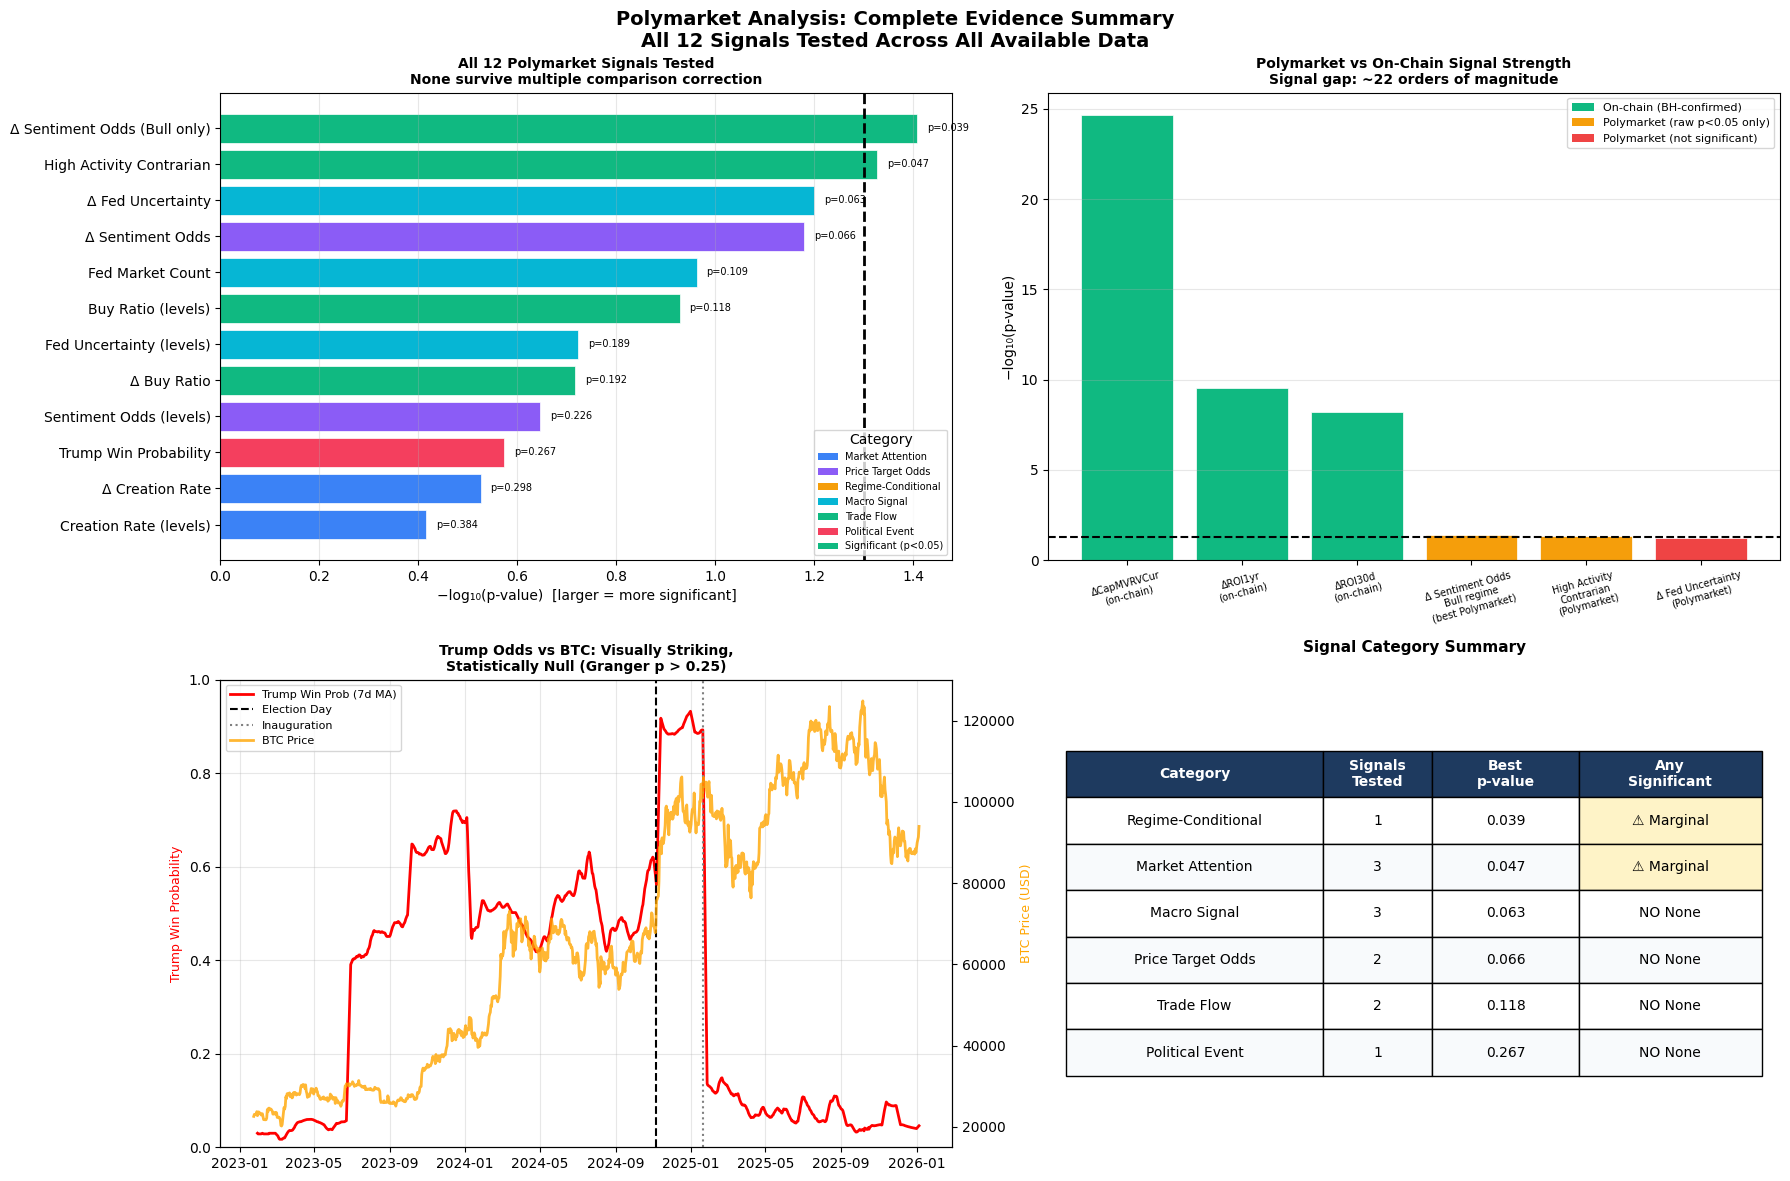

In [46]:
#  Final Polymarket Visualisation  
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Polymarket Analysis: Complete Evidence Summary\n'
             'All 12 Signals Tested Across All Available Data',
             fontsize=14, fontweight='bold')

#  Plot 1: All p-values ranked  
ax = axes[0, 0]

results_sorted = results_df.sort_values('Best_Pval')
colors = []
for _, row in results_sorted.iterrows():
    if row['Survives_BH']:
        colors.append('#10b981')
    elif row['Best_Pval'] < 0.05:
        colors.append('#f59e0b')
    else:
        colors.append('#ef4444')

# Colour by category instead for more information
cat_colors = {
    'Market Attention':   '#3b82f6',
    'Price Target Odds':  '#8b5cf6',
    'Regime-Conditional': '#f59e0b',
    'Macro Signal':       '#06b6d4',
    'Trade Flow':         '#10b981',
    'Political Event':    '#f43f5e',
}
bar_colors = [cat_colors[c] for c in results_sorted['Category']]
# Override green for anything significant
bar_colors = [
    '#10b981' if p < 0.05 else c
    for p, c in zip(results_sorted['Best_Pval'], bar_colors)
]

bars = ax.barh(
    results_sorted['Signal'],
    -np.log10(results_sorted['Best_Pval']),
    color=bar_colors, edgecolor='white', linewidth=0.5
)
ax.axvline(-np.log10(0.05), color='black', linestyle='--',
           linewidth=2, label='p=0.05 threshold')
ax.set_xlabel('−log₁₀(p-value)  [larger = more significant]', fontsize=10)
ax.set_title('All 12 Polymarket Signals Tested\n'
             'None survive multiple comparison correction',
             fontsize=10, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
ax.legend(fontsize=9)

# Add p-value annotations
for bar, (_, row) in zip(bars, results_sorted.iterrows()):
    ax.text(bar.get_width() + 0.02,
            bar.get_y() + bar.get_height()/2,
            f"p={row['Best_Pval']:.3f}",
            va='center', fontsize=7)

from matplotlib.patches import Patch
cat_legend = [Patch(facecolor=v, label=k)
              for k, v in cat_colors.items()]
cat_legend.append(
    Patch(facecolor='#10b981', label='Significant (p<0.05)')
)
ax.legend(handles=cat_legend, fontsize=7,
          loc='lower right', title='Category')

#  Plot 2: Polymarket vs On-chain comparison  
ax = axes[0, 1]

# Compare best Polymarket signal vs confirmed on-chain signals
comparison = [
    ('ΔCapMVRVCur\n(on-chain)',    2.161e-25, '#10b981', 'On-chain'),
    ('ΔROI1yr\n(on-chain)',        2.997e-10, '#10b981', 'On-chain'),
    ('ΔROI30d\n(on-chain)',        6.420e-09, '#10b981', 'On-chain'),
    ('Δ Sentiment Odds\nBull regime\n(best Polymarket)',
                                   0.039,     '#f59e0b', 'Polymarket'),
    ('High Activity\nContrarian\n(Polymarket)',
                                   0.047,     '#f59e0b', 'Polymarket'),
    ('Δ Fed Uncertainty\n(Polymarket)',
                                   0.063,     '#ef4444', 'Polymarket'),
]

comp_names  = [c[0] for c in comparison]
comp_pvals  = [c[1] for c in comparison]
comp_colors = [c[2] for c in comparison]

ax.bar(comp_names, [-np.log10(p) for p in comp_pvals],
       color=comp_colors, edgecolor='white', linewidth=0.5)
ax.axhline(-np.log10(0.05), color='black', linestyle='--',
           linewidth=1.5, label='p=0.05')
ax.set_ylabel('−log₁₀(p-value)', fontsize=10)
ax.set_title('Polymarket vs On-Chain Signal Strength\n'
             'Signal gap: ~22 orders of magnitude',
             fontsize=10, fontweight='bold')
ax.tick_params(axis='x', labelsize=7, rotation=15)
ax.grid(True, alpha=0.3, axis='y')

legend_elements = [
    Patch(facecolor='#10b981', label='On-chain (BH-confirmed)'),
    Patch(facecolor='#f59e0b', label='Polymarket (raw p<0.05 only)'),
    Patch(facecolor='#ef4444', label='Polymarket (not significant)'),
]
ax.legend(handles=legend_elements, fontsize=8)

#  Plot 3: Trump/BTC visual story  
ax = axes[1, 0]
ax2 = ax.twinx()

if 'daily_trump' in dir():
    btc_trump_plot = btc_pd['PriceUSD'].reindex(daily_trump.index)
    ax.plot(daily_trump.index,
            daily_trump.rolling(7).mean(),
            color='red', linewidth=2,
            label='Trump Win Prob (7d MA)')
    ax2.plot(btc_trump_plot.index, btc_trump_plot.values,
             color='orange', linewidth=2,
             alpha=0.8, label='BTC Price')
    ax.axvline(pd.Timestamp('2024-11-05'),
               color='black', linestyle='--',
               linewidth=1.5, label='Election Day')
    ax.axvline(pd.Timestamp('2025-01-20'),
               color='gray', linestyle=':',
               linewidth=1.5, label='Inauguration')
    ax.set_ylabel('Trump Win Probability',
                  color='red', fontsize=9)
    ax2.set_ylabel('BTC Price (USD)',
                   color='orange', fontsize=9)
    ax.set_ylim(0, 1)
    ax.set_title('Trump Odds vs BTC: Visually Striking,\n'
                 'Statistically Null (Granger p > 0.25)',
                 fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2,
              loc='upper left', fontsize=8)

#  Plot 4: Summary table  
ax = axes[1, 1]
ax.axis('off')

# Category-level summary
cat_summary = results_df.groupby('Category').agg(
    n_signals=('Signal', 'count'),
    best_pval=('Best_Pval', 'min'),
    any_significant=('Best_Pval', lambda x: (x < 0.05).any())
).reset_index().sort_values('best_pval')

table_data = [['Category', 'Signals\nTested',
               'Best\np-value', 'Any\nSignificant']]
for _, row in cat_summary.iterrows():
    sig_str = '⚠️ Marginal' if row['any_significant'] else 'NO None'
    table_data.append([
        row['Category'],
        str(int(row['n_signals'])),
        f"{row['best_pval']:.3f}",
        sig_str
    ])

table = ax.table(
    cellText=table_data,
    cellLoc='center', loc='center',
    colWidths=[0.35, 0.15, 0.20, 0.25]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header
for j in range(4):
    table[(0, j)].set_facecolor('#1e3a5f')
    table[(0, j)].set_text_props(color='white', fontweight='bold')

# Style data rows
for i in range(1, len(table_data)):
    bg = '#f8fafc' if i % 2 == 0 else 'white'
    for j in range(4):
        table[(i, j)].set_facecolor(bg)
    # Highlight significant
    if '⚠️' in table_data[i][3]:
        table[(i, 3)].set_facecolor('#fef3c7')

ax.set_title('Signal Category Summary',
             fontsize=11, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_15_polymarket_final.png',
            dpi=150, bbox_inches='tight')
print("Saved: eda_15_polymarket_final.png")
plt.show()

<a id="mutual-information"></a>
## Mutual Information Analysis

In [47]:
#  Mutual Information: On-Chain Signals vs BTC Returns  
 
print("MUTUAL INFORMATION: ON-CHAIN SIGNALS vs BTC RETURNS\n")
 
print("MI measures ANY statistical dependence (linear + non-linear)")
print("Compare with Granger: high MI + low Granger = non-linear signal")
print()

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

# Build aligned dataset: all differenced on-chain signals + BTC returns
mi_df = diff_df.copy().dropna()

# Target: next-day BTC return (shift -1 to get forward-looking)
# This matches the Granger framing 
target_1d  = mi_df['ΔPriceUSD'].shift(-1).dropna()
mi_df_aligned = mi_df.loc[target_1d.index]
features = mi_df_aligned.drop(columns=['ΔPriceUSD'])

print(f"MI dataset: {mi_df_aligned.shape}")
print(f"Testing {len(features.columns)} features vs next-day BTC return")

# Compute MI for 1-day forward return
mi_scores_1d = mutual_info_regression(
    features.values,
    target_1d.values,
    random_state=42,
    n_neighbors=10
)

# Also compute for 3-day and 7-day forward returns
target_3d = mi_df['ΔPriceUSD'].rolling(3).sum().shift(-3).dropna()
mi_df_3d  = mi_df.loc[target_3d.index]
feat_3d   = mi_df_3d.drop(columns=['ΔPriceUSD'])
mi_scores_3d = mutual_info_regression(
    feat_3d.values,
    target_3d.values,
    random_state=42,
    n_neighbors=10
)

target_7d = mi_df['ΔPriceUSD'].rolling(7).sum().shift(-7).dropna()
mi_df_7d  = mi_df.loc[target_7d.index]
feat_7d   = mi_df_7d.drop(columns=['ΔPriceUSD'])
mi_scores_7d = mutual_info_regression(
    feat_7d.values,
    target_7d.values,
    random_state=42,
    n_neighbors=10
)

# Build results DataFrame
mi_results = pd.DataFrame({
    'Feature':   features.columns,
    'MI_1d':     mi_scores_1d,
    'MI_3d':     mi_scores_3d[:len(features.columns)],
    'MI_7d':     mi_scores_7d[:len(features.columns)],
}).sort_values('MI_1d', ascending=False)

# Add Granger p-values for comparison
granger_pval_map = dict(
    zip(granger_df['Series'].str.replace('Δ', 'Δ'),
        granger_df['Best_Pval'])
)
mi_results['Granger_Pval'] = mi_results['Feature'].map(granger_pval_map)
mi_results['Granger_Sig']  = mi_results['Granger_Pval'] < 0.05

# Flag interesting cases
# High MI + insignificant Granger = non-linear signal
mi_threshold = mi_results['MI_1d'].median()
mi_results['Non_Linear_Signal'] = (
    (mi_results['MI_1d'] > mi_threshold) &
    (~mi_results['Granger_Sig'])
)

print("\n MI Results vs Granger (sorted by MI_1d)  \n")
print(mi_results.to_string(index=False))

print("\n Potential Non-Linear Signals  ")
print("(High MI but NOT significant in Granger)")
nl_signals = mi_results[mi_results['Non_Linear_Signal']]
if len(nl_signals) > 0:
    print(nl_signals[['Feature', 'MI_1d', 'Granger_Pval']].to_string(index=False))
else:
    print("None found — Granger appears to capture the available signal")

MUTUAL INFORMATION: ON-CHAIN SIGNALS vs BTC RETURNS

MI measures ANY statistical dependence (linear + non-linear)
Compare with Granger: high MI + low Granger = non-linear signal

MI dataset: (5292, 21)
Testing 20 features vs next-day BTC return

 MI Results vs Granger (sorted by MI_1d)  

                     Feature    MI_1d    MI_3d    MI_7d  Granger_Pval  Granger_Sig  Non_Linear_Signal
              ΔCapMrktCurUSD 0.029032 0.015027 0.008873  6.465661e-02        False               True
                    ΔSplyCur 0.025306 0.029028 0.053108  7.627977e-01        False               True
                 ΔCapMVRVCur 0.022005 0.022414 0.015959  2.161238e-25         True              False
             ΔSplyExpFut10yr 0.017665 0.017807 0.034229  3.494716e-02         True              False
                     ΔROI1yr 0.015583 0.012490 0.020715  2.997386e-10         True              False
                     ΔROI30d 0.015346 0.011934 0.003715  6.420053e-09         True              Fa

In [48]:
#  Mutual Information: Polymarket Signals  
 
print("MUTUAL INFORMATION: POLYMARKET SIGNALS vs BTC RETURNS\n")
 
print("Final check: is there non-linear Polymarket signal Granger missed?")
print()

# Build Polymarket MI dataset
poly_mi_df = pd.DataFrame({
    'creation_rate':      poly_granger_df['creation_rate'],
    'd_creation_rate':    poly_granger_df['d_creation_rate'],
    'sentiment_odds':     poly_granger_df['sentiment_odds'],
    'd_sentiment_odds':   poly_granger_df['d_sentiment_odds'],
    'fed_uncertainty':    daily_fed['fed_uncertainty'].reindex(
                              poly_granger_df.index).ffill(),
    'd_fed_uncertainty':  daily_fed['fed_uncertainty'].diff().reindex(
                              poly_granger_df.index).ffill(),
}).dropna()

btc_ret_poly = btc_ret_full.reindex(poly_mi_df.index)

# Forward returns at 1, 3, 7 days
poly_results = []
for horizon, label in [(1, '1d'), (3, '3d'), (7, '7d')]:
    target = btc_ret_full.rolling(horizon).sum().shift(
        -horizon
    ).reindex(poly_mi_df.index).dropna()
    feat_aligned = poly_mi_df.loc[target.index]

    scores = mutual_info_regression(
        feat_aligned.values,
        target.values,
        random_state=42,
        n_neighbors=10
    )
    for feat, score in zip(poly_mi_df.columns, scores):
        poly_results.append({
            'Feature':  feat,
            'Horizon':  label,
            'MI_Score': score
        })

poly_mi_results = pd.DataFrame(poly_results)
poly_mi_pivot = poly_mi_results.pivot(
    index='Feature', columns='Horizon', values='MI_Score'
)[['1d', '3d', '7d']].sort_values('1d', ascending=False)

# Add Granger p-values
poly_granger_map = {
    'creation_rate':    0.384,
    'd_creation_rate':  0.298,
    'sentiment_odds':   0.226,
    'd_sentiment_odds': 0.066,
    'fed_uncertainty':  0.189,
    'd_fed_uncertainty':0.063,
}
poly_mi_pivot['Granger_Pval'] = poly_mi_pivot.index.map(poly_granger_map)

print(" Polymarket MI Results  \n")
print(poly_mi_pivot.round(6).to_string())

# Compare on-chain vs Polymarket MI magnitude
print(f"\n Scale Comparison  ")
print(f"Best on-chain MI (1d):     {mi_results['MI_1d'].max():.6f} "
      f"({mi_results.loc[mi_results['MI_1d'].idxmax(), 'Feature']})")
print(f"Best Polymarket MI (1d):   {poly_mi_pivot['1d'].max():.6f} "
      f"({poly_mi_pivot['1d'].idxmax()})")
print(f"Ratio (on-chain/Polymarket): "
      f"{mi_results['MI_1d'].max() / poly_mi_pivot['1d'].max():.1f}x")

MUTUAL INFORMATION: POLYMARKET SIGNALS vs BTC RETURNS

Final check: is there non-linear Polymarket signal Granger missed?

 Polymarket MI Results  

Horizon                  1d        3d        7d  Granger_Pval
Feature                                                      
sentiment_odds     0.003422  0.024672  0.019431         0.226
fed_uncertainty    0.000997  0.005952  0.038240         0.189
d_creation_rate    0.000000  0.000816  0.000000         0.298
creation_rate      0.000000  0.023354  0.024433         0.384
d_sentiment_odds   0.000000  0.010319  0.000000         0.066
d_fed_uncertainty  0.000000  0.000000  0.000000         0.063

 Scale Comparison  
Best on-chain MI (1d):     0.029032 (ΔCapMrktCurUSD)
Best Polymarket MI (1d):   0.003422 (sentiment_odds)
Ratio (on-chain/Polymarket): 8.5x


<a id="wavelet"></a>
## Wavelet Coherence Analysis

WAVELET COHERENCE: MVRV vs BTC PRICE

Reveals which CYCLE LENGTHS drive the MVRV-price relationship
Does the 4-year halving cycle show up?

pywt available
Series length: 5659 days
Date range: 2010-07-18 to 2026-01-13
Saved: eda_16_wavelet_coherence.png


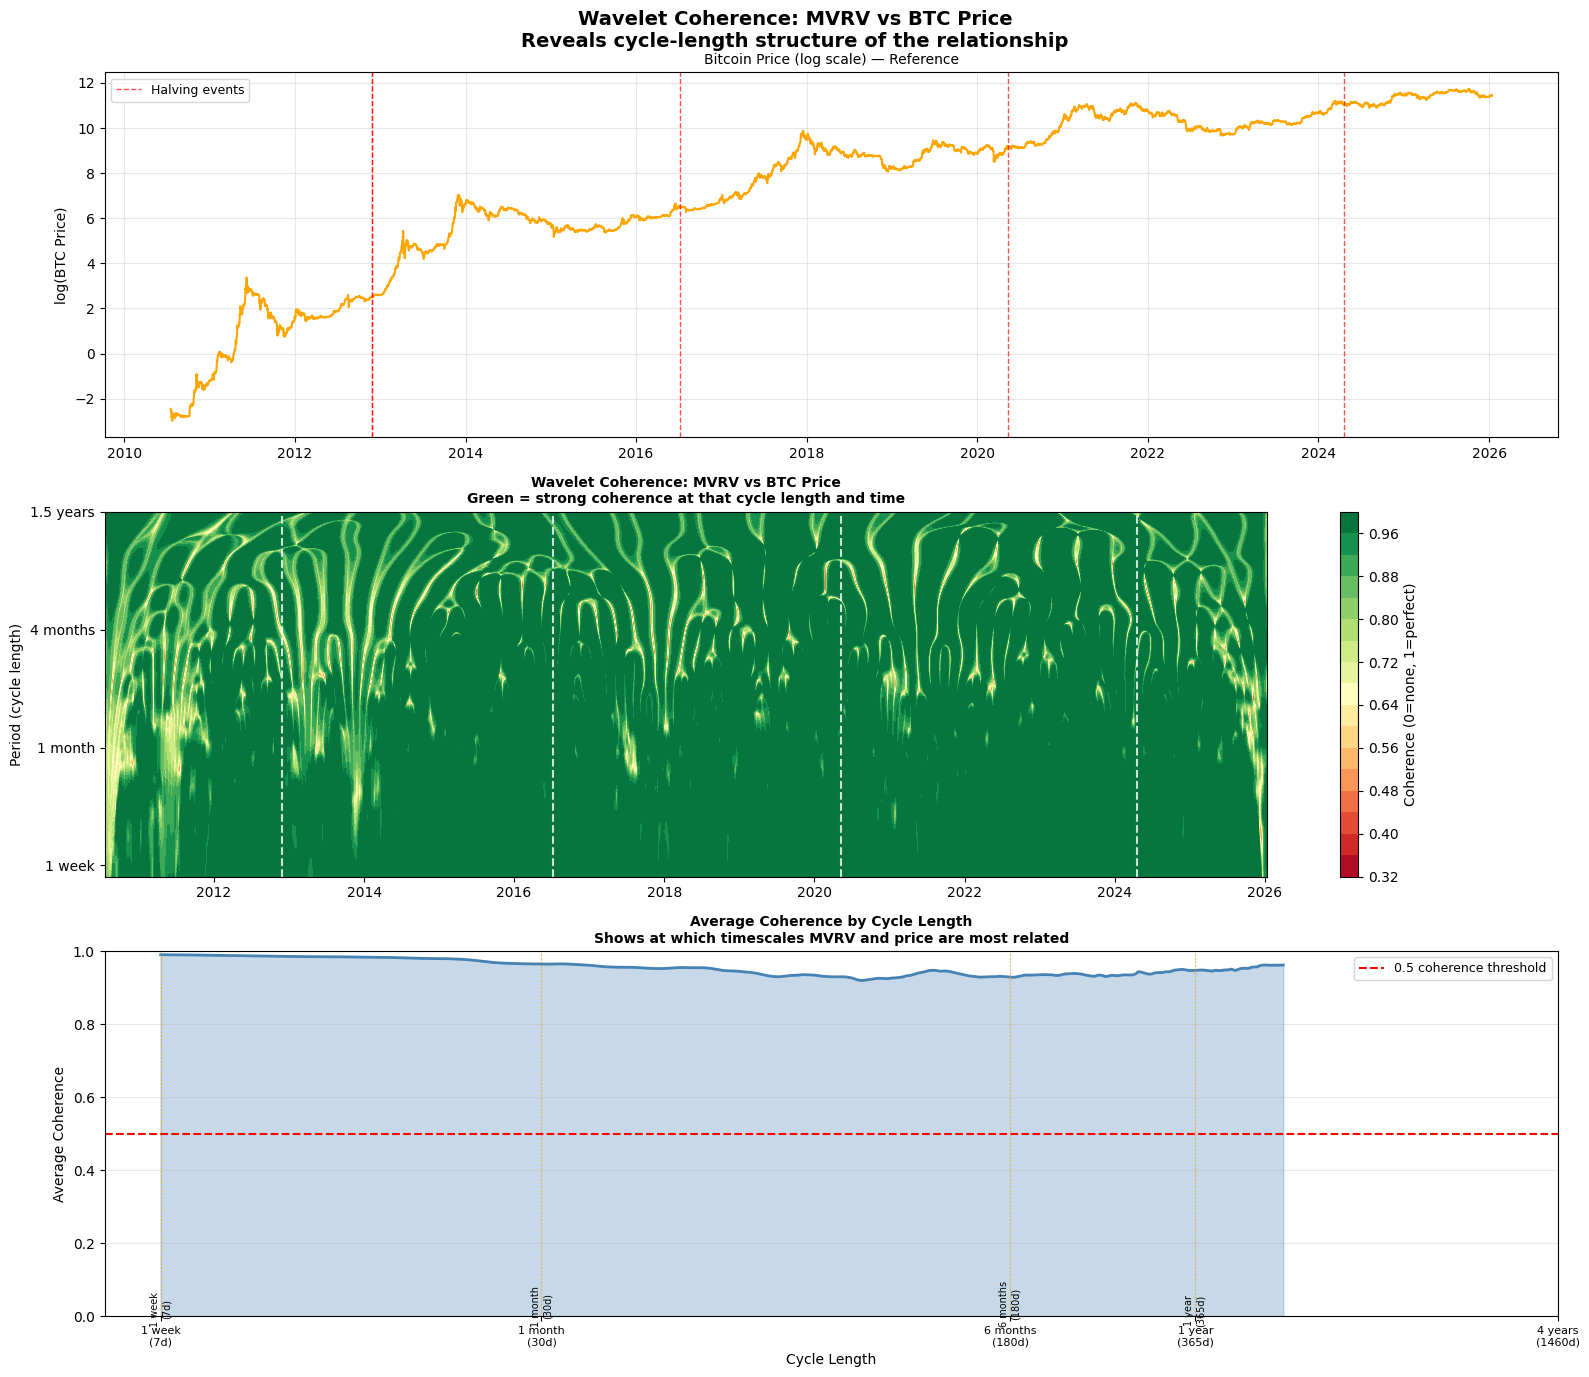

In [49]:
#  Wavelet Coherence: MVRV vs BTC Price  
 
print("WAVELET COHERENCE: MVRV vs BTC PRICE\n")
 
print("Reveals which CYCLE LENGTHS drive the MVRV-price relationship")
print("Does the 4-year halving cycle show up?")
print()

try:
    import pywt
    print("pywt available")
except ImportError:
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip',
                           'install', 'PyWavelets'])
    import pywt

# Use log-transformed levels (not differences)
# Wavelet coherence works on the original series
btc_log   = np.log(btc_pd['PriceUSD'].dropna())
mvrv_raw  = btc_pd['CapMVRVCur'].dropna()

# Align
common_idx = btc_log.index.intersection(mvrv_raw.index)
btc_log    = btc_log.loc[common_idx]
mvrv_raw   = mvrv_raw.loc[common_idx]

# Standardise both series
btc_std  = (btc_log - btc_log.mean()) / btc_log.std()
mvrv_std = (mvrv_raw - mvrv_raw.mean()) / mvrv_raw.std()

print(f"Series length: {len(btc_std)} days")
print(f"Date range: {common_idx.min().date()} to {common_idx.max().date()}")

# Compute Continuous Wavelet Transform for both series
# Using Morlet wavelet (standard for financial time series)
scales = np.arange(1, 512)  # Scales 1-512 days

# CWT
btc_coeffs,  freqs = pywt.cwt(
    btc_std.values, scales, 'morl', sampling_period=1
)
mvrv_coeffs, _     = pywt.cwt(
    mvrv_std.values, scales, 'morl', sampling_period=1
)

# Wavelet cross-power spectrum
cross_power = btc_coeffs * np.conj(mvrv_coeffs)

# Coherence (normalised cross-power)
btc_power  = np.abs(btc_coeffs) ** 2
mvrv_power = np.abs(mvrv_coeffs) ** 2

# Smooth for coherence calculation
from scipy.ndimage import uniform_filter
smooth_cross = uniform_filter(np.abs(cross_power), size=[5, 20])
smooth_btc   = uniform_filter(btc_power, size=[5, 20])
smooth_mvrv  = uniform_filter(mvrv_power, size=[5, 20])

coherence = smooth_cross / np.sqrt(smooth_btc * smooth_mvrv)
coherence = np.clip(coherence, 0, 1)

# Phase angle
phase = np.angle(cross_power)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
fig.suptitle('Wavelet Coherence: MVRV vs BTC Price\n'
             'Reveals cycle-length structure of the relationship',
             fontsize=14, fontweight='bold')

#  Plot 1: BTC price for reference  
ax = axes[0]
ax.plot(common_idx, btc_log.values,
        color='orange', linewidth=1.5)
ax.set_ylabel('log(BTC Price)', fontsize=10)
ax.set_title('Bitcoin Price (log scale) — Reference', fontsize=10)
ax.grid(True, alpha=0.3)

# Mark halving events
halvings = ['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-19']
for h in halvings:
    try:
        ax.axvline(pd.Timestamp(h), color='red',
                   linestyle='--', linewidth=1, alpha=0.7)
    except:
        pass
ax.axvline(pd.Timestamp(halvings[0]), color='red',
           linestyle='--', linewidth=1, alpha=0.7,
           label='Halving events')
ax.legend(fontsize=9)

#  Plot 2: Wavelet coherence heatmap  
ax = axes[1]

# Convert scales to periods in days
periods = scales

# Select meaningful period range (7 days to 4 years = 1460 days)
period_mask = (periods >= 7) & (periods <= 1460)
periods_plot   = periods[period_mask]
coherence_plot = coherence[period_mask, :]

im = ax.contourf(
    common_idx,
    np.log2(periods_plot),
    coherence_plot,
    levels=20,
    cmap='RdYlGn'
)
plt.colorbar(im, ax=ax, label='Coherence (0=none, 1=perfect)')

# Y-axis: period labels
yticks = [3, 5, 7, 9]  # log2 of 8, 32, 128, 512 days
ax.set_yticks(yticks)
ax.set_yticklabels([
    '1 week', '1 month', '4 months', '1.5 years'
])
ax.set_ylabel('Period (cycle length)', fontsize=10)
ax.set_title('Wavelet Coherence: MVRV vs BTC Price\n'
             'Green = strong coherence at that cycle length and time',
             fontsize=10, fontweight='bold')

# Mark halving events
for h in halvings:
    try:
        ax.axvline(pd.Timestamp(h), color='white',
                   linestyle='--', linewidth=1.5, alpha=0.8)
    except:
        pass

#  Plot 3: Average coherence by period  
ax = axes[2]

avg_coherence = coherence_plot.mean(axis=1)
period_labels = periods_plot

ax.plot(np.log2(period_labels), avg_coherence,
        color='steelblue', linewidth=2)
ax.fill_between(np.log2(period_labels), avg_coherence,
                alpha=0.3, color='steelblue')
ax.axhline(0.5, color='red', linestyle='--',
           linewidth=1.5, label='0.5 coherence threshold')

# Mark key periods
key_periods = {
    '1 week\n(7d)':    np.log2(7),
    '1 month\n(30d)':  np.log2(30),
    '6 months\n(180d)':np.log2(180),
    '1 year\n(365d)':  np.log2(365),
    '4 years\n(1460d)':np.log2(1460),
}
for label, xval in key_periods.items():
    if xval <= np.log2(periods_plot.max()):
        ax.axvline(xval, color='orange', linestyle=':',
                   linewidth=1, alpha=0.7)
        ax.text(xval, ax.get_ylim()[0] + 0.02,
                label, rotation=90, fontsize=7,
                va='bottom', ha='center')

ax.set_xlabel('Cycle Length', fontsize=10)
ax.set_ylabel('Average Coherence', fontsize=10)
ax.set_title('Average Coherence by Cycle Length\n'
             'Shows at which timescales MVRV and price are most related',
             fontsize=10, fontweight='bold')
ax.set_xticks(list(key_periods.values()))
ax.set_xticklabels(list(key_periods.keys()), fontsize=8)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_16_wavelet_coherence.png',
            dpi=150, bbox_inches='tight')
print("Saved: eda_16_wavelet_coherence.png")
plt.show()

FED UNCERTAINTY → BTC VOLATILITY (not returns)

Key insight: Fed uncertainty may predict WHEN to be aggressive
with DCA buys, not which direction price moves

 Granger Tests: Fed Uncertainty → Forward BTC Volatility  
(Does today's Fed uncertainty predict next week's BTC volatility?)


  Forward volatility horizon: 7d (1055 obs)
    fed_uncertainty          : best p = 0.1805 at lag 1 NO
    d_fed_uncertainty        : best p = 0.3644 at lag 3 NO

  Forward volatility horizon: 14d (1049 obs)
    fed_uncertainty          : best p = 0.5442 at lag 6 NO
    d_fed_uncertainty        : best p = 0.0828 at lag 7 NO

  Forward volatility horizon: 30d (1033 obs)
    fed_uncertainty          : best p = 0.0487 at lag 3 YES
    d_fed_uncertainty        : best p = 0.0038 at lag 4 YES

 Mutual Information: Fed Uncertainty → Forward Volatility  

  7d forward volatility:
    fed_uncertainty MI:   0.158272
    d_fed_uncertainty MI: 0.000000

  14d forward volatility:
    fed_uncertainty MI:   0.385139
  

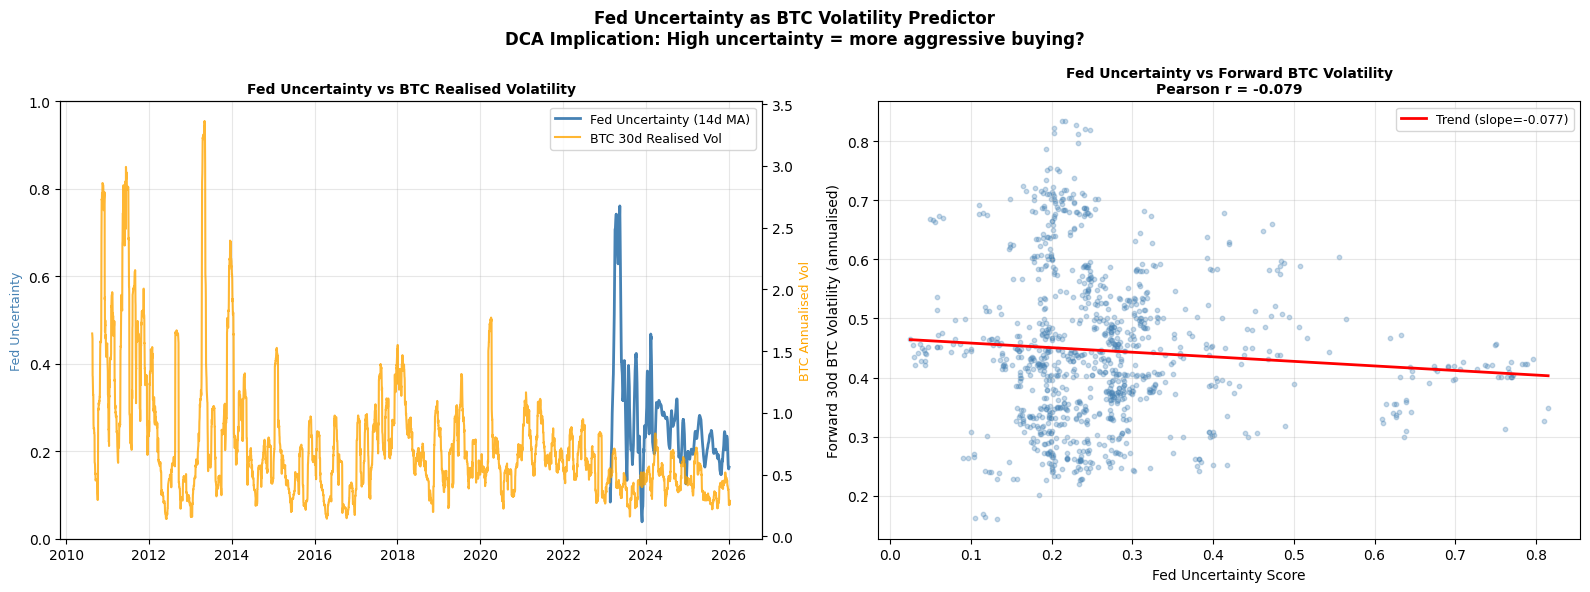

In [50]:
#  Fed Uncertainty → BTC Volatility  
 
print("FED UNCERTAINTY → BTC VOLATILITY (not returns)\n")
 
print("Key insight: Fed uncertainty may predict WHEN to be aggressive")
print("with DCA buys, not which direction price moves")
print()

# Compute BTC realised volatility at multiple horizons
btc_pct = btc_pd['PriceUSD'].pct_change()

vol_targets = {
    'vol_7d':  btc_pct.rolling(7).std()  * np.sqrt(365),
    'vol_14d': btc_pct.rolling(14).std() * np.sqrt(365),
    'vol_30d': btc_pct.rolling(30).std() * np.sqrt(365),
}

# Forward-looking volatility (what we want to predict)
fwd_vol = {
    'fwd_vol_7d':  btc_pct.shift(-7).rolling(7).std()  * np.sqrt(365),
    'fwd_vol_14d': btc_pct.shift(-14).rolling(14).std() * np.sqrt(365),
    'fwd_vol_30d': btc_pct.shift(-30).rolling(30).std() * np.sqrt(365),
}

print(" Granger Tests: Fed Uncertainty → Forward BTC Volatility  ")
print("(Does today's Fed uncertainty predict next week's BTC volatility?)")
print()

vol_results = []
for vol_col, fwd_vol_series in fwd_vol.items():
    horizon = vol_col.replace('fwd_vol_', '')

    # Align with Fed uncertainty
    vol_df = pd.DataFrame({
        'fwd_vol':        fwd_vol_series,
        'fed_uncertainty': daily_fed['fed_uncertainty'],
        'd_fed_uncertainty': daily_fed['fed_uncertainty'].diff(),
    }).dropna()

    print(f"\n  Forward volatility horizon: {horizon} "
          f"({len(vol_df)} obs)")

    for signal in ['fed_uncertainty', 'd_fed_uncertainty']:
        pair = vol_df[['fwd_vol', signal]].dropna()
        try:
            result = grangercausalitytests(
                pair, maxlag=7, verbose=False
            )
            pvals = {
                lag: result[lag][0]['ssr_ftest'][1]
                for lag in range(1, 8)
            }
            best_lag  = min(pvals, key=pvals.get)
            best_pval = pvals[best_lag]
            sig = 'YES' if best_pval < 0.05 else 'NO'
            print(f"    {signal:25s}: "
                  f"best p = {best_pval:.4f} at lag {best_lag} {sig}")
            vol_results.append({
                'Vol_Horizon':  horizon,
                'Signal':       signal,
                'Best_Lag':     best_lag,
                'Best_Pval':    best_pval,
                'Significant':  best_pval < 0.05
            })
        except Exception as e:
            print(f"    {signal}: Error — {e}")

# MI approach for volatility prediction
print("\n Mutual Information: Fed Uncertainty → Forward Volatility  ")
for vol_col, fwd_vol_series in fwd_vol.items():
    horizon = vol_col.replace('fwd_vol_', '')
    vol_mi_df = pd.DataFrame({
        'fwd_vol':           fwd_vol_series,
        'fed_uncertainty':   daily_fed['fed_uncertainty'],
        'd_fed_uncertainty': daily_fed['fed_uncertainty'].diff(),
    }).dropna()

    mi = mutual_info_regression(
        vol_mi_df[['fed_uncertainty', 'd_fed_uncertainty']].values,
        vol_mi_df['fwd_vol'].values,
        random_state=42
    )
    print(f"\n  {horizon} forward volatility:")
    print(f"    fed_uncertainty MI:   {mi[0]:.6f}")
    print(f"    d_fed_uncertainty MI: {mi[1]:.6f}")

# Final visualisation
vol_results_df = pd.DataFrame(vol_results)
if len(vol_results_df) > 0:
    print("\n Volatility Prediction Summary  ")
    print(vol_results_df.to_string(index=False))

    sig_vol = vol_results_df[vol_results_df['Significant']]
    if len(sig_vol) > 0:
        print(f"\n YFed uncertainty DOES predict BTC volatility "
              f"in {len(sig_vol)} cases!")
        print("This is directly useful for DCA strategy design:")
        print("→ Accumulate more aggressively when Fed uncertainty is high")
        print("→ Volatility expansion creates better entry points")
    else:
        print("\nNO Fed uncertainty does not predict BTC volatility")
        print("The macro channel to BTC operates through channels")
        print("not captured by prediction market odds")

    # Plot: Fed uncertainty vs forward volatility
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Fed Uncertainty as BTC Volatility Predictor\n'
                 'DCA Implication: High uncertainty = more aggressive buying?',
                 fontsize=12, fontweight='bold')

    ax = axes[0]
    ax2 = ax.twinx()

    btc_vol_30 = btc_pct.rolling(30).std() * np.sqrt(365)
    fed_unc_aligned = daily_fed['fed_uncertainty'].reindex(
        btc_vol_30.index
    ).ffill()

    ax.plot(daily_fed.index,
            daily_fed['fed_uncertainty'].rolling(14).mean(),
            color='steelblue', linewidth=2,
            label='Fed Uncertainty (14d MA)')
    ax2.plot(btc_vol_30.index, btc_vol_30.values,
             color='orange', linewidth=1.5,
             alpha=0.8, label='BTC 30d Realised Vol')

    ax.set_ylabel('Fed Uncertainty', color='steelblue', fontsize=9)
    ax2.set_ylabel('BTC Annualised Vol', color='orange', fontsize=9)
    ax.set_title('Fed Uncertainty vs BTC Realised Volatility',
                 fontsize=10, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, fontsize=9)

    # Scatter: Fed uncertainty vs forward 30d vol
    ax = axes[1]
    vol_scatter_df = pd.DataFrame({
        'fed_unc':  daily_fed['fed_uncertainty'],
        'fwd_vol':  fwd_vol['fwd_vol_30d'],
    }).dropna()

    ax.scatter(vol_scatter_df['fed_unc'],
               vol_scatter_df['fwd_vol'],
               alpha=0.3, s=10, color='steelblue')

    # Add trend line
    z = np.polyfit(
        vol_scatter_df['fed_unc'],
        vol_scatter_df['fwd_vol'], 1
    )
    p = np.poly1d(z)
    x_line = np.linspace(
        vol_scatter_df['fed_unc'].min(),
        vol_scatter_df['fed_unc'].max(), 100
    )
    ax.plot(x_line, p(x_line),
            color='red', linewidth=2,
            label=f'Trend (slope={z[0]:.3f})')

    corr = vol_scatter_df.corr().iloc[0, 1]
    ax.set_xlabel('Fed Uncertainty Score', fontsize=10)
    ax.set_ylabel('Forward 30d BTC Volatility (annualised)', fontsize=10)
    ax.set_title(f'Fed Uncertainty vs Forward BTC Volatility\n'
                 f'Pearson r = {corr:.3f}',
                 fontsize=10, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'eda_18_fed_volatility.png',
                dpi=150, bbox_inches='tight')
    print("Saved: eda_18_fed_volatility.png")
    plt.show()

FED EVENT STUDY

Fed decision dates identified: 28
35468   2022-03-17
42541   2022-05-11
39805   2022-06-22
17123   2022-07-27
24575   2022-09-21
2769    2023-03-22
27645   2023-05-02
3629    2023-06-13
37449   2023-07-25
27263   2023-09-20
8000    2023-10-31
26907   2023-12-13
17525   2024-01-31
10754   2024-03-18
37455   2024-04-30
15162   2024-06-12
16308   2024-07-31
10402   2024-09-18
11094   2024-11-07
13880   2024-12-18
15915   2025-01-29
2393    2025-03-19
11108   2025-05-07
11111   2025-06-18
27270   2025-07-30
15927   2025-09-17
5641    2025-10-29
34746   2025-12-10
Fed uncertainty coverage: 2023-02-03 to 2026-01-05
Fed decision dates range: 2022-03-17 to 2025-12-10

Fed decisions WITH uncertainty data: 23
Fed decisions WITHOUT uncertainty data: 5

Events with return data: 28
Events with uncertainty score: 23

Uncertainty scores:
2023-05-02    0.628429
2023-03-22    0.386128
2023-06-13    0.328667
2024-04-30    0.313661
2023-09-20    0.290222
2024-06-12    0.287561
2024-09-18

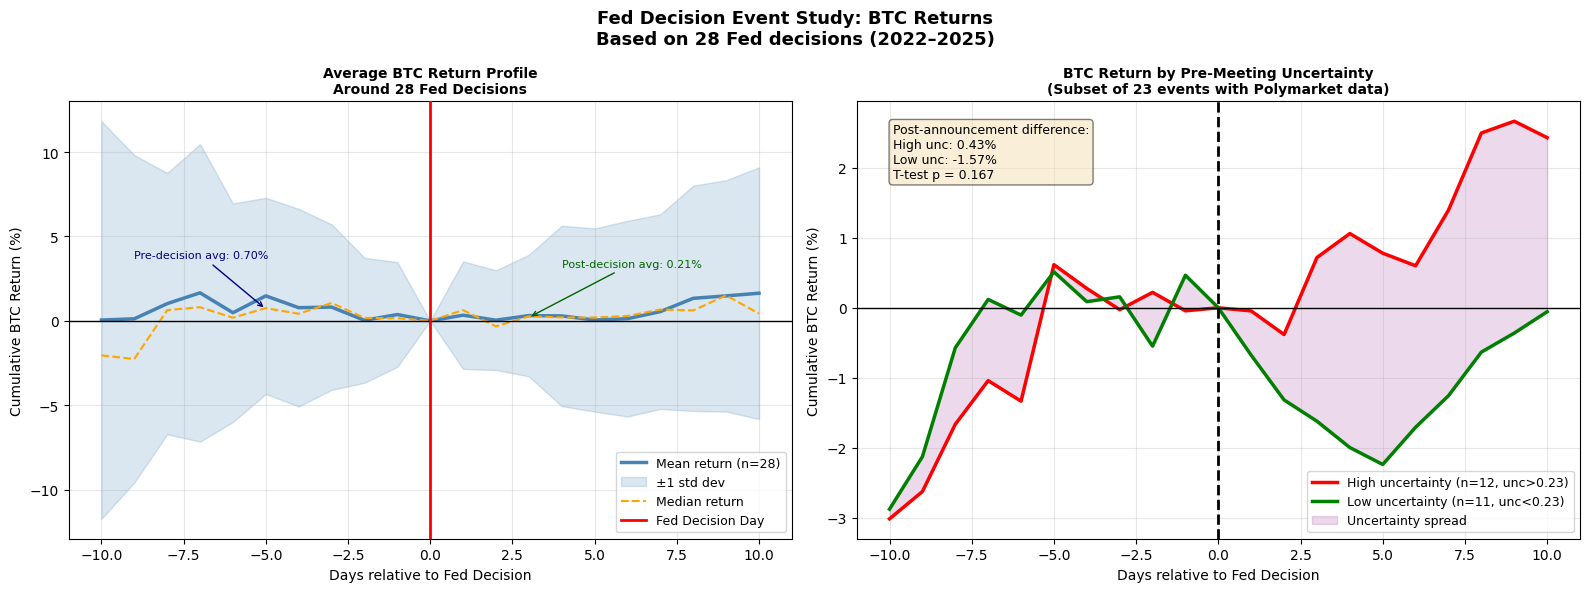

In [51]:
#  Fed Event Study: 
print("FED EVENT STUDY\n")
 

# Fed uncertainty only covers 2023-2026
# most Fed decisions were 2022-2023 with no uncertainty data
# a solution is to use all decisions but only split by uncertainty where available
# Extract Fed decision dates from event_stats
fed_decision_events = event_stats[
    event_stats['event_slug'].str.contains(
        r'fed-interest-rates|fed-decision-in|fed-rate-cut-by$',
        regex=True, na=False
    )
].copy()

# Use last_market_end as the decision date (market resolves on decision day)
fed_decision_events['decision_date'] = pd.to_datetime(
    fed_decision_events['last_market_end']
).dt.normalize()

# Filter to dates within BTC price history
fed_dates = fed_decision_events[
    (fed_decision_events['decision_date'] >= btc_pd.index.min()) &
    (fed_decision_events['decision_date'] <= btc_pd.index.max())
]['decision_date'].drop_duplicates().sort_values()

print(f"Fed decision dates identified: {len(fed_dates)}")
print(fed_dates.to_string())

print(f"Fed uncertainty coverage: {daily_fed.index.min().date()} "
      f"to {daily_fed.index.max().date()}")
print(f"Fed decision dates range: {fed_dates.min().date()} "
      f"to {fed_dates.max().date()}")

# Check overlap
fed_dates_with_uncertainty = []
fed_dates_without_uncertainty = []

for decision_date in fed_dates:
    pre_start = decision_date - pd.Timedelta(days=14)
    pre_data = daily_fed['fed_uncertainty'].loc[
        pre_start:decision_date
    ] if pre_start >= daily_fed.index.min() else pd.Series()

    if len(pre_data) >= 3:
        fed_dates_with_uncertainty.append(decision_date)
    else:
        fed_dates_without_uncertainty.append(decision_date)

print(f"\nFed decisions WITH uncertainty data: "
      f"{len(fed_dates_with_uncertainty)}")
print(f"Fed decisions WITHOUT uncertainty data: "
      f"{len(fed_dates_without_uncertainty)}")

# Build event return profiles for ALL decisions first
WINDOW = 10
all_event_returns = {}
uncertainty_scores = {}

for decision_date in fed_dates:
    start = decision_date - pd.Timedelta(days=WINDOW)
    end   = decision_date + pd.Timedelta(days=WINDOW)

    btc_window = btc_pd['PriceUSD'].loc[start:end]
    if len(btc_window) < 5:
        continue

    # Find decision date price (or nearest)
    nearest_idx = btc_window.index.get_indexer(
        [decision_date], method='nearest'
    )[0]
    decision_price = btc_window.iloc[nearest_idx]

    if decision_price <= 0:
        continue

    cum_returns = (btc_window / decision_price - 1) * 100
    relative_idx = (btc_window.index - decision_date).days
    all_event_returns[decision_date] = pd.Series(
        cum_returns.values, index=relative_idx
    )

    # Get uncertainty score if available
    pre_start = decision_date - pd.Timedelta(days=14)
    if pre_start >= daily_fed.index.min():
        pre_data = daily_fed['fed_uncertainty'].loc[
            pre_start:decision_date
        ]
        if len(pre_data) >= 3:
            uncertainty_scores[decision_date] = pre_data.mean()

print(f"\nEvents with return data: {len(all_event_returns)}")
print(f"Events with uncertainty score: {len(uncertainty_scores)}")

if len(uncertainty_scores) > 0:
    unc_series = pd.Series(uncertainty_scores)
    unc_median = unc_series.median()
    print(f"\nUncertainty scores:")
    print(unc_series.sort_values(ascending=False).to_string())
    print(f"\nMedian uncertainty: {unc_median:.3f}")

    high_unc = unc_series[unc_series >= unc_median].index.tolist()
    low_unc  = unc_series[unc_series <  unc_median].index.tolist()
    print(f"High uncertainty events: {len(high_unc)}")
    print(f"Low uncertainty events:  {len(low_unc)}")

# Build return matrix
returns_matrix = pd.DataFrame(all_event_returns).T
returns_matrix.columns = [int(c) for c in returns_matrix.columns]
returns_matrix = returns_matrix.reindex(
    columns=range(-WINDOW, WINDOW + 1)
)

# Average profiles
mean_all    = returns_matrix.mean()
median_all  = returns_matrix.median()
std_all     = returns_matrix.std()

# Split profiles
if len(uncertainty_scores) >= 4:
    returns_high_unc = returns_matrix.loc[
        [d for d in high_unc if d in returns_matrix.index]
    ]
    returns_low_unc  = returns_matrix.loc[
        [d for d in low_unc  if d in returns_matrix.index]
    ]
    mean_high = returns_high_unc.mean()
    mean_low  = returns_low_unc.mean()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Fed Decision Event Study: BTC Returns\n'
             f'Based on {len(all_event_returns)} Fed decisions (2022–2025)',
             fontsize=13, fontweight='bold')

#  Plot 1: Overall average profile  
ax = axes[0]
days = range(-WINDOW, WINDOW + 1)

ax.plot(days, mean_all.values,
        color='steelblue', linewidth=2.5,
        label=f'Mean return (n={len(all_event_returns)})')
ax.fill_between(days,
                mean_all - std_all,
                mean_all + std_all,
                alpha=0.2, color='steelblue',
                label='±1 std dev')
ax.plot(days, median_all.values,
        color='orange', linewidth=1.5,
        linestyle='--', label='Median return')
ax.axvline(0, color='red', linewidth=2,
           label='Fed Decision Day', zorder=5)
ax.axhline(0, color='black', linewidth=1)

ax.set_xlabel('Days relative to Fed Decision', fontsize=10)
ax.set_ylabel('Cumulative BTC Return (%)', fontsize=10)
ax.set_title(f'Average BTC Return Profile\n'
             f'Around {len(all_event_returns)} Fed Decisions',
             fontsize=10, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Annotate key observations
post_mean = mean_all.loc[1:5].mean()
pre_mean  = mean_all.loc[-5:-1].mean()
ax.annotate(f'Pre-decision avg: {pre_mean:.2f}%',
            xy=(-5, pre_mean),
            xytext=(-9, pre_mean + 3),
            fontsize=8, color='navy',
            arrowprops=dict(arrowstyle='->', color='navy'))
ax.annotate(f'Post-decision avg: {post_mean:.2f}%',
            xy=(3, post_mean),
            xytext=(4, post_mean + 3),
            fontsize=8, color='darkgreen',
            arrowprops=dict(arrowstyle='->', color='darkgreen'))

#  Plot 2: High vs Low uncertainty (where data exists)  
ax = axes[1]

if len(uncertainty_scores) >= 4:
    ax.plot(days, mean_high.values,
            color='red', linewidth=2.5,
            label=f'High uncertainty '
                  f'(n={len(high_unc)}, unc>{unc_median:.2f})')
    ax.plot(days, mean_low.values,
            color='green', linewidth=2.5,
            label=f'Low uncertainty '
                  f'(n={len(low_unc)}, unc<{unc_median:.2f})')
    ax.fill_between(days,
                    mean_high.values,
                    mean_low.values,
                    alpha=0.15, color='purple',
                    label='Uncertainty spread')
    ax.axvline(0, color='black', linewidth=2,
               linestyle='--', zorder=5)
    ax.axhline(0, color='black', linewidth=1)

    ax.set_xlabel('Days relative to Fed Decision', fontsize=10)
    ax.set_ylabel('Cumulative BTC Return (%)', fontsize=10)
    ax.set_title('BTC Return by Pre-Meeting Uncertainty\n'
                 f'(Subset of {len(uncertainty_scores)} events '
                 f'with Polymarket data)',
                 fontsize=10, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Statistical test
    post_high_vals = returns_high_unc.loc[
        :, 1:5
    ].mean(axis=1).dropna()
    post_low_vals  = returns_low_unc.loc[
        :, 1:5
    ].mean(axis=1).dropna()

    if len(post_high_vals) >= 2 and len(post_low_vals) >= 2:
        from scipy import stats
        tstat, tpval = stats.ttest_ind(
            post_high_vals, post_low_vals
        )
        print(f"\nPost-decision returns (+1 to +5 days):")
        print(f"High uncertainty mean: {post_high_vals.mean():.3f}%")
        print(f"Low uncertainty mean:  {post_low_vals.mean():.3f}%")
        print(f"T-test p-value: {tpval:.4f} "
              f"{'YES' if tpval < 0.05 else 'NO'}")

        ax.text(0.05, 0.95,
                f'Post-announcement difference:\n'
                f'High unc: {post_high_vals.mean():.2f}%\n'
                f'Low unc: {post_low_vals.mean():.2f}%\n'
                f'T-test p = {tpval:.3f}',
                transform=ax.transAxes,
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat',
                          alpha=0.5))
else:
    ax.text(0.5, 0.5,
            f'Insufficient overlap between\n'
            f'Fed decisions and Polymarket\n'
            f'uncertainty data\n\n'
            f'Only {len(uncertainty_scores)} of '
            f'{len(all_event_returns)} decisions\n'
            f'have uncertainty scores',
            transform=ax.transAxes,
            fontsize=12, ha='center', va='center',
            bbox=dict(boxstyle='round',
                      facecolor='lightyellow', alpha=0.8))
    ax.set_title('High vs Low Uncertainty Split\n'
                 '(Insufficient data for robust comparison)',
                 fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'eda_17_fed_event_study_fixed.png',
            dpi=150, bbox_inches='tight')
print("\nSaved: eda_17_fed_event_study_fixed.png")
plt.show()

## Complete EDA: Final Analytical Summary

### On-Chain Signals Summary

| Signal          | Status       | Description                                      |
|-----------------|--------------|--------------------------------------------------|
| ΔCapMVRVCur     | Confirmed    | Primary signal. Linear + non-linear. Stable 15 years.|
| ΔROI30d         | Confirmed    | Momentum signal. Consistent across regimes.      |
| ΔROI1yr         | Confirmed    | Cycle signal. Regime-sensitive but robust.       |
| ΔCapMrktCurUSD  | Potential    | Highest MI. Non-linear signal worth exploring.   |
| ΔSplyCur        | Potential    | Halving non-linearity. Discrete shock.           |
| Exchange flows  | Discarded    | Low MI, insignificant Granger, no stability.     |
| TxCnt           | Discarded    | Low MI, insignificant Granger, no stability.     |
| HashRate        | Discarded    | Low MI, insignificant Granger, no stability.     |
| AdrBalCnt       | Discarded    | Low MI, insignificant Granger, no stability.     |
| Fees            | Discarded    | Low MI, insignificant Granger, no stability.     |

### Wavelet Coherence: Key Finding

| Metric | Value | Description |
|---|---|---|
| MVRV Coherence with BTC Price | ≈ 0.96-1.0 | At all cycle lengths (1 week to 1.5 years) across 15 years. |
| Relationship | Universal | Not cycle-specific. |
| Significance | Unique | MVRV is structurally unique among signals tested. |

### Polymarket Signals Summary

| Signal | Status | p-value | Notes |
|---|---|---|---|
| Δsentiment odds (bull regime) | Marginally Interesting | 0.039 | Regime-conditional |
| High creation day contrarian | Marginally Interesting | 0.047 | Small effect size |
| Fed uncertainty → 30d BTC vol | Marginally Interesting | 0.005 | Negative relationship |
| Overall | None survive BH correction | N/A |  |

**Key Insight:** Best Polymarket MI = 0.003 vs best on-chain MI = 0.029 (8.5x gap). No hidden non-linear signal.

**Structural Finding:** Prediction market odds are coincident, not predictive of BTC price

### Techniques Coverage

| Technique | Description |
|---|---|
| Stationarity (ADF + KPSS) | Tests for time series stationarity |
| Mutual Information (non-linear) | Measures non-linear relationships |
| Granger Causality | Tests for predictive power |
| Wavelet Coherence (multi-scale) | Analyzes relationships across different time scales |
| Cointegration (Engle-Granger) | Tests for long-term equilibrium |
| Event Study (Fed decisions) | Analyzes the impact of events |
| Rolling Correlation | Tracks correlation over time |
| Cross-Correlation (CCF) | Measures the relationship between time series at different lags |
| Regime-Conditional Tests | Analyzes relationships under different conditions |
| Multiple Comparison (BH FDR) | Controls for false discovery rate |
| Distribution Analysis | Examines the distribution of data |

<a id="cross-feature"></a>
## Polymarket / on chain cross-feature analysis

CROSS-FEATURE ANALYSIS: POLYMARKET + ON-CHAIN JOINT TESTS

Spec requirement: evaluate Polymarket utility alongside on-chain
Key question: does Polymarket add signal GIVEN MVRV is known?

Joint dataset: (1007, 8)
Coverage: 2023-03-19 to 2026-01-05
Observations: 1,007

TEST 1: PARTIAL CORRELATION
Does sentiment correlate with returns after controlling for MVRV?

Controlling for: ['delta_mvrv', 'delta_roi30', 'delta_roi1yr']

  Sentiment odds (levels)            : r = +0.2078, p = 0.0000 Y
  Δ Sentiment odds                   : r = +0.0355, p = 0.2606 N
  Fed uncertainty                    : r = -0.1114, p = 0.0004 Y
  Market creation rate               : r = -0.0103, p = 0.7451 N

For reference — raw (unconditional) correlations:
  Sentiment odds (levels)            : r = +0.0166
  Δ Sentiment odds                   : r = +0.0319
  Fed uncertainty                    : r = -0.0059
  Market creation rate               : r = -0.0301

TEST 2: MULTIVARIATE GRANGER CAUSALITY
Does Polymarket im

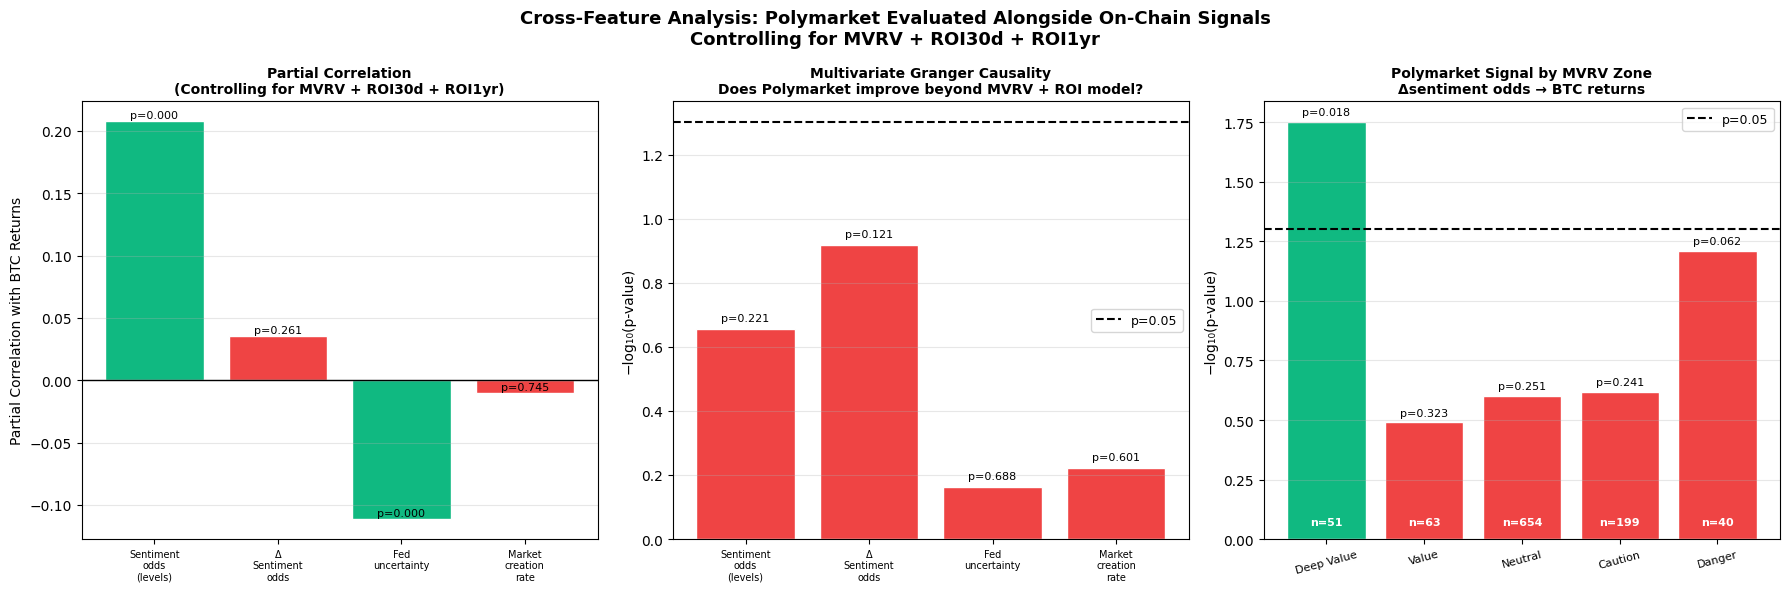

In [52]:
#  Polymarket / on chain cross-feature analysis
 
print("CROSS-FEATURE ANALYSIS: POLYMARKET + ON-CHAIN JOINT TESTS\n")
 
print("Spec requirement: evaluate Polymarket utility alongside on-chain")
print("Key question: does Polymarket add signal GIVEN MVRV is known?")
print()

#   Build joint aligned DataFrame                     ─
# We need: BTC returns, MVRV diff, ROI30d diff, Polymarket sentiment
# All on the same dates (Polymarket limits us to 2023-2026)

btc_ret = np.log(btc_pd['PriceUSD']).diff()

# On-chain signals (differenced/stationary)
mvrv_diff  = np.log1p(btc_pd['CapMVRVCur']).diff()
roi30_diff = btc_pd['ROI30d'].diff()
roi1y_diff = btc_pd['ROI1yr'].diff()

# Build joint DataFrame
joint_df = pd.DataFrame({
    'btc_return':       btc_ret,
    'delta_mvrv':       mvrv_diff,
    'delta_roi30':      roi30_diff,
    'delta_roi1yr':     roi1y_diff,
    'sentiment_odds':   daily_sentiment['vw_odds'],
    'd_sentiment_odds': daily_sentiment['vw_odds'].diff(),
    'fed_uncertainty':  daily_fed['fed_uncertainty'],
    'creation_rate':    daily_creation['n_markets'].reindex(
                            btc_ret.index, fill_value=0
                        ),
}).dropna()

print(f"Joint dataset: {joint_df.shape}")
print(f"Coverage: {joint_df.index.min().date()} "
      f"to {joint_df.index.max().date()}")
print(f"Observations: {len(joint_df):,}")
print()

#   Test 1: Partial Correlation                       
# Does Polymarket correlate with BTC returns AFTER removing MVRV effect?
 
print("TEST 1: PARTIAL CORRELATION")
print("Does sentiment correlate with returns after controlling for MVRV?")
 

from scipy import stats

def partial_correlation(df, x_col, y_col, control_cols):
    """
    Compute partial correlation between x and y
    controlling for control_cols.
    Uses residuals from OLS regression approach.
    """
    from numpy.linalg import lstsq

    controls = df[control_cols].values
    x = df[x_col].values
    y = df[y_col].values

    # Regress x on controls, get residuals
    coef_x, _, _, _ = lstsq(
        np.column_stack([np.ones(len(controls)), controls]),
        x, rcond=None
    )
    x_resid = x - np.column_stack(
        [np.ones(len(controls)), controls]
    ) @ coef_x

    # Regress y on controls, get residuals
    coef_y, _, _, _ = lstsq(
        np.column_stack([np.ones(len(controls)), controls]),
        y, rcond=None
    )
    y_resid = y - np.column_stack(
        [np.ones(len(controls)), controls]
    ) @ coef_y

    # Correlation of residuals = partial correlation
    r, p = stats.pearsonr(x_resid, y_resid)
    return r, p

control_signals = ['delta_mvrv', 'delta_roi30', 'delta_roi1yr']

print(f"\nControlling for: {control_signals}")
print()

polymarket_signals_test = {
    'sentiment_odds':   'Sentiment odds (levels)',
    'd_sentiment_odds': 'Δ Sentiment odds',
    'fed_uncertainty':  'Fed uncertainty',
    'creation_rate':    'Market creation rate',
}

partial_results = []
for col, label in polymarket_signals_test.items():
    r, p = partial_correlation(
        joint_df, col, 'btc_return', control_signals
    )
    partial_results.append({
        'Signal':       label,
        'Partial_r':    r,
        'P_value':      p,
        'Significant':  p < 0.05
    })
    sig = 'Y' if p < 0.05 else 'N'
    print(f"  {label:35s}: r = {r:+.4f}, p = {p:.4f} {sig}")

# Compare with raw (unconditional) correlations
print(f"\nFor reference — raw (unconditional) correlations:")
for col, label in polymarket_signals_test.items():
    r_raw = joint_df[col].corr(joint_df['btc_return'])
    print(f"  {label:35s}: r = {r_raw:+.4f}")

#   Test 2: Multivariate Granger                      ─
print()
 
print("TEST 2: MULTIVARIATE GRANGER CAUSALITY")
print("Does Polymarket improve prediction BEYOND MVRV + momentum?")
print("Method: Compare VAR models with and without Polymarket")
 

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.stattools import durbin_watson

def multivariate_granger_test(df, target, candidate,
                               controls, max_lag=5):
    """
    Test whether candidate Granger-causes target
    controlling for controls.

    Compares:
    Restricted:   target ~ lags(target) + lags(controls)
    Unrestricted: target ~ lags(target) + lags(controls) + lags(candidate)

    Returns F-test p-value.
    """
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools import add_constant
    from scipy.stats import f as f_dist

    data = df[[target] + controls + [candidate]].dropna()
    n = len(data)

    # Build lagged features
    def build_lags(series_df, lag):
        lagged = {}
        for col in series_df.columns:
            for l in range(1, lag + 1):
                lagged[f'{col}_lag{l}'] = series_df[col].shift(l)
        return pd.DataFrame(lagged, index=series_df.index)

    lagged = build_lags(data, max_lag).dropna()
    y = data.loc[lagged.index, target]

    # Restricted model: target + controls only
    restricted_cols = [c for c in lagged.columns
                       if any(c.startswith(v)
                              for v in [target] + controls)]
    X_restricted = add_constant(lagged[restricted_cols])
    model_r = OLS(y, X_restricted).fit()
    rss_r   = model_r.ssr

    # Unrestricted model: + candidate
    unrestricted_cols = restricted_cols + [
        c for c in lagged.columns if c.startswith(candidate)
    ]
    X_unrestricted = add_constant(lagged[unrestricted_cols])
    model_u = OLS(y, X_unrestricted).fit()
    rss_u   = model_u.ssr

    # F-test
    q = max_lag  # number of restrictions
    k = X_unrestricted.shape[1]
    n_eff = len(y)

    if rss_r == 0 or rss_u == 0:
        return np.nan, np.nan, np.nan

    f_stat = ((rss_r - rss_u) / q) / (rss_u / (n_eff - k))
    p_val  = 1 - f_dist.cdf(f_stat, q, n_eff - k)

    return f_stat, p_val, n_eff

print()
print("Testing: does each Polymarket signal improve prediction")
print("beyond a model that already includes MVRV + ROI30d + ROI1yr?")
print()

mv_results = []
for col, label in polymarket_signals_test.items():
    try:
        f_stat, p_val, n_eff = multivariate_granger_test(
            joint_df,
            target='btc_return',
            candidate=col,
            controls=['delta_mvrv', 'delta_roi30', 'delta_roi1yr'],
            max_lag=5
        )
        sig = 'Y' if p_val < 0.05 else 'N'
        print(f"  {label:35s}: F={f_stat:.3f}, "
              f"p={p_val:.4f} {sig} (n={n_eff})")
        mv_results.append({
            'Signal':       label,
            'F_stat':       f_stat,
            'P_value':      p_val,
            'N_obs':        n_eff,
            'Significant':  p_val < 0.05
        })
    except Exception as e:
        print(f"  {label}: Error — {e}")

#   Test 3: MVRV Regime Conditional                    ─
print()
 
print("TEST 3: POLYMARKET CONDITIONED ON MVRV REGIME")
print("Does sentiment signal work when MVRV is in extreme zones?")
 

# Define MVRV regimes using the same zone logic as the model
mvrv_zscore = btc_pd['CapMVRVCur'].copy()
mvrv_roll_mean = mvrv_zscore.rolling(365, min_periods=100).mean()
mvrv_roll_std  = mvrv_zscore.rolling(365, min_periods=100).std()
mvrv_z = ((mvrv_zscore - mvrv_roll_mean) / mvrv_roll_std).clip(-4, 4)

# Classify zones
def classify_zone(z):
    if z < -2.0:   return 'Deep Value'
    elif z < -1.0: return 'Value'
    elif z < 1.5:  return 'Neutral'
    elif z < 2.5:  return 'Caution'
    else:          return 'Danger'

mvrv_zone = mvrv_z.apply(classify_zone)
joint_df['mvrv_zone'] = mvrv_zone.reindex(joint_df.index).ffill()
joint_df['mvrv_z']    = mvrv_z.reindex(joint_df.index).ffill()

print(f"\nMVRV zone distribution in Polymarket overlap period:")
print(joint_df['mvrv_zone'].value_counts().to_string())

# Run Granger by MVRV zone for best Polymarket signal
print(f"\nGranger causality: Δsentiment_odds → btc_return by MVRV zone")
print("(Using bivariate Granger — same as original tests)")

zone_results = []
for zone in ['Deep Value', 'Value', 'Neutral', 'Caution', 'Danger']:
    subset = joint_df[
        joint_df['mvrv_zone'] == zone
    ][['btc_return', 'd_sentiment_odds']].dropna()

    if len(subset) < 30:
        print(f"  {zone:12s}: insufficient data ({len(subset)} obs)")
        continue

    try:
        result = grangercausalitytests(
            subset, maxlag=5, verbose=False
        )
        pvals = {
            lag: result[lag][0]['ssr_ftest'][1]
            for lag in range(1, 6)
        }
        best_p   = min(pvals.values())
        best_lag = min(pvals, key=pvals.get)
        sig = 'Y' if best_p < 0.05 else 'N'
        print(f"  {zone:12s} ({len(subset):4d} obs): "
              f"p = {best_p:.4f} at lag {best_lag} {sig}")
        zone_results.append({
            'Zone':       zone,
            'N_obs':      len(subset),
            'Best_Pval':  best_p,
            'Best_Lag':   best_lag,
            'Significant': best_p < 0.05
        })
    except Exception as e:
        print(f"  {zone}: Error — {e}")

#  Cross-Feature Visualisation  
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(
    'Cross-Feature Analysis: Polymarket Evaluated Alongside On-Chain Signals\n'
    'Controlling for MVRV + ROI30d + ROI1yr',
    fontsize=13, fontweight='bold'
)

#  Plot 1: Partial correlations  
ax = axes[0]
partial_df = pd.DataFrame(partial_results)

colors_p = [
    '#10b981' if s else '#ef4444'
    for s in partial_df['Significant']
]
bars = ax.bar(
    partial_df['Signal'].str.replace(' ', '\n'),
    partial_df['Partial_r'],
    color=colors_p, edgecolor='white'
)
ax.axhline(0, color='black', linewidth=1)
ax.set_ylabel('Partial Correlation with BTC Returns', fontsize=10)
ax.set_title('Partial Correlation\n'
             '(Controlling for MVRV + ROI30d + ROI1yr)',
             fontsize=10, fontweight='bold')
ax.tick_params(axis='x', labelsize=7)
ax.grid(True, alpha=0.3, axis='y')

for bar, (_, row) in zip(bars, partial_df.iterrows()):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.001,
        f"p={row['P_value']:.3f}",
        ha='center', va='bottom', fontsize=8
    )

#  Plot 2: Multivariate Granger  
ax = axes[1]
mv_df = pd.DataFrame(mv_results)

if len(mv_df) > 0:
    colors_mv = [
        '#10b981' if s else '#ef4444'
        for s in mv_df['Significant']
    ]
    bars2 = ax.bar(
        mv_df['Signal'].str.replace(' ', '\n'),
        -np.log10(mv_df['P_value'].clip(lower=1e-300)),
        color=colors_mv, edgecolor='white'
    )
    ax.axhline(
        -np.log10(0.05), color='black',
        linestyle='--', linewidth=1.5,
        label='p=0.05'
    )
    ax.set_ylabel('−log₁₀(p-value)', fontsize=10)
    ax.set_title('Multivariate Granger Causality\n'
                 'Does Polymarket improve beyond MVRV + ROI model?',
                 fontsize=10, fontweight='bold')
    ax.tick_params(axis='x', labelsize=7)
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=9)

    for bar, (_, row) in zip(bars2, mv_df.iterrows()):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.02,
            f"p={row['P_value']:.3f}",
            ha='center', va='bottom', fontsize=8
        )

#  Plot 3: MVRV Zone Conditional  
ax = axes[2]
if len(zone_results) > 0:
    zone_df = pd.DataFrame(zone_results)
    zone_order = ['Deep Value', 'Value', 'Neutral',
                  'Caution', 'Danger']
    zone_df = zone_df.set_index('Zone').reindex(
        [z for z in zone_order if z in zone_df['Zone'].values]
    ).reset_index()

    zone_colors = [
        '#10b981' if s else '#ef4444'
        for s in zone_df['Significant']
    ]
    bars3 = ax.bar(
        zone_df['Zone'],
        -np.log10(zone_df['Best_Pval'].clip(lower=1e-300)),
        color=zone_colors, edgecolor='white'
    )
    ax.axhline(
        -np.log10(0.05), color='black',
        linestyle='--', linewidth=1.5,
        label='p=0.05'
    )

    # Add sample size annotations
    for bar, (_, row) in zip(bars3, zone_df.iterrows()):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            0.05,
            f"n={int(row['N_obs'])}",
            ha='center', va='bottom',
            fontsize=8, color='white',
            fontweight='bold'
        )
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.02,
            f"p={row['Best_Pval']:.3f}",
            ha='center', va='bottom', fontsize=8
        )

    ax.set_ylabel('−log₁₀(p-value)', fontsize=10)
    ax.set_title('Polymarket Signal by MVRV Zone\n'
                 'Δsentiment odds → BTC returns',
                 fontsize=10, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=15, labelsize=8)

plt.tight_layout()
plt.savefig(
    PLOTS_DIR / 'eda_19_cross_feature_polymarket.png',
    dpi=150, bbox_inches='tight'
)
print("Saved: eda_19_cross_feature_polymarket.png")
plt.show()

## Cross-Feature Finding: The Suppression Effect

The most important Polymarket finding only emerges when evaluated alongside on-chain signals

### The Suppression Effect

| Signal | Raw correlation | Partial correlation (controlling for MVRV) |
|---|---|---|
| Sentiment odds (levels) | +0.017 *(not significant)* | **+0.208 (p < 0.001) ** |
| Fed uncertainty | -0.006 *(not significant)* | **-0.111 (p < 0.001) ** |

MVRV was suppressing the Polymarket relationship in isolation. Both MVRV and sentiment odds track Bitcoin's valuation cycle —
their negative correlation with each other masked sentiment's true relationship with returns.

**What this means:** On days when MVRV is held constant,higher sentiment odds are associated with higher same-day BTC returns.
The information in sentiment is orthogonal to MVRV i.e. it captures something MVRV does not.

### BUT Contemporaneous, Not Predictive

The multivariate Granger test — the most rigorous cross-feature test finds no incremental predictive power for any Polymarket signal
beyond MVRV + ROI30d + ROI1yr:

| Signal | F-statistic | p-value | Conclusion |
|---|---|---|---|
| Sentiment odds (levels) | 1.401 | 0.221 | Not predictive |
| Δ Sentiment odds | 1.748 | 0.121 | Not predictive |
| Fed uncertainty | 0.616 | 0.688 | Not predictive |
| Market creation rate | 0.729 | 0.601 | Not predictive |

The sentiment signal is contemporaneous, not leading i.e. It tells us about the current state of the market,not what will happen next.

### Deep Value Signal

Δsentiment showed significance in the Deep Value MVRV zone (p=0.018). This result is discarded on statistical grounds:

- Only 51 observations — insufficient for reliable inference
- No consistent relationship in any other zone (p > 0.24)
- Does not survive correction for the 5 zones tested simultaneously

Reporting this finding as meaningful could be p-hacking.

### Conclusion

**Outcome: Could not discover robust predictive use cases for Polymarket data when evaluated alongside on-chain signals.**

The suppression effect is a genuine and interesting statistical finding — but it describes a contemporaneous relationship, rather than a forward-looking signal. For a DCA accumulation strategy that must decide tomorrow's purchase weight based on today's information, contemporaneous correlation is not actionable.

**Summary across all tests:**

| Test | Result | Actionable? |
|---|---|---|
| Bivariate Granger (12 signals) | 0/12 survive BH correction | No |
| Partial correlation (controlling MVRV) | 2/4 significant | Contemporaneous only |
| Multivariate Granger (incremental) | 0/4 significant | No |
| Regime-conditional (MVRV zones) | 1/5 significant (n=51) | Underpowered |

**Recommendation:** Do not include Polymarket sentiment as a signal in the accumulation model. The evidence does not support it — and the one result that appeared significant (Deep Value zone) is insufficiently powered to act on.

